In [1]:
from __future__ import print_function, division
import tarfile
import numpy as np
from matplotlib import pyplot as plt
from io import BytesIO
import cv2
from PIL import Image

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.optimizers import RMSprop


import keras.backend as K

Using TensorFlow backend.


In [0]:
class pic(): # Define a Class to do some pre operations of images 
  def __init__(self, filename):
    self.filename = filename;
    self.width = 28 # image width
    self.height = 28 # image height
    self.name_list, self.file_list = self.untar(self.filename)
    self.data_set = self.getdataset(self.file_list)
  
  def untar(self, filename): # uncompress the tar.gz file
    name_list = []
    file_list = []
    with tarfile.open(filename, "r") as file:
        for i in file.getmembers(): # use tar file module to untar the file
            f = file.extractfile(i)
            if f is not None:
              content = f.read()
              name_list.append(i.name)
              file_list.append(content)
    
    return name_list, file_list # return the file name list and file list

  def getdataset(self, file_list): # get data_set with np.array format
    data_set = []
    for i in range(len(file_list)):
      try:
        im = Image.open(BytesIO(file_list[i]))  # file_list is the binary stream, that needs to transfer to image format
      except OSError:
        pass
      im = im.convert("L") # convert images to gray scale
      data = im.getdata()  # get image tuple
      data = np.matrix(data)  # turn the image tuple to matrix
      
      try:
        picture = np.reshape(data,(self.height, self.width))  # turn to numpy array
      except ValueError:
        pass
      left, right = self.splitpic(picture) # split the image to enlarge the data_set
      data_set.append(left)
      data_set.append(right)
    return np.array(data_set)

  def showim(self,picture): # show image
    plt.imshow(picture)
    plt.show()

  def splitpic(self,picture): # split the image
    return np.split(picture, 2, axis=1)[0], np.split(picture, 2, axis=1)[1]
  
  def gendataset(self): # return the data_set
    return self.data_set

In [0]:
class WGAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        self.n_critic = 5
        self.clip_value = 0.01
        optimizer = RMSprop(lr=0.00005)

        self.critic = self.build_critic()
        self.critic.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

        self.generator = self.build_generator()

        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        self.critic.trainable = False

        valid = self.critic(img)

        self.combined = Model(z, valid)
        self.combined.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=4, padding="same"))
        model.add(Activation("tanh"))


        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_critic(self):

        model = Sequential()

        model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Flatten())
        model.add(Dense(1))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()
#         X_train = data_set

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = -np.ones((batch_size, 1))
        fake = np.ones((batch_size, 1))

        for epoch in range(epochs):

            for _ in range(self.n_critic):

                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]
                
                # Sample noise as generator input
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                # Generate a batch of new images
                gen_imgs = self.generator.predict(noise)

                # Train the critic
                d_loss_real = self.critic.train_on_batch(imgs, valid)
                d_loss_fake = self.critic.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)

                # Clip critic weights
                for l in self.critic.layers:
                    weights = l.get_weights()
                    weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                    l.set_weights(weights)


            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f] [G loss: %f]" % (epoch, 1 - d_loss[0], 1 - g_loss[0]))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 1

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
#         fig.savefig("images/mnist_%d.png" % epoch)
        plt.show()
        plt.close()

In [0]:
print (data_set1.shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 14, 14, 16)        160       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 14, 14, 16)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 7, 7, 32)          4640      
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 8, 8, 32)          0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 8, 8, 32)          128       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 8, 8, 32)          0         
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.999928] [G loss: 1.000171]


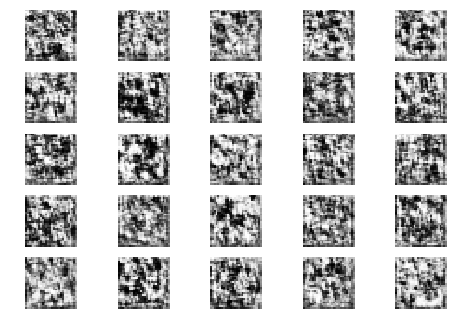

1 [D loss: 0.999931] [G loss: 1.000181]
2 [D loss: 0.999929] [G loss: 1.000178]
3 [D loss: 0.999941] [G loss: 1.000176]
4 [D loss: 0.999936] [G loss: 1.000181]
5 [D loss: 0.999939] [G loss: 1.000171]
6 [D loss: 0.999940] [G loss: 1.000173]
7 [D loss: 0.999943] [G loss: 1.000171]
8 [D loss: 0.999935] [G loss: 1.000179]
9 [D loss: 0.999937] [G loss: 1.000173]
10 [D loss: 0.999948] [G loss: 1.000174]
11 [D loss: 0.999942] [G loss: 1.000172]
12 [D loss: 0.999954] [G loss: 1.000173]
13 [D loss: 0.999947] [G loss: 1.000182]
14 [D loss: 0.999947] [G loss: 1.000154]
15 [D loss: 0.999940] [G loss: 1.000153]
16 [D loss: 0.999936] [G loss: 1.000156]
17 [D loss: 0.999940] [G loss: 1.000153]
18 [D loss: 0.999960] [G loss: 1.000142]
19 [D loss: 0.999942] [G loss: 1.000126]
20 [D loss: 0.999953] [G loss: 1.000125]
21 [D loss: 0.999948] [G loss: 1.000113]
22 [D loss: 0.999970] [G loss: 1.000128]
23 [D loss: 0.999956] [G loss: 1.000118]
24 [D loss: 0.999958] [G loss: 1.000112]
25 [D loss: 0.999954] [G 

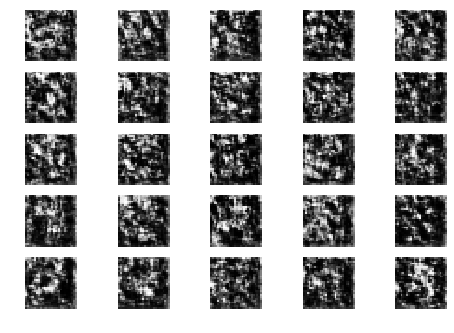

51 [D loss: 0.999979] [G loss: 1.000104]
52 [D loss: 0.999964] [G loss: 1.000063]
53 [D loss: 0.999985] [G loss: 1.000088]
54 [D loss: 0.999987] [G loss: 1.000072]
55 [D loss: 0.999985] [G loss: 1.000083]
56 [D loss: 0.999970] [G loss: 1.000080]
57 [D loss: 0.999996] [G loss: 1.000059]
58 [D loss: 0.999973] [G loss: 1.000094]
59 [D loss: 0.999972] [G loss: 1.000060]
60 [D loss: 1.000013] [G loss: 1.000094]
61 [D loss: 0.999990] [G loss: 1.000048]
62 [D loss: 0.999993] [G loss: 1.000071]
63 [D loss: 0.999979] [G loss: 1.000082]
64 [D loss: 1.000000] [G loss: 1.000070]
65 [D loss: 0.999982] [G loss: 1.000078]
66 [D loss: 0.999950] [G loss: 1.000056]
67 [D loss: 0.999995] [G loss: 1.000074]
68 [D loss: 0.999978] [G loss: 1.000094]
69 [D loss: 1.000017] [G loss: 1.000096]
70 [D loss: 0.999971] [G loss: 1.000128]
71 [D loss: 0.999979] [G loss: 1.000086]
72 [D loss: 1.000006] [G loss: 1.000083]
73 [D loss: 0.999973] [G loss: 1.000106]
74 [D loss: 0.999984] [G loss: 1.000136]
75 [D loss: 0.99

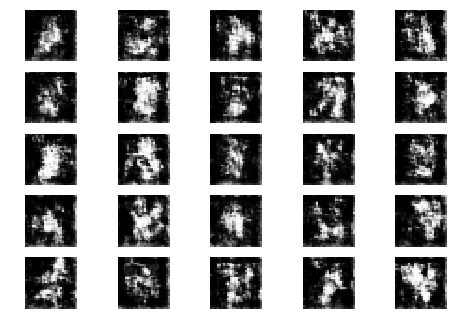

101 [D loss: 0.999959] [G loss: 1.000159]
102 [D loss: 0.999941] [G loss: 1.000157]
103 [D loss: 0.999969] [G loss: 1.000149]
104 [D loss: 0.999983] [G loss: 1.000146]
105 [D loss: 0.999960] [G loss: 1.000169]
106 [D loss: 0.999974] [G loss: 1.000197]
107 [D loss: 0.999962] [G loss: 1.000124]
108 [D loss: 0.999992] [G loss: 1.000126]
109 [D loss: 0.999970] [G loss: 1.000146]
110 [D loss: 0.999961] [G loss: 1.000127]
111 [D loss: 0.999954] [G loss: 1.000142]
112 [D loss: 0.999960] [G loss: 1.000132]
113 [D loss: 0.999976] [G loss: 1.000129]
114 [D loss: 0.999958] [G loss: 1.000148]
115 [D loss: 0.999958] [G loss: 1.000121]
116 [D loss: 0.999966] [G loss: 1.000135]
117 [D loss: 0.999989] [G loss: 1.000124]
118 [D loss: 0.999966] [G loss: 1.000120]
119 [D loss: 0.999954] [G loss: 1.000138]
120 [D loss: 0.999977] [G loss: 1.000088]
121 [D loss: 0.999964] [G loss: 1.000121]
122 [D loss: 0.999951] [G loss: 1.000112]
123 [D loss: 0.999965] [G loss: 1.000100]
124 [D loss: 0.999970] [G loss: 1.

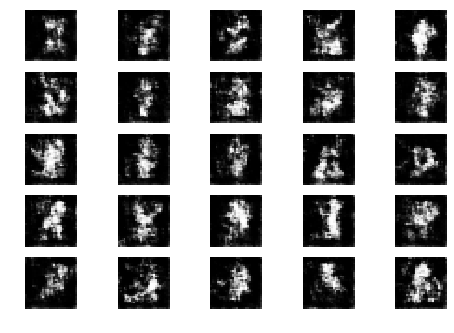

151 [D loss: 0.999974] [G loss: 1.000049]
152 [D loss: 0.999957] [G loss: 1.000063]
153 [D loss: 0.999978] [G loss: 1.000082]
154 [D loss: 0.999968] [G loss: 1.000087]
155 [D loss: 0.999970] [G loss: 1.000083]
156 [D loss: 0.999956] [G loss: 1.000070]
157 [D loss: 0.999967] [G loss: 1.000067]
158 [D loss: 0.999963] [G loss: 1.000063]
159 [D loss: 0.999973] [G loss: 1.000078]
160 [D loss: 0.999972] [G loss: 1.000093]
161 [D loss: 0.999982] [G loss: 1.000071]
162 [D loss: 0.999969] [G loss: 1.000086]
163 [D loss: 0.999953] [G loss: 1.000073]
164 [D loss: 0.999991] [G loss: 1.000069]
165 [D loss: 0.999958] [G loss: 1.000041]
166 [D loss: 0.999962] [G loss: 1.000058]
167 [D loss: 0.999954] [G loss: 1.000047]
168 [D loss: 0.999974] [G loss: 1.000062]
169 [D loss: 0.999952] [G loss: 1.000080]
170 [D loss: 0.999976] [G loss: 1.000077]
171 [D loss: 0.999966] [G loss: 1.000080]
172 [D loss: 0.999966] [G loss: 1.000072]
173 [D loss: 0.999958] [G loss: 1.000082]
174 [D loss: 0.999950] [G loss: 1.

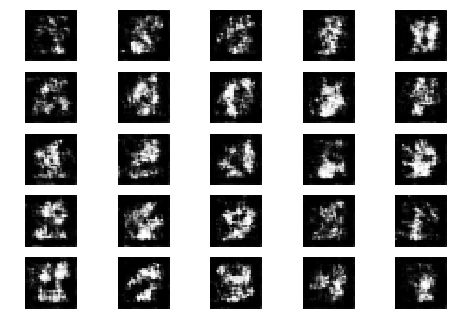

201 [D loss: 0.999978] [G loss: 1.000054]
202 [D loss: 0.999952] [G loss: 1.000064]
203 [D loss: 0.999952] [G loss: 1.000072]
204 [D loss: 0.999966] [G loss: 1.000070]
205 [D loss: 0.999961] [G loss: 1.000055]
206 [D loss: 0.999967] [G loss: 1.000065]
207 [D loss: 0.999971] [G loss: 1.000041]
208 [D loss: 0.999937] [G loss: 1.000094]
209 [D loss: 0.999962] [G loss: 1.000051]
210 [D loss: 0.999957] [G loss: 1.000059]
211 [D loss: 0.999965] [G loss: 1.000054]
212 [D loss: 0.999978] [G loss: 1.000064]
213 [D loss: 0.999988] [G loss: 1.000022]
214 [D loss: 0.999968] [G loss: 1.000090]
215 [D loss: 0.999986] [G loss: 1.000036]
216 [D loss: 0.999950] [G loss: 1.000099]
217 [D loss: 0.999967] [G loss: 1.000093]
218 [D loss: 0.999978] [G loss: 1.000062]
219 [D loss: 0.999973] [G loss: 1.000086]
220 [D loss: 0.999960] [G loss: 1.000066]
221 [D loss: 0.999972] [G loss: 1.000092]
222 [D loss: 0.999961] [G loss: 1.000080]
223 [D loss: 0.999980] [G loss: 1.000076]
224 [D loss: 0.999960] [G loss: 1.

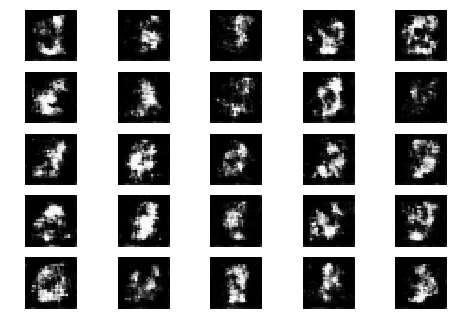

251 [D loss: 0.999961] [G loss: 1.000065]
252 [D loss: 0.999977] [G loss: 1.000081]
253 [D loss: 0.999963] [G loss: 1.000085]
254 [D loss: 0.999969] [G loss: 1.000082]
255 [D loss: 0.999940] [G loss: 1.000071]
256 [D loss: 0.999969] [G loss: 1.000057]
257 [D loss: 0.999965] [G loss: 1.000066]
258 [D loss: 0.999958] [G loss: 1.000087]
259 [D loss: 0.999977] [G loss: 1.000067]
260 [D loss: 0.999954] [G loss: 1.000095]
261 [D loss: 0.999951] [G loss: 1.000089]
262 [D loss: 0.999955] [G loss: 1.000054]
263 [D loss: 0.999976] [G loss: 1.000048]
264 [D loss: 0.999963] [G loss: 1.000079]
265 [D loss: 0.999959] [G loss: 1.000088]
266 [D loss: 0.999948] [G loss: 1.000075]
267 [D loss: 0.999978] [G loss: 1.000063]
268 [D loss: 0.999966] [G loss: 1.000059]
269 [D loss: 0.999963] [G loss: 1.000067]
270 [D loss: 0.999976] [G loss: 1.000084]
271 [D loss: 0.999964] [G loss: 1.000081]
272 [D loss: 0.999944] [G loss: 1.000057]
273 [D loss: 0.999966] [G loss: 1.000048]
274 [D loss: 0.999964] [G loss: 1.

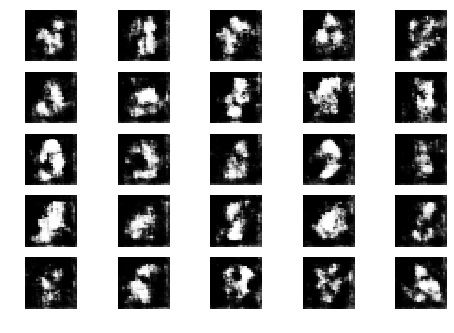

301 [D loss: 0.999958] [G loss: 1.000060]
302 [D loss: 0.999941] [G loss: 1.000056]
303 [D loss: 0.999976] [G loss: 1.000052]
304 [D loss: 0.999963] [G loss: 1.000049]
305 [D loss: 0.999978] [G loss: 1.000061]
306 [D loss: 0.999955] [G loss: 1.000058]
307 [D loss: 0.999968] [G loss: 1.000095]
308 [D loss: 0.999966] [G loss: 1.000083]
309 [D loss: 0.999946] [G loss: 1.000032]
310 [D loss: 0.999979] [G loss: 1.000057]
311 [D loss: 0.999979] [G loss: 1.000066]
312 [D loss: 0.999992] [G loss: 1.000087]
313 [D loss: 0.999968] [G loss: 1.000073]
314 [D loss: 0.999974] [G loss: 1.000062]
315 [D loss: 0.999963] [G loss: 1.000074]
316 [D loss: 0.999978] [G loss: 1.000051]
317 [D loss: 0.999961] [G loss: 1.000055]
318 [D loss: 0.999972] [G loss: 1.000082]
319 [D loss: 0.999973] [G loss: 1.000068]
320 [D loss: 0.999973] [G loss: 1.000033]
321 [D loss: 0.999987] [G loss: 1.000051]
322 [D loss: 0.999980] [G loss: 1.000082]
323 [D loss: 0.999972] [G loss: 1.000055]
324 [D loss: 0.999968] [G loss: 1.

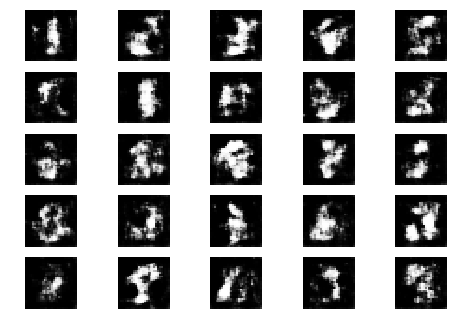

351 [D loss: 0.999960] [G loss: 1.000088]
352 [D loss: 0.999971] [G loss: 1.000065]
353 [D loss: 0.999964] [G loss: 1.000046]
354 [D loss: 0.999961] [G loss: 1.000040]
355 [D loss: 0.999974] [G loss: 1.000055]
356 [D loss: 0.999964] [G loss: 1.000071]
357 [D loss: 0.999980] [G loss: 1.000063]
358 [D loss: 0.999955] [G loss: 1.000095]
359 [D loss: 0.999976] [G loss: 1.000048]
360 [D loss: 0.999970] [G loss: 1.000080]
361 [D loss: 0.999970] [G loss: 1.000042]
362 [D loss: 0.999983] [G loss: 1.000065]
363 [D loss: 0.999974] [G loss: 1.000070]
364 [D loss: 0.999987] [G loss: 1.000060]
365 [D loss: 0.999952] [G loss: 1.000073]
366 [D loss: 0.999980] [G loss: 1.000044]
367 [D loss: 0.999977] [G loss: 1.000023]
368 [D loss: 0.999952] [G loss: 1.000042]
369 [D loss: 0.999971] [G loss: 1.000095]
370 [D loss: 0.999961] [G loss: 1.000065]
371 [D loss: 0.999964] [G loss: 1.000065]
372 [D loss: 0.999986] [G loss: 1.000041]
373 [D loss: 0.999950] [G loss: 1.000054]
374 [D loss: 0.999946] [G loss: 1.

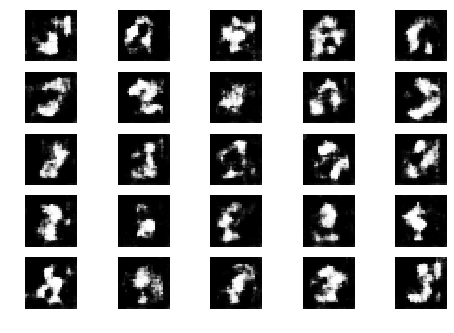

401 [D loss: 0.999971] [G loss: 1.000071]
402 [D loss: 0.999970] [G loss: 1.000068]
403 [D loss: 0.999980] [G loss: 1.000073]
404 [D loss: 0.999969] [G loss: 1.000048]
405 [D loss: 0.999952] [G loss: 1.000056]
406 [D loss: 0.999951] [G loss: 1.000049]
407 [D loss: 0.999979] [G loss: 1.000044]
408 [D loss: 0.999961] [G loss: 1.000044]
409 [D loss: 0.999967] [G loss: 1.000065]
410 [D loss: 0.999968] [G loss: 1.000077]
411 [D loss: 0.999979] [G loss: 1.000063]
412 [D loss: 0.999980] [G loss: 1.000051]
413 [D loss: 0.999966] [G loss: 1.000066]
414 [D loss: 0.999973] [G loss: 1.000061]
415 [D loss: 0.999970] [G loss: 1.000073]
416 [D loss: 0.999959] [G loss: 1.000060]
417 [D loss: 0.999972] [G loss: 1.000057]
418 [D loss: 0.999977] [G loss: 1.000069]
419 [D loss: 0.999963] [G loss: 1.000084]
420 [D loss: 0.999970] [G loss: 1.000055]
421 [D loss: 0.999965] [G loss: 1.000046]
422 [D loss: 0.999973] [G loss: 1.000056]
423 [D loss: 0.999974] [G loss: 1.000052]
424 [D loss: 0.999986] [G loss: 1.

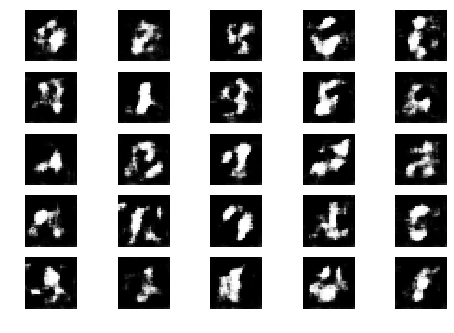

451 [D loss: 0.999967] [G loss: 1.000034]
452 [D loss: 0.999961] [G loss: 1.000070]
453 [D loss: 0.999955] [G loss: 1.000088]
454 [D loss: 0.999981] [G loss: 1.000041]
455 [D loss: 0.999974] [G loss: 1.000066]
456 [D loss: 0.999959] [G loss: 1.000044]
457 [D loss: 0.999963] [G loss: 1.000047]
458 [D loss: 0.999970] [G loss: 1.000058]
459 [D loss: 0.999980] [G loss: 1.000062]
460 [D loss: 0.999974] [G loss: 1.000059]
461 [D loss: 0.999967] [G loss: 1.000104]
462 [D loss: 0.999979] [G loss: 1.000053]
463 [D loss: 0.999976] [G loss: 1.000052]
464 [D loss: 0.999967] [G loss: 1.000061]
465 [D loss: 0.999961] [G loss: 1.000063]
466 [D loss: 0.999977] [G loss: 1.000054]
467 [D loss: 0.999975] [G loss: 1.000068]
468 [D loss: 0.999978] [G loss: 1.000054]
469 [D loss: 0.999977] [G loss: 1.000088]
470 [D loss: 0.999969] [G loss: 1.000060]
471 [D loss: 0.999983] [G loss: 1.000063]
472 [D loss: 0.999969] [G loss: 1.000061]
473 [D loss: 0.999967] [G loss: 1.000062]
474 [D loss: 0.999961] [G loss: 1.

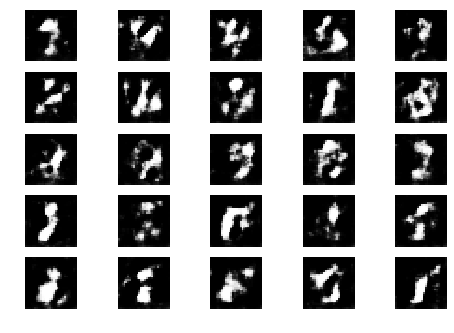

501 [D loss: 0.999942] [G loss: 1.000074]
502 [D loss: 0.999972] [G loss: 1.000062]
503 [D loss: 0.999969] [G loss: 1.000074]
504 [D loss: 0.999970] [G loss: 1.000052]
505 [D loss: 0.999966] [G loss: 1.000035]
506 [D loss: 0.999976] [G loss: 1.000071]
507 [D loss: 0.999979] [G loss: 1.000037]
508 [D loss: 0.999932] [G loss: 1.000048]
509 [D loss: 0.999969] [G loss: 1.000096]
510 [D loss: 0.999960] [G loss: 1.000068]
511 [D loss: 0.999968] [G loss: 1.000074]
512 [D loss: 0.999974] [G loss: 1.000064]
513 [D loss: 0.999960] [G loss: 1.000066]
514 [D loss: 0.999954] [G loss: 1.000093]
515 [D loss: 0.999960] [G loss: 1.000069]
516 [D loss: 0.999957] [G loss: 1.000047]
517 [D loss: 0.999977] [G loss: 1.000085]
518 [D loss: 0.999962] [G loss: 1.000040]
519 [D loss: 0.999956] [G loss: 1.000054]
520 [D loss: 0.999966] [G loss: 1.000035]
521 [D loss: 0.999968] [G loss: 1.000056]
522 [D loss: 0.999973] [G loss: 1.000056]
523 [D loss: 0.999954] [G loss: 1.000065]
524 [D loss: 0.999943] [G loss: 1.

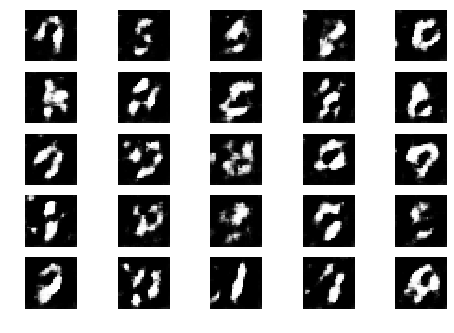

551 [D loss: 0.999984] [G loss: 1.000046]
552 [D loss: 0.999989] [G loss: 1.000075]
553 [D loss: 0.999962] [G loss: 1.000061]
554 [D loss: 0.999962] [G loss: 1.000060]
555 [D loss: 0.999973] [G loss: 1.000056]
556 [D loss: 0.999960] [G loss: 1.000057]
557 [D loss: 0.999950] [G loss: 1.000031]
558 [D loss: 0.999973] [G loss: 1.000049]
559 [D loss: 0.999957] [G loss: 1.000074]
560 [D loss: 0.999982] [G loss: 1.000067]
561 [D loss: 0.999959] [G loss: 1.000062]
562 [D loss: 0.999970] [G loss: 1.000061]
563 [D loss: 0.999966] [G loss: 1.000072]
564 [D loss: 0.999979] [G loss: 1.000070]
565 [D loss: 0.999975] [G loss: 1.000089]
566 [D loss: 0.999976] [G loss: 1.000031]
567 [D loss: 0.999958] [G loss: 1.000075]
568 [D loss: 0.999940] [G loss: 1.000052]
569 [D loss: 0.999958] [G loss: 1.000051]
570 [D loss: 0.999963] [G loss: 1.000075]
571 [D loss: 0.999963] [G loss: 1.000059]
572 [D loss: 0.999976] [G loss: 1.000079]
573 [D loss: 0.999981] [G loss: 1.000058]
574 [D loss: 0.999970] [G loss: 1.

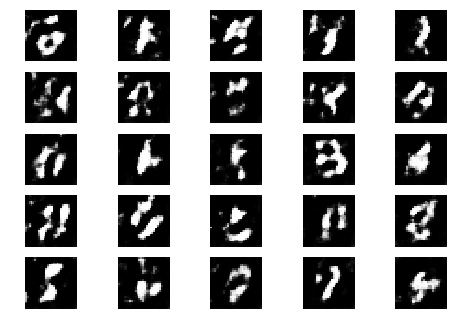

601 [D loss: 0.999965] [G loss: 1.000075]
602 [D loss: 0.999961] [G loss: 1.000065]
603 [D loss: 0.999954] [G loss: 1.000040]
604 [D loss: 0.999951] [G loss: 1.000082]
605 [D loss: 0.999945] [G loss: 1.000081]
606 [D loss: 0.999957] [G loss: 1.000046]
607 [D loss: 0.999971] [G loss: 1.000076]
608 [D loss: 0.999970] [G loss: 1.000066]
609 [D loss: 0.999949] [G loss: 1.000089]
610 [D loss: 0.999970] [G loss: 1.000042]
611 [D loss: 0.999960] [G loss: 1.000042]
612 [D loss: 0.999960] [G loss: 1.000044]
613 [D loss: 0.999968] [G loss: 1.000066]
614 [D loss: 0.999963] [G loss: 1.000097]
615 [D loss: 0.999968] [G loss: 1.000080]
616 [D loss: 0.999969] [G loss: 1.000051]
617 [D loss: 0.999984] [G loss: 1.000040]
618 [D loss: 0.999975] [G loss: 1.000050]
619 [D loss: 0.999977] [G loss: 1.000044]
620 [D loss: 0.999978] [G loss: 1.000082]
621 [D loss: 0.999986] [G loss: 1.000075]
622 [D loss: 0.999957] [G loss: 1.000048]
623 [D loss: 0.999945] [G loss: 1.000066]
624 [D loss: 0.999979] [G loss: 1.

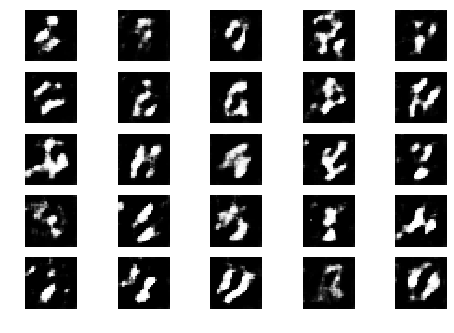

651 [D loss: 0.999973] [G loss: 1.000043]
652 [D loss: 0.999958] [G loss: 1.000080]
653 [D loss: 0.999951] [G loss: 1.000071]
654 [D loss: 0.999965] [G loss: 1.000051]
655 [D loss: 0.999979] [G loss: 1.000041]
656 [D loss: 0.999963] [G loss: 1.000042]
657 [D loss: 0.999955] [G loss: 1.000064]
658 [D loss: 0.999963] [G loss: 1.000068]
659 [D loss: 0.999969] [G loss: 1.000049]
660 [D loss: 0.999967] [G loss: 1.000035]
661 [D loss: 0.999966] [G loss: 1.000015]
662 [D loss: 0.999954] [G loss: 1.000068]
663 [D loss: 0.999973] [G loss: 1.000057]
664 [D loss: 0.999980] [G loss: 1.000036]
665 [D loss: 0.999997] [G loss: 1.000019]
666 [D loss: 0.999967] [G loss: 1.000046]
667 [D loss: 0.999955] [G loss: 1.000062]
668 [D loss: 0.999956] [G loss: 1.000032]
669 [D loss: 0.999936] [G loss: 1.000095]
670 [D loss: 0.999953] [G loss: 1.000075]
671 [D loss: 0.999968] [G loss: 1.000065]
672 [D loss: 0.999957] [G loss: 1.000055]
673 [D loss: 0.999966] [G loss: 1.000081]
674 [D loss: 0.999951] [G loss: 1.

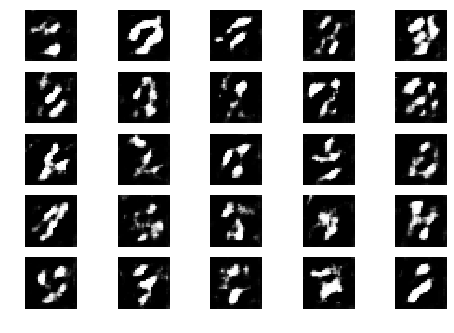

701 [D loss: 0.999982] [G loss: 1.000053]
702 [D loss: 0.999960] [G loss: 1.000059]
703 [D loss: 0.999961] [G loss: 1.000067]
704 [D loss: 0.999969] [G loss: 1.000059]
705 [D loss: 0.999961] [G loss: 1.000066]
706 [D loss: 0.999967] [G loss: 1.000069]
707 [D loss: 0.999974] [G loss: 1.000062]
708 [D loss: 0.999989] [G loss: 1.000076]
709 [D loss: 0.999969] [G loss: 1.000052]
710 [D loss: 0.999960] [G loss: 1.000094]
711 [D loss: 0.999974] [G loss: 1.000067]
712 [D loss: 0.999984] [G loss: 1.000059]
713 [D loss: 0.999968] [G loss: 1.000075]
714 [D loss: 0.999965] [G loss: 1.000073]
715 [D loss: 0.999948] [G loss: 1.000085]
716 [D loss: 0.999967] [G loss: 1.000052]
717 [D loss: 0.999963] [G loss: 1.000068]
718 [D loss: 0.999965] [G loss: 1.000080]
719 [D loss: 0.999963] [G loss: 1.000059]
720 [D loss: 0.999971] [G loss: 1.000068]
721 [D loss: 0.999962] [G loss: 1.000091]
722 [D loss: 0.999973] [G loss: 1.000069]
723 [D loss: 0.999961] [G loss: 1.000048]
724 [D loss: 0.999951] [G loss: 1.

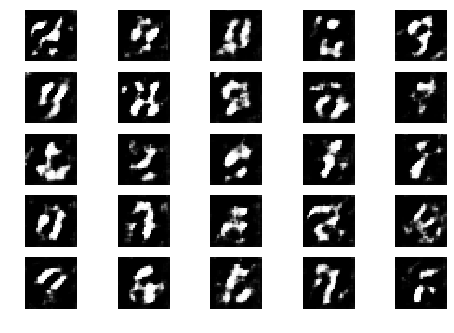

751 [D loss: 0.999973] [G loss: 1.000110]
752 [D loss: 0.999980] [G loss: 1.000060]
753 [D loss: 0.999963] [G loss: 1.000033]
754 [D loss: 0.999985] [G loss: 1.000058]
755 [D loss: 0.999969] [G loss: 1.000039]
756 [D loss: 0.999976] [G loss: 1.000064]
757 [D loss: 0.999968] [G loss: 1.000043]
758 [D loss: 0.999965] [G loss: 1.000055]
759 [D loss: 0.999971] [G loss: 1.000046]
760 [D loss: 0.999972] [G loss: 1.000100]
761 [D loss: 0.999971] [G loss: 1.000061]
762 [D loss: 0.999972] [G loss: 1.000080]
763 [D loss: 0.999967] [G loss: 1.000045]
764 [D loss: 0.999974] [G loss: 1.000054]
765 [D loss: 0.999989] [G loss: 1.000053]
766 [D loss: 0.999952] [G loss: 1.000042]
767 [D loss: 0.999987] [G loss: 1.000045]
768 [D loss: 0.999964] [G loss: 1.000080]
769 [D loss: 0.999978] [G loss: 1.000056]
770 [D loss: 0.999972] [G loss: 1.000060]
771 [D loss: 0.999962] [G loss: 1.000069]
772 [D loss: 0.999964] [G loss: 1.000048]
773 [D loss: 0.999967] [G loss: 1.000061]
774 [D loss: 0.999956] [G loss: 1.

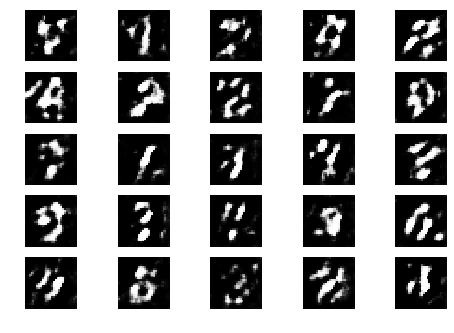

801 [D loss: 0.999973] [G loss: 1.000060]
802 [D loss: 0.999965] [G loss: 1.000049]
803 [D loss: 0.999967] [G loss: 1.000074]
804 [D loss: 0.999978] [G loss: 1.000059]
805 [D loss: 0.999969] [G loss: 1.000042]
806 [D loss: 0.999980] [G loss: 1.000066]
807 [D loss: 0.999969] [G loss: 1.000070]
808 [D loss: 0.999963] [G loss: 1.000053]
809 [D loss: 0.999976] [G loss: 1.000084]
810 [D loss: 0.999972] [G loss: 1.000051]
811 [D loss: 0.999948] [G loss: 1.000064]
812 [D loss: 0.999954] [G loss: 1.000069]
813 [D loss: 0.999981] [G loss: 1.000061]
814 [D loss: 0.999960] [G loss: 1.000039]
815 [D loss: 0.999966] [G loss: 1.000031]
816 [D loss: 0.999959] [G loss: 1.000027]
817 [D loss: 0.999956] [G loss: 1.000058]
818 [D loss: 0.999954] [G loss: 1.000054]
819 [D loss: 0.999954] [G loss: 1.000059]
820 [D loss: 0.999990] [G loss: 1.000043]
821 [D loss: 0.999972] [G loss: 1.000080]
822 [D loss: 0.999961] [G loss: 1.000072]
823 [D loss: 0.999971] [G loss: 1.000069]
824 [D loss: 0.999972] [G loss: 1.

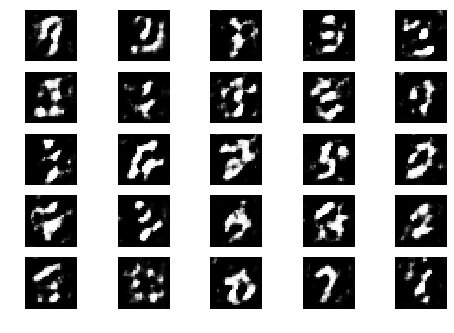

851 [D loss: 0.999968] [G loss: 1.000084]
852 [D loss: 0.999983] [G loss: 1.000083]
853 [D loss: 0.999968] [G loss: 1.000048]
854 [D loss: 0.999944] [G loss: 1.000037]
855 [D loss: 0.999960] [G loss: 1.000065]
856 [D loss: 0.999987] [G loss: 1.000029]
857 [D loss: 0.999976] [G loss: 1.000049]
858 [D loss: 0.999966] [G loss: 1.000059]
859 [D loss: 0.999959] [G loss: 1.000064]
860 [D loss: 0.999963] [G loss: 1.000057]
861 [D loss: 0.999970] [G loss: 1.000064]
862 [D loss: 0.999983] [G loss: 1.000041]
863 [D loss: 0.999969] [G loss: 1.000045]
864 [D loss: 0.999955] [G loss: 1.000091]
865 [D loss: 0.999950] [G loss: 1.000068]
866 [D loss: 0.999954] [G loss: 1.000052]
867 [D loss: 0.999943] [G loss: 1.000048]
868 [D loss: 0.999964] [G loss: 1.000044]
869 [D loss: 0.999986] [G loss: 1.000069]
870 [D loss: 0.999992] [G loss: 1.000062]
871 [D loss: 0.999957] [G loss: 1.000082]
872 [D loss: 0.999956] [G loss: 1.000068]
873 [D loss: 0.999969] [G loss: 1.000075]
874 [D loss: 0.999978] [G loss: 1.

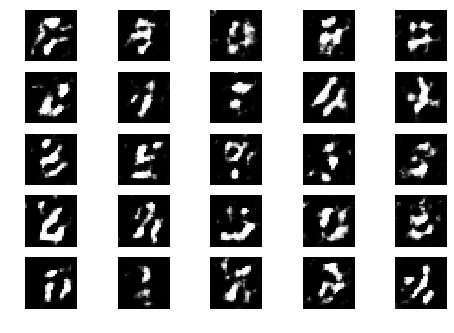

901 [D loss: 0.999972] [G loss: 1.000067]
902 [D loss: 0.999972] [G loss: 1.000026]
903 [D loss: 0.999970] [G loss: 1.000026]
904 [D loss: 0.999972] [G loss: 1.000062]
905 [D loss: 0.999983] [G loss: 1.000055]
906 [D loss: 0.999965] [G loss: 1.000060]
907 [D loss: 0.999957] [G loss: 1.000052]
908 [D loss: 0.999960] [G loss: 1.000055]
909 [D loss: 0.999976] [G loss: 1.000073]
910 [D loss: 0.999950] [G loss: 1.000073]
911 [D loss: 0.999971] [G loss: 1.000078]
912 [D loss: 0.999952] [G loss: 1.000059]
913 [D loss: 0.999960] [G loss: 1.000054]
914 [D loss: 0.999962] [G loss: 1.000075]
915 [D loss: 0.999970] [G loss: 1.000026]
916 [D loss: 0.999960] [G loss: 1.000055]
917 [D loss: 0.999963] [G loss: 1.000012]
918 [D loss: 0.999966] [G loss: 1.000058]
919 [D loss: 0.999986] [G loss: 1.000056]
920 [D loss: 0.999940] [G loss: 1.000065]
921 [D loss: 0.999956] [G loss: 1.000102]
922 [D loss: 0.999975] [G loss: 1.000043]
923 [D loss: 0.999962] [G loss: 1.000082]
924 [D loss: 0.999985] [G loss: 1.

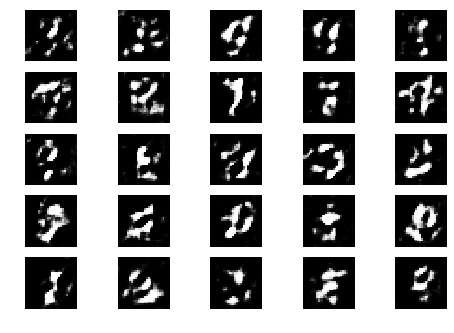

951 [D loss: 0.999988] [G loss: 1.000063]
952 [D loss: 0.999961] [G loss: 1.000046]
953 [D loss: 0.999974] [G loss: 1.000067]
954 [D loss: 0.999955] [G loss: 1.000054]
955 [D loss: 0.999957] [G loss: 1.000055]
956 [D loss: 0.999942] [G loss: 1.000054]
957 [D loss: 0.999976] [G loss: 1.000066]
958 [D loss: 0.999956] [G loss: 1.000051]
959 [D loss: 0.999955] [G loss: 1.000081]
960 [D loss: 0.999984] [G loss: 1.000041]
961 [D loss: 0.999960] [G loss: 1.000067]
962 [D loss: 0.999953] [G loss: 1.000054]
963 [D loss: 0.999963] [G loss: 1.000066]
964 [D loss: 0.999990] [G loss: 1.000047]
965 [D loss: 0.999971] [G loss: 1.000050]
966 [D loss: 0.999961] [G loss: 1.000077]
967 [D loss: 0.999960] [G loss: 1.000052]
968 [D loss: 0.999954] [G loss: 1.000070]
969 [D loss: 0.999958] [G loss: 1.000064]
970 [D loss: 0.999990] [G loss: 1.000046]
971 [D loss: 0.999973] [G loss: 1.000071]
972 [D loss: 0.999999] [G loss: 1.000049]
973 [D loss: 0.999958] [G loss: 1.000043]
974 [D loss: 0.999974] [G loss: 1.

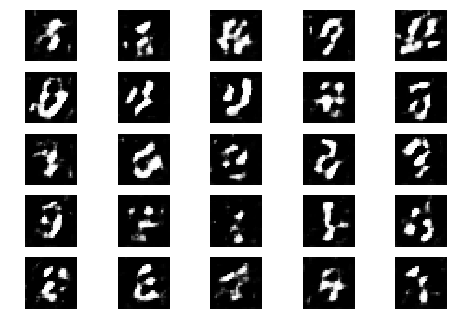

1001 [D loss: 0.999968] [G loss: 1.000049]
1002 [D loss: 0.999948] [G loss: 1.000096]
1003 [D loss: 0.999952] [G loss: 1.000046]
1004 [D loss: 0.999956] [G loss: 1.000022]
1005 [D loss: 0.999970] [G loss: 1.000078]
1006 [D loss: 0.999987] [G loss: 1.000046]
1007 [D loss: 0.999942] [G loss: 1.000038]
1008 [D loss: 0.999993] [G loss: 1.000059]
1009 [D loss: 0.999946] [G loss: 1.000073]
1010 [D loss: 0.999973] [G loss: 1.000048]
1011 [D loss: 0.999977] [G loss: 1.000068]
1012 [D loss: 0.999966] [G loss: 1.000064]
1013 [D loss: 0.999961] [G loss: 1.000081]
1014 [D loss: 0.999977] [G loss: 1.000061]
1015 [D loss: 0.999981] [G loss: 1.000068]
1016 [D loss: 0.999980] [G loss: 1.000009]
1017 [D loss: 0.999958] [G loss: 1.000065]
1018 [D loss: 0.999976] [G loss: 1.000039]
1019 [D loss: 0.999963] [G loss: 1.000075]
1020 [D loss: 0.999971] [G loss: 1.000070]
1021 [D loss: 0.999957] [G loss: 1.000055]
1022 [D loss: 0.999965] [G loss: 1.000074]
1023 [D loss: 0.999953] [G loss: 1.000061]
1024 [D los

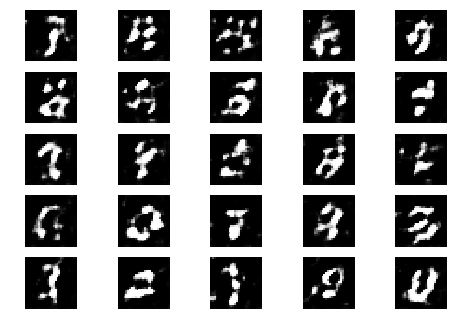

1051 [D loss: 0.999968] [G loss: 1.000086]
1052 [D loss: 0.999989] [G loss: 1.000065]
1053 [D loss: 0.999975] [G loss: 1.000088]
1054 [D loss: 0.999978] [G loss: 1.000055]
1055 [D loss: 0.999955] [G loss: 1.000053]
1056 [D loss: 0.999968] [G loss: 1.000061]
1057 [D loss: 0.999965] [G loss: 1.000078]
1058 [D loss: 0.999956] [G loss: 1.000055]
1059 [D loss: 0.999968] [G loss: 1.000052]
1060 [D loss: 0.999967] [G loss: 1.000061]
1061 [D loss: 0.999969] [G loss: 1.000068]
1062 [D loss: 0.999963] [G loss: 1.000043]
1063 [D loss: 0.999963] [G loss: 1.000054]
1064 [D loss: 0.999966] [G loss: 1.000061]
1065 [D loss: 0.999971] [G loss: 1.000040]
1066 [D loss: 0.999977] [G loss: 1.000063]
1067 [D loss: 0.999962] [G loss: 1.000066]
1068 [D loss: 0.999971] [G loss: 1.000064]
1069 [D loss: 0.999976] [G loss: 1.000039]
1070 [D loss: 0.999941] [G loss: 1.000060]
1071 [D loss: 0.999965] [G loss: 1.000078]
1072 [D loss: 0.999975] [G loss: 1.000054]
1073 [D loss: 0.999965] [G loss: 1.000063]
1074 [D los

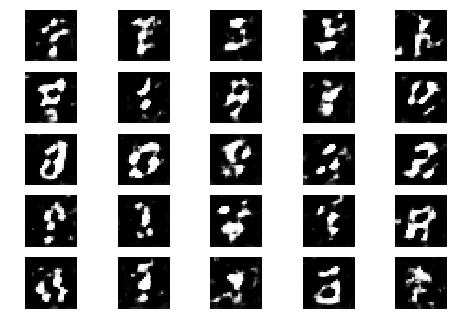

1101 [D loss: 0.999960] [G loss: 1.000077]
1102 [D loss: 0.999976] [G loss: 1.000049]
1103 [D loss: 0.999964] [G loss: 1.000039]
1104 [D loss: 0.999986] [G loss: 1.000053]
1105 [D loss: 0.999945] [G loss: 1.000076]
1106 [D loss: 0.999990] [G loss: 1.000039]
1107 [D loss: 0.999961] [G loss: 1.000054]
1108 [D loss: 0.999966] [G loss: 1.000053]
1109 [D loss: 0.999981] [G loss: 1.000089]
1110 [D loss: 0.999985] [G loss: 1.000048]
1111 [D loss: 0.999961] [G loss: 1.000050]
1112 [D loss: 0.999954] [G loss: 1.000057]
1113 [D loss: 0.999967] [G loss: 1.000074]
1114 [D loss: 0.999980] [G loss: 1.000039]
1115 [D loss: 0.999979] [G loss: 1.000092]
1116 [D loss: 0.999979] [G loss: 1.000045]
1117 [D loss: 0.999973] [G loss: 1.000061]
1118 [D loss: 0.999974] [G loss: 1.000027]
1119 [D loss: 0.999965] [G loss: 1.000040]
1120 [D loss: 0.999951] [G loss: 1.000025]
1121 [D loss: 0.999967] [G loss: 1.000034]
1122 [D loss: 0.999957] [G loss: 1.000072]
1123 [D loss: 0.999960] [G loss: 1.000052]
1124 [D los

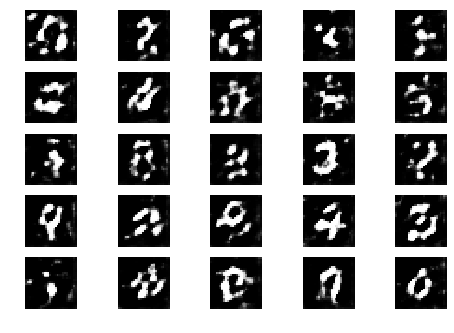

1151 [D loss: 0.999971] [G loss: 1.000065]
1152 [D loss: 0.999964] [G loss: 1.000061]
1153 [D loss: 0.999966] [G loss: 1.000074]
1154 [D loss: 0.999970] [G loss: 1.000080]
1155 [D loss: 0.999967] [G loss: 1.000066]
1156 [D loss: 0.999982] [G loss: 1.000069]
1157 [D loss: 0.999962] [G loss: 1.000038]
1158 [D loss: 0.999977] [G loss: 1.000077]
1159 [D loss: 0.999972] [G loss: 1.000066]
1160 [D loss: 0.999959] [G loss: 1.000041]
1161 [D loss: 0.999977] [G loss: 1.000066]
1162 [D loss: 0.999970] [G loss: 1.000057]
1163 [D loss: 0.999970] [G loss: 1.000085]
1164 [D loss: 0.999963] [G loss: 1.000058]
1165 [D loss: 0.999961] [G loss: 1.000057]
1166 [D loss: 0.999970] [G loss: 1.000054]
1167 [D loss: 0.999972] [G loss: 1.000054]
1168 [D loss: 0.999959] [G loss: 1.000064]
1169 [D loss: 0.999974] [G loss: 1.000077]
1170 [D loss: 0.999956] [G loss: 1.000083]
1171 [D loss: 0.999969] [G loss: 1.000027]
1172 [D loss: 0.999972] [G loss: 1.000059]
1173 [D loss: 0.999960] [G loss: 1.000084]
1174 [D los

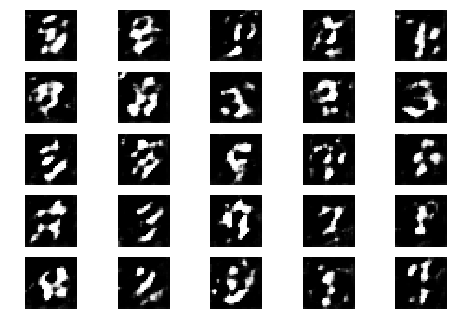

1201 [D loss: 0.999986] [G loss: 1.000046]
1202 [D loss: 0.999992] [G loss: 1.000070]
1203 [D loss: 0.999971] [G loss: 1.000042]
1204 [D loss: 0.999968] [G loss: 1.000067]
1205 [D loss: 0.999979] [G loss: 1.000069]
1206 [D loss: 0.999961] [G loss: 1.000060]
1207 [D loss: 0.999977] [G loss: 1.000058]
1208 [D loss: 0.999959] [G loss: 1.000050]
1209 [D loss: 0.999973] [G loss: 1.000040]
1210 [D loss: 0.999964] [G loss: 1.000069]
1211 [D loss: 0.999963] [G loss: 1.000062]
1212 [D loss: 0.999992] [G loss: 1.000084]
1213 [D loss: 0.999957] [G loss: 1.000056]
1214 [D loss: 0.999954] [G loss: 1.000043]
1215 [D loss: 0.999966] [G loss: 1.000067]
1216 [D loss: 0.999966] [G loss: 1.000059]
1217 [D loss: 0.999966] [G loss: 1.000069]
1218 [D loss: 0.999960] [G loss: 1.000045]
1219 [D loss: 0.999976] [G loss: 1.000061]
1220 [D loss: 0.999958] [G loss: 1.000072]
1221 [D loss: 0.999951] [G loss: 1.000052]
1222 [D loss: 0.999966] [G loss: 1.000070]
1223 [D loss: 0.999951] [G loss: 1.000063]
1224 [D los

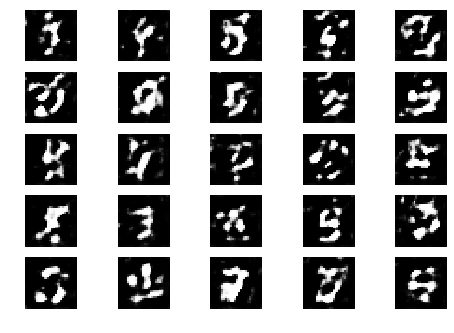

1251 [D loss: 0.999967] [G loss: 1.000037]
1252 [D loss: 0.999959] [G loss: 1.000058]
1253 [D loss: 0.999973] [G loss: 1.000055]
1254 [D loss: 0.999964] [G loss: 1.000029]
1255 [D loss: 0.999957] [G loss: 1.000062]
1256 [D loss: 0.999967] [G loss: 1.000074]
1257 [D loss: 0.999974] [G loss: 1.000089]
1258 [D loss: 0.999969] [G loss: 1.000085]
1259 [D loss: 0.999969] [G loss: 1.000071]
1260 [D loss: 0.999961] [G loss: 1.000076]
1261 [D loss: 0.999981] [G loss: 1.000039]
1262 [D loss: 0.999975] [G loss: 1.000063]
1263 [D loss: 0.999964] [G loss: 1.000072]
1264 [D loss: 0.999975] [G loss: 1.000047]
1265 [D loss: 0.999959] [G loss: 1.000072]
1266 [D loss: 0.999954] [G loss: 1.000054]
1267 [D loss: 0.999977] [G loss: 1.000063]
1268 [D loss: 0.999972] [G loss: 1.000063]
1269 [D loss: 0.999974] [G loss: 1.000046]
1270 [D loss: 0.999962] [G loss: 1.000055]
1271 [D loss: 0.999968] [G loss: 1.000058]
1272 [D loss: 0.999977] [G loss: 1.000045]
1273 [D loss: 0.999963] [G loss: 1.000057]
1274 [D los

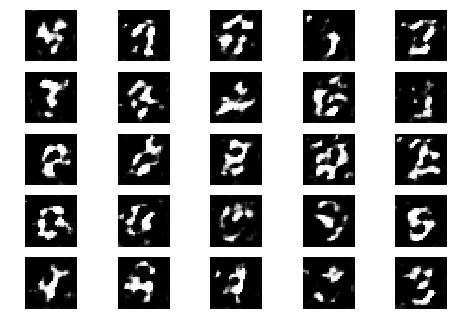

1301 [D loss: 0.999969] [G loss: 1.000066]
1302 [D loss: 0.999979] [G loss: 1.000050]
1303 [D loss: 0.999969] [G loss: 1.000051]
1304 [D loss: 0.999960] [G loss: 1.000066]
1305 [D loss: 0.999954] [G loss: 1.000064]
1306 [D loss: 0.999971] [G loss: 1.000086]
1307 [D loss: 0.999978] [G loss: 1.000063]
1308 [D loss: 0.999966] [G loss: 1.000063]
1309 [D loss: 0.999960] [G loss: 1.000052]
1310 [D loss: 0.999941] [G loss: 1.000067]
1311 [D loss: 0.999975] [G loss: 1.000054]
1312 [D loss: 0.999963] [G loss: 1.000067]
1313 [D loss: 0.999966] [G loss: 1.000053]
1314 [D loss: 0.999951] [G loss: 1.000069]
1315 [D loss: 0.999966] [G loss: 1.000059]
1316 [D loss: 0.999960] [G loss: 1.000052]
1317 [D loss: 0.999979] [G loss: 1.000072]
1318 [D loss: 0.999956] [G loss: 1.000060]
1319 [D loss: 0.999988] [G loss: 1.000067]
1320 [D loss: 0.999968] [G loss: 1.000059]
1321 [D loss: 0.999961] [G loss: 1.000073]
1322 [D loss: 0.999949] [G loss: 1.000058]
1323 [D loss: 0.999962] [G loss: 1.000073]
1324 [D los

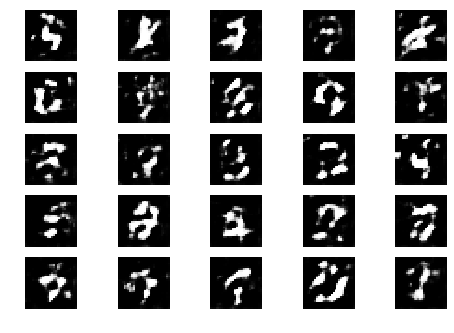

1351 [D loss: 0.999948] [G loss: 1.000040]
1352 [D loss: 0.999967] [G loss: 1.000048]
1353 [D loss: 0.999973] [G loss: 1.000101]
1354 [D loss: 0.999989] [G loss: 1.000071]
1355 [D loss: 0.999989] [G loss: 1.000016]
1356 [D loss: 0.999954] [G loss: 1.000091]
1357 [D loss: 0.999981] [G loss: 1.000053]
1358 [D loss: 0.999973] [G loss: 1.000046]
1359 [D loss: 0.999954] [G loss: 1.000065]
1360 [D loss: 0.999954] [G loss: 1.000061]
1361 [D loss: 0.999987] [G loss: 1.000034]
1362 [D loss: 0.999962] [G loss: 1.000075]
1363 [D loss: 0.999950] [G loss: 1.000049]
1364 [D loss: 0.999987] [G loss: 1.000065]
1365 [D loss: 0.999960] [G loss: 1.000032]
1366 [D loss: 0.999975] [G loss: 1.000068]
1367 [D loss: 1.000004] [G loss: 1.000108]
1368 [D loss: 0.999947] [G loss: 1.000059]
1369 [D loss: 0.999946] [G loss: 1.000043]
1370 [D loss: 0.999971] [G loss: 1.000082]
1371 [D loss: 0.999957] [G loss: 1.000032]
1372 [D loss: 0.999972] [G loss: 1.000055]
1373 [D loss: 0.999954] [G loss: 1.000031]
1374 [D los

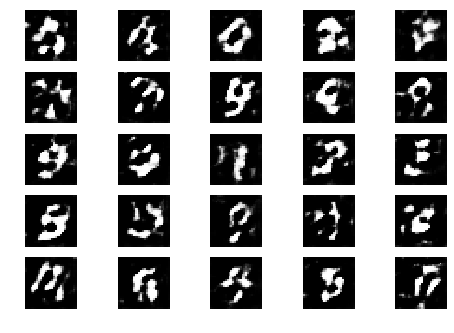

1401 [D loss: 0.999978] [G loss: 1.000041]
1402 [D loss: 0.999957] [G loss: 1.000063]
1403 [D loss: 0.999947] [G loss: 1.000051]
1404 [D loss: 0.999954] [G loss: 1.000055]
1405 [D loss: 0.999976] [G loss: 1.000053]
1406 [D loss: 0.999973] [G loss: 1.000074]
1407 [D loss: 0.999970] [G loss: 1.000081]
1408 [D loss: 0.999945] [G loss: 1.000065]
1409 [D loss: 0.999965] [G loss: 1.000058]
1410 [D loss: 0.999950] [G loss: 1.000077]
1411 [D loss: 0.999974] [G loss: 1.000055]
1412 [D loss: 0.999983] [G loss: 1.000049]
1413 [D loss: 0.999971] [G loss: 1.000046]
1414 [D loss: 0.999977] [G loss: 1.000054]
1415 [D loss: 0.999969] [G loss: 1.000053]
1416 [D loss: 0.999977] [G loss: 1.000055]
1417 [D loss: 0.999956] [G loss: 1.000070]
1418 [D loss: 0.999968] [G loss: 1.000039]
1419 [D loss: 0.999974] [G loss: 1.000047]
1420 [D loss: 0.999984] [G loss: 1.000060]
1421 [D loss: 0.999963] [G loss: 1.000059]
1422 [D loss: 0.999964] [G loss: 1.000055]
1423 [D loss: 0.999974] [G loss: 1.000039]
1424 [D los

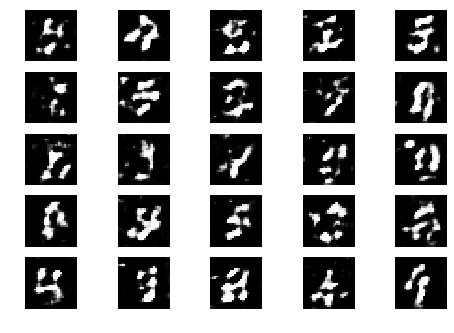

1451 [D loss: 0.999973] [G loss: 1.000048]
1452 [D loss: 0.999971] [G loss: 1.000043]
1453 [D loss: 0.999973] [G loss: 1.000070]
1454 [D loss: 0.999943] [G loss: 1.000061]
1455 [D loss: 0.999968] [G loss: 1.000060]
1456 [D loss: 0.999963] [G loss: 1.000065]
1457 [D loss: 0.999977] [G loss: 1.000046]
1458 [D loss: 0.999965] [G loss: 1.000056]
1459 [D loss: 0.999962] [G loss: 1.000083]
1460 [D loss: 0.999978] [G loss: 1.000064]
1461 [D loss: 0.999965] [G loss: 1.000089]
1462 [D loss: 0.999964] [G loss: 1.000057]
1463 [D loss: 0.999975] [G loss: 1.000077]
1464 [D loss: 0.999956] [G loss: 1.000060]
1465 [D loss: 0.999969] [G loss: 1.000032]
1466 [D loss: 0.999977] [G loss: 1.000059]
1467 [D loss: 0.999978] [G loss: 1.000049]
1468 [D loss: 0.999963] [G loss: 1.000067]
1469 [D loss: 0.999949] [G loss: 1.000063]
1470 [D loss: 0.999975] [G loss: 1.000059]
1471 [D loss: 0.999980] [G loss: 1.000051]
1472 [D loss: 0.999962] [G loss: 1.000056]
1473 [D loss: 0.999958] [G loss: 1.000053]
1474 [D los

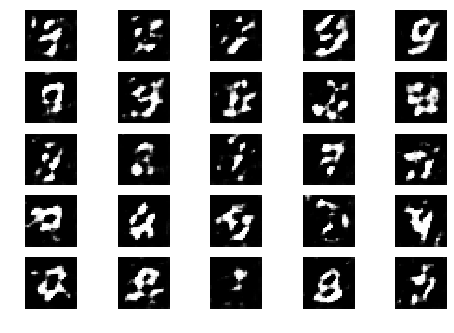

1501 [D loss: 0.999974] [G loss: 1.000074]
1502 [D loss: 0.999960] [G loss: 1.000074]
1503 [D loss: 0.999963] [G loss: 1.000066]
1504 [D loss: 0.999966] [G loss: 1.000053]
1505 [D loss: 0.999962] [G loss: 1.000068]
1506 [D loss: 0.999980] [G loss: 1.000059]
1507 [D loss: 0.999959] [G loss: 1.000062]
1508 [D loss: 0.999966] [G loss: 1.000059]
1509 [D loss: 0.999959] [G loss: 1.000079]
1510 [D loss: 0.999962] [G loss: 1.000034]
1511 [D loss: 0.999978] [G loss: 1.000050]
1512 [D loss: 0.999972] [G loss: 1.000065]
1513 [D loss: 0.999959] [G loss: 1.000047]
1514 [D loss: 0.999993] [G loss: 1.000052]
1515 [D loss: 0.999974] [G loss: 1.000056]
1516 [D loss: 0.999971] [G loss: 1.000045]
1517 [D loss: 0.999958] [G loss: 1.000022]
1518 [D loss: 0.999968] [G loss: 1.000052]
1519 [D loss: 0.999953] [G loss: 1.000053]
1520 [D loss: 0.999964] [G loss: 1.000075]
1521 [D loss: 0.999971] [G loss: 1.000059]
1522 [D loss: 0.999958] [G loss: 1.000059]
1523 [D loss: 0.999960] [G loss: 1.000064]
1524 [D los

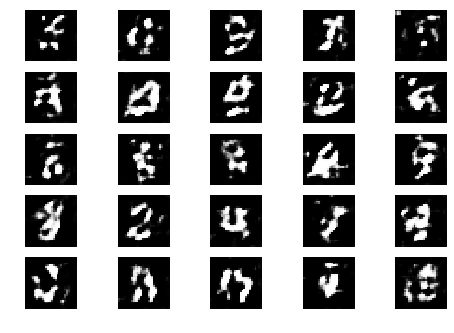

1551 [D loss: 0.999976] [G loss: 1.000019]
1552 [D loss: 0.999965] [G loss: 1.000048]
1553 [D loss: 0.999969] [G loss: 1.000069]
1554 [D loss: 0.999967] [G loss: 1.000047]
1555 [D loss: 0.999965] [G loss: 1.000056]
1556 [D loss: 0.999951] [G loss: 1.000073]
1557 [D loss: 0.999973] [G loss: 1.000050]
1558 [D loss: 0.999968] [G loss: 1.000073]
1559 [D loss: 0.999994] [G loss: 1.000057]
1560 [D loss: 0.999984] [G loss: 1.000042]
1561 [D loss: 0.999962] [G loss: 1.000054]
1562 [D loss: 0.999946] [G loss: 1.000030]
1563 [D loss: 0.999961] [G loss: 1.000042]
1564 [D loss: 0.999958] [G loss: 1.000074]
1565 [D loss: 0.999957] [G loss: 1.000055]
1566 [D loss: 0.999968] [G loss: 1.000058]
1567 [D loss: 0.999969] [G loss: 1.000066]
1568 [D loss: 0.999967] [G loss: 1.000054]
1569 [D loss: 0.999956] [G loss: 1.000078]
1570 [D loss: 0.999964] [G loss: 1.000060]
1571 [D loss: 0.999983] [G loss: 1.000042]
1572 [D loss: 0.999969] [G loss: 1.000092]
1573 [D loss: 0.999975] [G loss: 1.000070]
1574 [D los

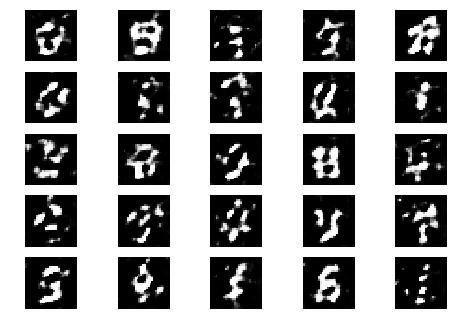

1601 [D loss: 0.999969] [G loss: 1.000057]
1602 [D loss: 0.999962] [G loss: 1.000052]
1603 [D loss: 0.999958] [G loss: 1.000051]
1604 [D loss: 0.999978] [G loss: 1.000051]
1605 [D loss: 0.999965] [G loss: 1.000065]
1606 [D loss: 0.999965] [G loss: 1.000071]
1607 [D loss: 0.999979] [G loss: 1.000050]
1608 [D loss: 0.999959] [G loss: 1.000052]
1609 [D loss: 0.999985] [G loss: 1.000051]
1610 [D loss: 0.999964] [G loss: 1.000046]
1611 [D loss: 0.999954] [G loss: 1.000090]
1612 [D loss: 0.999990] [G loss: 1.000071]
1613 [D loss: 0.999982] [G loss: 1.000110]
1614 [D loss: 0.999963] [G loss: 1.000058]
1615 [D loss: 0.999984] [G loss: 1.000059]
1616 [D loss: 0.999972] [G loss: 1.000086]
1617 [D loss: 0.999979] [G loss: 1.000051]
1618 [D loss: 0.999970] [G loss: 1.000064]
1619 [D loss: 0.999967] [G loss: 1.000078]
1620 [D loss: 0.999958] [G loss: 1.000066]
1621 [D loss: 0.999966] [G loss: 1.000058]
1622 [D loss: 0.999966] [G loss: 1.000054]
1623 [D loss: 0.999990] [G loss: 1.000037]
1624 [D los

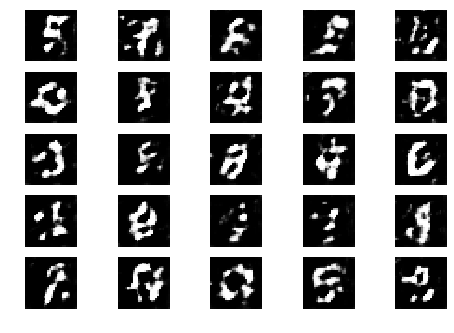

1651 [D loss: 0.999973] [G loss: 1.000063]
1652 [D loss: 0.999971] [G loss: 1.000070]
1653 [D loss: 0.999962] [G loss: 1.000035]
1654 [D loss: 0.999956] [G loss: 1.000062]
1655 [D loss: 0.999963] [G loss: 1.000067]
1656 [D loss: 0.999967] [G loss: 1.000068]
1657 [D loss: 0.999968] [G loss: 1.000045]
1658 [D loss: 0.999970] [G loss: 1.000054]
1659 [D loss: 0.999964] [G loss: 1.000072]
1660 [D loss: 0.999965] [G loss: 1.000044]
1661 [D loss: 0.999968] [G loss: 1.000052]
1662 [D loss: 0.999977] [G loss: 1.000062]
1663 [D loss: 0.999976] [G loss: 1.000053]
1664 [D loss: 0.999963] [G loss: 1.000064]
1665 [D loss: 0.999970] [G loss: 1.000053]
1666 [D loss: 0.999964] [G loss: 1.000040]
1667 [D loss: 0.999966] [G loss: 1.000041]
1668 [D loss: 0.999977] [G loss: 1.000028]
1669 [D loss: 0.999978] [G loss: 1.000057]
1670 [D loss: 0.999943] [G loss: 1.000073]
1671 [D loss: 0.999980] [G loss: 1.000053]
1672 [D loss: 0.999965] [G loss: 1.000060]
1673 [D loss: 0.999969] [G loss: 1.000058]
1674 [D los

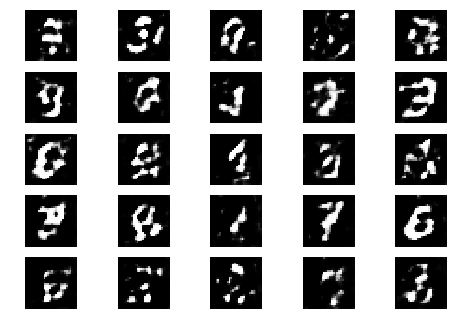

1701 [D loss: 0.999982] [G loss: 1.000036]
1702 [D loss: 0.999979] [G loss: 1.000067]
1703 [D loss: 0.999947] [G loss: 1.000047]
1704 [D loss: 0.999969] [G loss: 1.000053]
1705 [D loss: 0.999962] [G loss: 1.000051]
1706 [D loss: 0.999969] [G loss: 1.000056]
1707 [D loss: 0.999963] [G loss: 1.000041]
1708 [D loss: 0.999969] [G loss: 1.000039]
1709 [D loss: 0.999989] [G loss: 1.000044]
1710 [D loss: 0.999967] [G loss: 1.000072]
1711 [D loss: 0.999981] [G loss: 1.000046]
1712 [D loss: 0.999973] [G loss: 1.000037]
1713 [D loss: 0.999976] [G loss: 1.000050]
1714 [D loss: 0.999947] [G loss: 1.000088]
1715 [D loss: 0.999977] [G loss: 1.000051]
1716 [D loss: 0.999978] [G loss: 1.000008]
1717 [D loss: 0.999967] [G loss: 1.000075]
1718 [D loss: 0.999985] [G loss: 1.000065]
1719 [D loss: 0.999968] [G loss: 1.000065]
1720 [D loss: 0.999962] [G loss: 1.000031]
1721 [D loss: 0.999969] [G loss: 1.000037]
1722 [D loss: 0.999966] [G loss: 1.000053]
1723 [D loss: 0.999982] [G loss: 1.000079]
1724 [D los

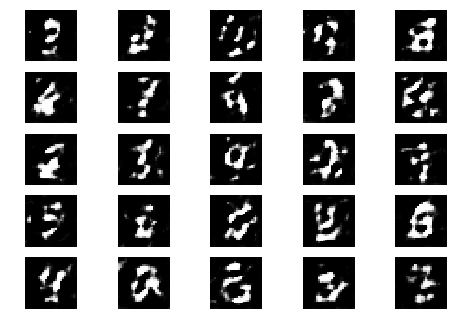

1751 [D loss: 0.999972] [G loss: 1.000055]
1752 [D loss: 0.999968] [G loss: 1.000040]
1753 [D loss: 0.999963] [G loss: 1.000091]
1754 [D loss: 0.999963] [G loss: 1.000055]
1755 [D loss: 0.999980] [G loss: 1.000051]
1756 [D loss: 0.999975] [G loss: 1.000060]
1757 [D loss: 0.999962] [G loss: 1.000059]
1758 [D loss: 0.999955] [G loss: 1.000053]
1759 [D loss: 0.999963] [G loss: 1.000062]
1760 [D loss: 0.999968] [G loss: 1.000058]
1761 [D loss: 0.999973] [G loss: 1.000056]
1762 [D loss: 0.999970] [G loss: 1.000072]
1763 [D loss: 0.999970] [G loss: 1.000068]
1764 [D loss: 0.999972] [G loss: 1.000050]
1765 [D loss: 0.999964] [G loss: 1.000056]
1766 [D loss: 0.999956] [G loss: 1.000056]
1767 [D loss: 0.999971] [G loss: 1.000035]
1768 [D loss: 0.999967] [G loss: 1.000065]
1769 [D loss: 0.999991] [G loss: 1.000071]
1770 [D loss: 0.999961] [G loss: 1.000052]
1771 [D loss: 0.999980] [G loss: 1.000048]
1772 [D loss: 0.999953] [G loss: 1.000074]
1773 [D loss: 0.999978] [G loss: 1.000051]
1774 [D los

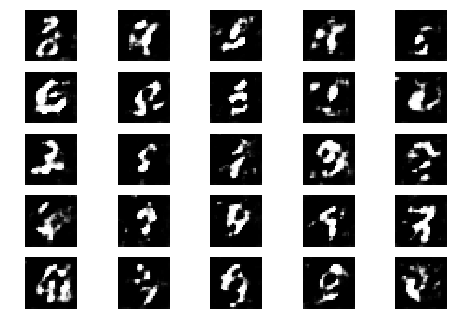

1801 [D loss: 0.999976] [G loss: 1.000052]
1802 [D loss: 0.999970] [G loss: 1.000024]
1803 [D loss: 0.999972] [G loss: 1.000080]
1804 [D loss: 0.999962] [G loss: 1.000060]
1805 [D loss: 0.999980] [G loss: 1.000058]
1806 [D loss: 0.999964] [G loss: 1.000052]
1807 [D loss: 0.999975] [G loss: 1.000078]
1808 [D loss: 0.999960] [G loss: 1.000060]
1809 [D loss: 0.999979] [G loss: 1.000073]
1810 [D loss: 0.999973] [G loss: 1.000057]
1811 [D loss: 0.999963] [G loss: 1.000085]
1812 [D loss: 0.999955] [G loss: 1.000068]
1813 [D loss: 0.999960] [G loss: 1.000052]
1814 [D loss: 0.999971] [G loss: 1.000030]
1815 [D loss: 0.999974] [G loss: 1.000066]
1816 [D loss: 0.999981] [G loss: 1.000054]
1817 [D loss: 0.999972] [G loss: 1.000070]
1818 [D loss: 0.999965] [G loss: 1.000056]
1819 [D loss: 0.999979] [G loss: 1.000070]
1820 [D loss: 0.999957] [G loss: 1.000072]
1821 [D loss: 0.999970] [G loss: 1.000084]
1822 [D loss: 0.999973] [G loss: 1.000070]
1823 [D loss: 0.999988] [G loss: 1.000061]
1824 [D los

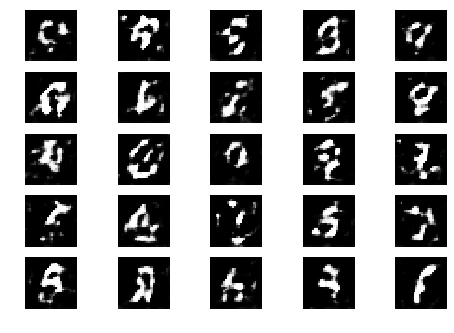

1851 [D loss: 0.999974] [G loss: 1.000048]
1852 [D loss: 0.999956] [G loss: 1.000068]
1853 [D loss: 0.999961] [G loss: 1.000080]
1854 [D loss: 0.999972] [G loss: 1.000066]
1855 [D loss: 0.999956] [G loss: 1.000105]
1856 [D loss: 0.999964] [G loss: 1.000059]
1857 [D loss: 0.999952] [G loss: 1.000052]
1858 [D loss: 0.999959] [G loss: 1.000052]
1859 [D loss: 0.999952] [G loss: 1.000053]
1860 [D loss: 0.999997] [G loss: 1.000038]
1861 [D loss: 0.999964] [G loss: 1.000059]
1862 [D loss: 0.999958] [G loss: 1.000056]
1863 [D loss: 0.999962] [G loss: 1.000064]
1864 [D loss: 0.999987] [G loss: 1.000062]
1865 [D loss: 0.999962] [G loss: 1.000054]
1866 [D loss: 0.999956] [G loss: 1.000035]
1867 [D loss: 0.999960] [G loss: 1.000081]
1868 [D loss: 0.999956] [G loss: 1.000050]
1869 [D loss: 0.999977] [G loss: 1.000071]
1870 [D loss: 0.999976] [G loss: 1.000043]
1871 [D loss: 0.999977] [G loss: 1.000068]
1872 [D loss: 0.999976] [G loss: 1.000075]
1873 [D loss: 0.999967] [G loss: 1.000044]
1874 [D los

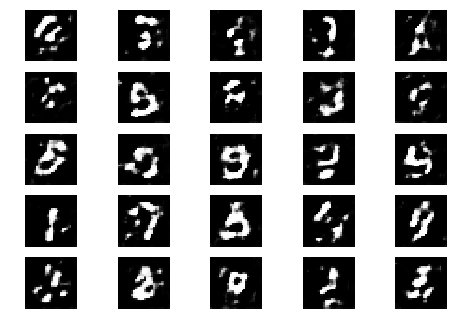

1901 [D loss: 0.999964] [G loss: 1.000064]
1902 [D loss: 0.999989] [G loss: 1.000077]
1903 [D loss: 0.999942] [G loss: 1.000048]
1904 [D loss: 0.999985] [G loss: 1.000040]
1905 [D loss: 0.999947] [G loss: 1.000070]
1906 [D loss: 0.999982] [G loss: 1.000058]
1907 [D loss: 0.999975] [G loss: 1.000068]
1908 [D loss: 0.999968] [G loss: 1.000101]
1909 [D loss: 0.999967] [G loss: 1.000048]
1910 [D loss: 0.999969] [G loss: 1.000048]
1911 [D loss: 0.999970] [G loss: 1.000069]
1912 [D loss: 0.999960] [G loss: 1.000039]
1913 [D loss: 0.999974] [G loss: 1.000071]
1914 [D loss: 0.999953] [G loss: 1.000061]
1915 [D loss: 0.999970] [G loss: 1.000077]
1916 [D loss: 0.999964] [G loss: 1.000072]
1917 [D loss: 0.999972] [G loss: 1.000029]
1918 [D loss: 0.999959] [G loss: 1.000054]
1919 [D loss: 0.999968] [G loss: 1.000062]
1920 [D loss: 0.999990] [G loss: 1.000058]
1921 [D loss: 0.999967] [G loss: 1.000068]
1922 [D loss: 0.999975] [G loss: 1.000070]
1923 [D loss: 0.999991] [G loss: 1.000084]
1924 [D los

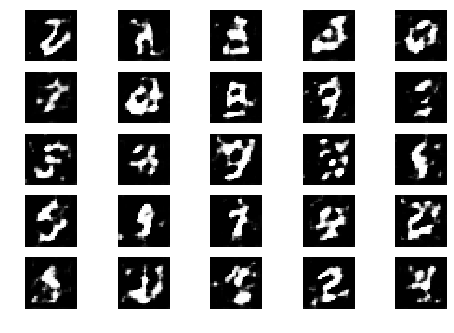

1951 [D loss: 0.999968] [G loss: 1.000068]
1952 [D loss: 0.999983] [G loss: 1.000053]
1953 [D loss: 0.999989] [G loss: 1.000067]
1954 [D loss: 0.999967] [G loss: 1.000079]
1955 [D loss: 0.999978] [G loss: 1.000069]
1956 [D loss: 0.999962] [G loss: 1.000056]
1957 [D loss: 0.999978] [G loss: 1.000048]
1958 [D loss: 0.999998] [G loss: 1.000057]
1959 [D loss: 0.999960] [G loss: 1.000047]
1960 [D loss: 0.999974] [G loss: 1.000090]
1961 [D loss: 0.999983] [G loss: 1.000056]
1962 [D loss: 0.999985] [G loss: 1.000069]
1963 [D loss: 0.999972] [G loss: 1.000074]
1964 [D loss: 0.999959] [G loss: 1.000047]
1965 [D loss: 0.999967] [G loss: 1.000059]
1966 [D loss: 0.999960] [G loss: 1.000051]
1967 [D loss: 0.999970] [G loss: 1.000055]
1968 [D loss: 0.999946] [G loss: 1.000032]
1969 [D loss: 0.999951] [G loss: 1.000048]
1970 [D loss: 0.999971] [G loss: 1.000053]
1971 [D loss: 0.999982] [G loss: 1.000072]
1972 [D loss: 0.999965] [G loss: 1.000040]
1973 [D loss: 0.999963] [G loss: 1.000046]
1974 [D los

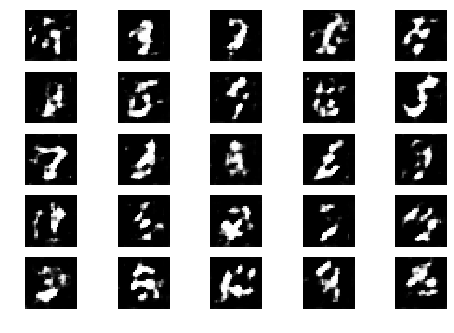

2001 [D loss: 0.999959] [G loss: 1.000070]
2002 [D loss: 0.999983] [G loss: 1.000067]
2003 [D loss: 0.999967] [G loss: 1.000063]
2004 [D loss: 0.999973] [G loss: 1.000069]
2005 [D loss: 0.999954] [G loss: 1.000063]
2006 [D loss: 0.999978] [G loss: 1.000050]
2007 [D loss: 0.999967] [G loss: 1.000063]
2008 [D loss: 0.999969] [G loss: 1.000041]
2009 [D loss: 0.999988] [G loss: 1.000078]
2010 [D loss: 0.999981] [G loss: 1.000046]
2011 [D loss: 0.999978] [G loss: 1.000075]
2012 [D loss: 0.999968] [G loss: 1.000068]
2013 [D loss: 0.999970] [G loss: 1.000051]
2014 [D loss: 0.999982] [G loss: 1.000059]
2015 [D loss: 0.999968] [G loss: 1.000068]
2016 [D loss: 0.999970] [G loss: 1.000061]
2017 [D loss: 0.999982] [G loss: 1.000050]
2018 [D loss: 0.999971] [G loss: 1.000060]
2019 [D loss: 0.999970] [G loss: 1.000052]
2020 [D loss: 0.999959] [G loss: 1.000026]
2021 [D loss: 0.999981] [G loss: 1.000059]
2022 [D loss: 0.999973] [G loss: 1.000074]
2023 [D loss: 0.999965] [G loss: 1.000038]
2024 [D los

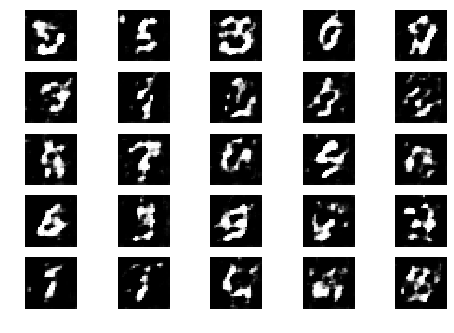

2051 [D loss: 0.999984] [G loss: 1.000069]
2052 [D loss: 0.999963] [G loss: 1.000049]
2053 [D loss: 0.999972] [G loss: 1.000052]
2054 [D loss: 0.999950] [G loss: 1.000062]
2055 [D loss: 0.999968] [G loss: 1.000054]
2056 [D loss: 0.999956] [G loss: 1.000058]
2057 [D loss: 0.999964] [G loss: 1.000057]
2058 [D loss: 0.999970] [G loss: 1.000040]
2059 [D loss: 0.999955] [G loss: 1.000059]
2060 [D loss: 0.999978] [G loss: 1.000066]
2061 [D loss: 0.999977] [G loss: 1.000064]
2062 [D loss: 0.999956] [G loss: 1.000052]
2063 [D loss: 0.999977] [G loss: 1.000069]
2064 [D loss: 0.999964] [G loss: 1.000084]
2065 [D loss: 0.999962] [G loss: 1.000050]
2066 [D loss: 0.999986] [G loss: 1.000045]
2067 [D loss: 0.999960] [G loss: 1.000059]
2068 [D loss: 0.999960] [G loss: 1.000058]
2069 [D loss: 0.999966] [G loss: 1.000085]
2070 [D loss: 0.999973] [G loss: 1.000053]
2071 [D loss: 0.999966] [G loss: 1.000050]
2072 [D loss: 0.999969] [G loss: 1.000038]
2073 [D loss: 0.999963] [G loss: 1.000075]
2074 [D los

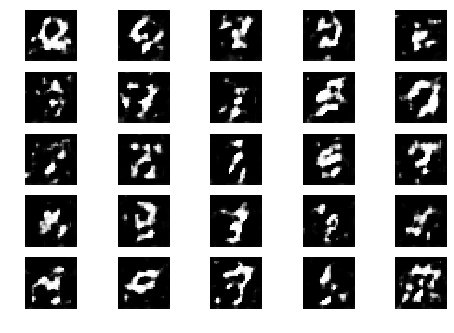

2101 [D loss: 0.999961] [G loss: 1.000047]
2102 [D loss: 0.999971] [G loss: 1.000047]
2103 [D loss: 0.999969] [G loss: 1.000052]
2104 [D loss: 0.999967] [G loss: 1.000048]
2105 [D loss: 0.999966] [G loss: 1.000048]
2106 [D loss: 0.999964] [G loss: 1.000061]
2107 [D loss: 0.999958] [G loss: 1.000043]
2108 [D loss: 0.999981] [G loss: 1.000061]
2109 [D loss: 0.999972] [G loss: 1.000055]
2110 [D loss: 0.999959] [G loss: 1.000047]
2111 [D loss: 0.999971] [G loss: 1.000051]
2112 [D loss: 0.999985] [G loss: 1.000045]
2113 [D loss: 0.999962] [G loss: 1.000065]
2114 [D loss: 0.999980] [G loss: 1.000064]
2115 [D loss: 0.999970] [G loss: 1.000081]
2116 [D loss: 0.999957] [G loss: 1.000065]
2117 [D loss: 0.999970] [G loss: 1.000060]
2118 [D loss: 0.999967] [G loss: 1.000062]
2119 [D loss: 0.999966] [G loss: 1.000045]
2120 [D loss: 0.999987] [G loss: 1.000090]
2121 [D loss: 0.999966] [G loss: 1.000059]
2122 [D loss: 0.999982] [G loss: 1.000045]
2123 [D loss: 0.999975] [G loss: 1.000038]
2124 [D los

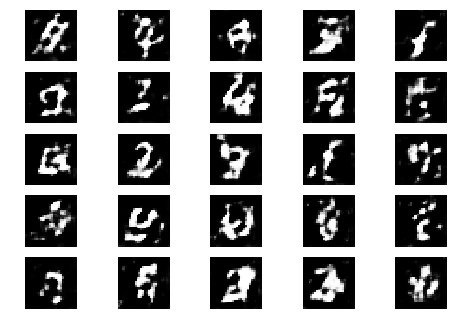

2151 [D loss: 0.999973] [G loss: 1.000031]
2152 [D loss: 0.999969] [G loss: 1.000044]
2153 [D loss: 0.999955] [G loss: 1.000078]
2154 [D loss: 0.999983] [G loss: 1.000028]
2155 [D loss: 0.999975] [G loss: 1.000091]
2156 [D loss: 0.999970] [G loss: 1.000056]
2157 [D loss: 0.999977] [G loss: 1.000037]
2158 [D loss: 0.999976] [G loss: 1.000074]
2159 [D loss: 0.999964] [G loss: 1.000081]
2160 [D loss: 0.999958] [G loss: 1.000041]
2161 [D loss: 0.999970] [G loss: 1.000090]
2162 [D loss: 0.999970] [G loss: 1.000034]
2163 [D loss: 0.999960] [G loss: 1.000083]
2164 [D loss: 0.999966] [G loss: 1.000057]
2165 [D loss: 0.999976] [G loss: 1.000091]
2166 [D loss: 0.999947] [G loss: 1.000035]
2167 [D loss: 0.999984] [G loss: 1.000068]
2168 [D loss: 0.999964] [G loss: 1.000060]
2169 [D loss: 0.999946] [G loss: 1.000061]
2170 [D loss: 0.999980] [G loss: 1.000090]
2171 [D loss: 0.999968] [G loss: 1.000044]
2172 [D loss: 0.999963] [G loss: 1.000059]
2173 [D loss: 0.999971] [G loss: 1.000053]
2174 [D los

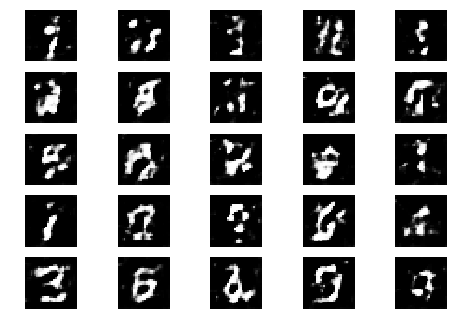

2201 [D loss: 0.999972] [G loss: 1.000056]
2202 [D loss: 0.999991] [G loss: 1.000066]
2203 [D loss: 0.999972] [G loss: 1.000071]
2204 [D loss: 0.999974] [G loss: 1.000057]
2205 [D loss: 0.999982] [G loss: 1.000073]
2206 [D loss: 0.999958] [G loss: 1.000047]
2207 [D loss: 0.999958] [G loss: 1.000081]
2208 [D loss: 0.999947] [G loss: 1.000071]
2209 [D loss: 0.999961] [G loss: 1.000064]
2210 [D loss: 0.999960] [G loss: 1.000037]
2211 [D loss: 0.999975] [G loss: 1.000057]
2212 [D loss: 0.999971] [G loss: 1.000035]
2213 [D loss: 0.999982] [G loss: 1.000053]
2214 [D loss: 0.999957] [G loss: 1.000056]
2215 [D loss: 0.999972] [G loss: 1.000054]
2216 [D loss: 0.999972] [G loss: 1.000067]
2217 [D loss: 0.999983] [G loss: 1.000051]
2218 [D loss: 0.999954] [G loss: 1.000045]
2219 [D loss: 0.999975] [G loss: 1.000045]
2220 [D loss: 0.999986] [G loss: 1.000063]
2221 [D loss: 0.999969] [G loss: 1.000041]
2222 [D loss: 0.999968] [G loss: 1.000085]
2223 [D loss: 0.999977] [G loss: 1.000057]
2224 [D los

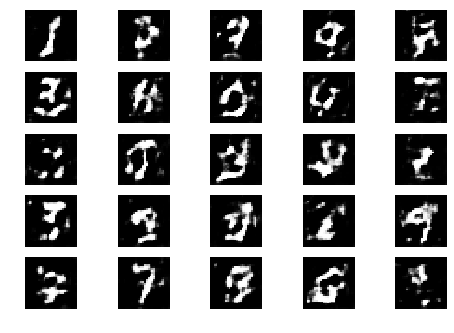

2251 [D loss: 0.999976] [G loss: 1.000031]
2252 [D loss: 0.999958] [G loss: 1.000075]
2253 [D loss: 0.999967] [G loss: 1.000061]
2254 [D loss: 0.999981] [G loss: 1.000047]
2255 [D loss: 0.999942] [G loss: 1.000053]
2256 [D loss: 0.999966] [G loss: 1.000012]
2257 [D loss: 0.999966] [G loss: 1.000084]
2258 [D loss: 0.999971] [G loss: 1.000054]
2259 [D loss: 0.999982] [G loss: 1.000079]
2260 [D loss: 0.999967] [G loss: 1.000025]
2261 [D loss: 0.999970] [G loss: 1.000030]
2262 [D loss: 0.999975] [G loss: 1.000062]
2263 [D loss: 0.999967] [G loss: 1.000018]
2264 [D loss: 0.999963] [G loss: 1.000029]
2265 [D loss: 0.999980] [G loss: 1.000084]
2266 [D loss: 0.999963] [G loss: 1.000055]
2267 [D loss: 0.999977] [G loss: 1.000043]
2268 [D loss: 0.999983] [G loss: 1.000044]
2269 [D loss: 0.999972] [G loss: 1.000047]
2270 [D loss: 0.999977] [G loss: 1.000028]
2271 [D loss: 0.999983] [G loss: 1.000059]
2272 [D loss: 0.999981] [G loss: 1.000031]
2273 [D loss: 0.999980] [G loss: 1.000035]
2274 [D los

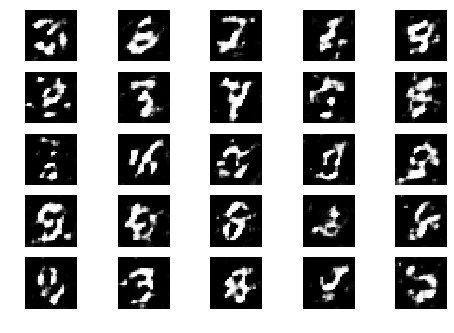

2301 [D loss: 0.999967] [G loss: 1.000074]
2302 [D loss: 0.999973] [G loss: 1.000068]
2303 [D loss: 0.999988] [G loss: 1.000061]
2304 [D loss: 0.999954] [G loss: 1.000077]
2305 [D loss: 0.999975] [G loss: 1.000058]
2306 [D loss: 0.999957] [G loss: 1.000058]
2307 [D loss: 0.999958] [G loss: 1.000059]
2308 [D loss: 0.999980] [G loss: 1.000032]
2309 [D loss: 0.999971] [G loss: 1.000071]
2310 [D loss: 0.999974] [G loss: 1.000030]
2311 [D loss: 0.999975] [G loss: 1.000075]
2312 [D loss: 0.999964] [G loss: 1.000081]
2313 [D loss: 0.999967] [G loss: 1.000062]
2314 [D loss: 0.999954] [G loss: 1.000056]
2315 [D loss: 0.999977] [G loss: 1.000072]
2316 [D loss: 0.999974] [G loss: 1.000078]
2317 [D loss: 0.999987] [G loss: 1.000050]
2318 [D loss: 0.999959] [G loss: 1.000081]
2319 [D loss: 0.999970] [G loss: 1.000030]
2320 [D loss: 0.999957] [G loss: 1.000096]
2321 [D loss: 0.999972] [G loss: 1.000085]
2322 [D loss: 0.999972] [G loss: 1.000059]
2323 [D loss: 0.999949] [G loss: 1.000061]
2324 [D los

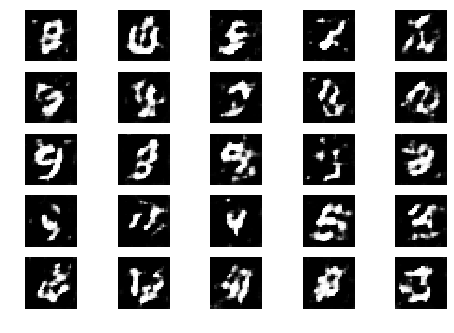

2351 [D loss: 0.999960] [G loss: 1.000049]
2352 [D loss: 0.999977] [G loss: 1.000042]
2353 [D loss: 0.999976] [G loss: 1.000071]
2354 [D loss: 0.999973] [G loss: 1.000032]
2355 [D loss: 0.999951] [G loss: 1.000040]
2356 [D loss: 0.999986] [G loss: 1.000063]
2357 [D loss: 0.999966] [G loss: 1.000026]
2358 [D loss: 0.999969] [G loss: 1.000032]
2359 [D loss: 0.999967] [G loss: 1.000019]
2360 [D loss: 0.999966] [G loss: 1.000069]
2361 [D loss: 0.999964] [G loss: 1.000046]
2362 [D loss: 0.999966] [G loss: 1.000062]
2363 [D loss: 0.999986] [G loss: 1.000081]
2364 [D loss: 0.999984] [G loss: 1.000033]
2365 [D loss: 0.999981] [G loss: 1.000072]
2366 [D loss: 0.999957] [G loss: 1.000073]
2367 [D loss: 0.999944] [G loss: 1.000040]
2368 [D loss: 0.999965] [G loss: 1.000038]
2369 [D loss: 0.999966] [G loss: 1.000068]
2370 [D loss: 0.999974] [G loss: 1.000060]
2371 [D loss: 0.999963] [G loss: 1.000056]
2372 [D loss: 0.999956] [G loss: 1.000070]
2373 [D loss: 0.999974] [G loss: 1.000067]
2374 [D los

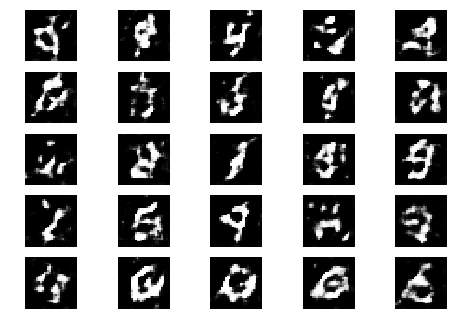

2401 [D loss: 0.999960] [G loss: 1.000054]
2402 [D loss: 0.999984] [G loss: 1.000052]
2403 [D loss: 0.999969] [G loss: 1.000059]
2404 [D loss: 0.999963] [G loss: 1.000049]
2405 [D loss: 0.999991] [G loss: 1.000067]
2406 [D loss: 0.999981] [G loss: 1.000024]
2407 [D loss: 0.999966] [G loss: 1.000073]
2408 [D loss: 0.999959] [G loss: 1.000080]
2409 [D loss: 0.999970] [G loss: 1.000052]
2410 [D loss: 0.999972] [G loss: 1.000057]
2411 [D loss: 0.999959] [G loss: 1.000066]
2412 [D loss: 0.999985] [G loss: 1.000076]
2413 [D loss: 0.999954] [G loss: 1.000058]
2414 [D loss: 0.999972] [G loss: 1.000041]
2415 [D loss: 0.999985] [G loss: 1.000058]
2416 [D loss: 0.999976] [G loss: 1.000068]
2417 [D loss: 0.999987] [G loss: 1.000087]
2418 [D loss: 0.999975] [G loss: 1.000060]
2419 [D loss: 0.999961] [G loss: 1.000051]
2420 [D loss: 0.999985] [G loss: 1.000035]
2421 [D loss: 0.999955] [G loss: 1.000071]
2422 [D loss: 0.999973] [G loss: 1.000077]
2423 [D loss: 0.999971] [G loss: 1.000048]
2424 [D los

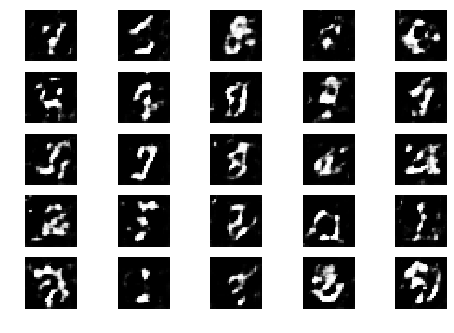

2451 [D loss: 0.999988] [G loss: 1.000098]
2452 [D loss: 0.999942] [G loss: 1.000057]
2453 [D loss: 0.999980] [G loss: 1.000030]
2454 [D loss: 0.999964] [G loss: 1.000069]
2455 [D loss: 0.999964] [G loss: 1.000056]
2456 [D loss: 0.999978] [G loss: 1.000069]
2457 [D loss: 0.999981] [G loss: 1.000112]
2458 [D loss: 0.999970] [G loss: 1.000042]
2459 [D loss: 0.999976] [G loss: 1.000059]
2460 [D loss: 0.999941] [G loss: 1.000033]
2461 [D loss: 0.999971] [G loss: 1.000078]
2462 [D loss: 0.999945] [G loss: 1.000043]
2463 [D loss: 0.999951] [G loss: 1.000041]
2464 [D loss: 0.999970] [G loss: 1.000073]
2465 [D loss: 0.999972] [G loss: 1.000074]
2466 [D loss: 0.999973] [G loss: 1.000069]
2467 [D loss: 0.999963] [G loss: 1.000063]
2468 [D loss: 0.999957] [G loss: 1.000063]
2469 [D loss: 0.999971] [G loss: 1.000037]
2470 [D loss: 0.999974] [G loss: 1.000040]
2471 [D loss: 0.999964] [G loss: 1.000082]
2472 [D loss: 0.999961] [G loss: 1.000070]
2473 [D loss: 0.999974] [G loss: 1.000061]
2474 [D los

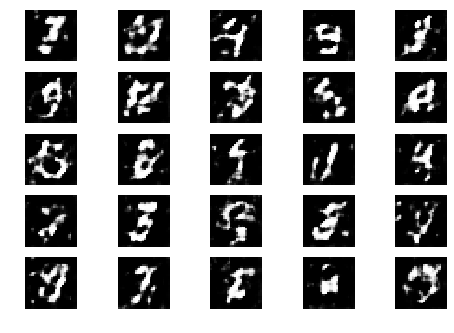

2501 [D loss: 0.999980] [G loss: 1.000062]
2502 [D loss: 0.999981] [G loss: 1.000042]
2503 [D loss: 0.999976] [G loss: 1.000044]
2504 [D loss: 0.999958] [G loss: 1.000059]
2505 [D loss: 0.999970] [G loss: 1.000049]
2506 [D loss: 0.999981] [G loss: 1.000062]
2507 [D loss: 0.999983] [G loss: 1.000064]
2508 [D loss: 0.999974] [G loss: 1.000046]
2509 [D loss: 0.999972] [G loss: 1.000078]
2510 [D loss: 0.999970] [G loss: 1.000063]
2511 [D loss: 0.999962] [G loss: 1.000074]
2512 [D loss: 0.999964] [G loss: 1.000077]
2513 [D loss: 0.999965] [G loss: 1.000068]
2514 [D loss: 0.999959] [G loss: 1.000065]
2515 [D loss: 0.999988] [G loss: 1.000043]
2516 [D loss: 0.999961] [G loss: 1.000056]
2517 [D loss: 0.999977] [G loss: 1.000071]
2518 [D loss: 0.999958] [G loss: 1.000058]
2519 [D loss: 0.999949] [G loss: 1.000062]
2520 [D loss: 0.999965] [G loss: 1.000062]
2521 [D loss: 0.999964] [G loss: 1.000052]
2522 [D loss: 0.999986] [G loss: 1.000045]
2523 [D loss: 0.999975] [G loss: 1.000056]
2524 [D los

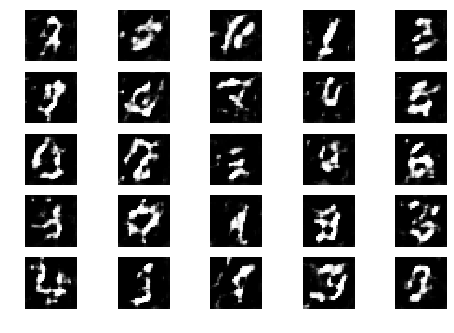

2551 [D loss: 0.999981] [G loss: 1.000063]
2552 [D loss: 0.999957] [G loss: 1.000061]
2553 [D loss: 0.999961] [G loss: 1.000032]
2554 [D loss: 0.999966] [G loss: 1.000089]
2555 [D loss: 0.999960] [G loss: 1.000037]
2556 [D loss: 0.999964] [G loss: 1.000053]
2557 [D loss: 0.999971] [G loss: 1.000062]
2558 [D loss: 0.999968] [G loss: 1.000044]
2559 [D loss: 0.999974] [G loss: 1.000067]
2560 [D loss: 0.999971] [G loss: 1.000056]
2561 [D loss: 0.999963] [G loss: 1.000062]
2562 [D loss: 0.999974] [G loss: 1.000061]
2563 [D loss: 0.999978] [G loss: 1.000067]
2564 [D loss: 0.999963] [G loss: 1.000036]
2565 [D loss: 0.999964] [G loss: 1.000069]
2566 [D loss: 0.999973] [G loss: 1.000068]
2567 [D loss: 0.999980] [G loss: 1.000044]
2568 [D loss: 0.999953] [G loss: 1.000050]
2569 [D loss: 0.999981] [G loss: 1.000076]
2570 [D loss: 0.999967] [G loss: 1.000068]
2571 [D loss: 0.999974] [G loss: 1.000031]
2572 [D loss: 0.999966] [G loss: 1.000038]
2573 [D loss: 0.999965] [G loss: 1.000051]
2574 [D los

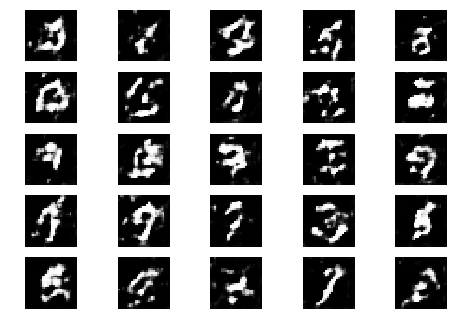

2601 [D loss: 0.999965] [G loss: 1.000059]
2602 [D loss: 0.999972] [G loss: 1.000036]
2603 [D loss: 0.999976] [G loss: 1.000066]
2604 [D loss: 0.999977] [G loss: 1.000073]
2605 [D loss: 0.999975] [G loss: 1.000057]
2606 [D loss: 0.999949] [G loss: 1.000079]
2607 [D loss: 0.999974] [G loss: 1.000053]
2608 [D loss: 0.999960] [G loss: 1.000042]
2609 [D loss: 0.999964] [G loss: 1.000065]
2610 [D loss: 0.999980] [G loss: 1.000056]
2611 [D loss: 0.999972] [G loss: 1.000073]
2612 [D loss: 0.999947] [G loss: 1.000041]
2613 [D loss: 0.999984] [G loss: 1.000057]
2614 [D loss: 0.999973] [G loss: 1.000063]
2615 [D loss: 0.999941] [G loss: 1.000064]
2616 [D loss: 0.999979] [G loss: 1.000052]
2617 [D loss: 0.999955] [G loss: 1.000073]
2618 [D loss: 0.999964] [G loss: 1.000060]
2619 [D loss: 0.999971] [G loss: 1.000071]
2620 [D loss: 0.999993] [G loss: 1.000054]
2621 [D loss: 0.999967] [G loss: 1.000065]
2622 [D loss: 0.999955] [G loss: 1.000034]
2623 [D loss: 0.999983] [G loss: 1.000012]
2624 [D los

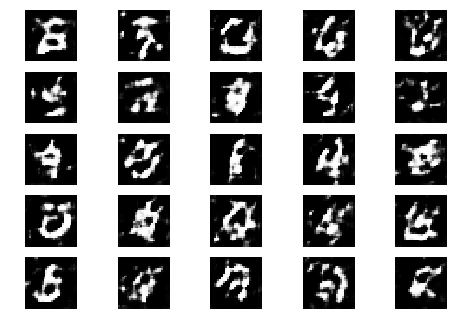

2651 [D loss: 0.999969] [G loss: 1.000065]
2652 [D loss: 0.999940] [G loss: 1.000036]
2653 [D loss: 0.999964] [G loss: 1.000054]
2654 [D loss: 0.999960] [G loss: 1.000046]
2655 [D loss: 0.999974] [G loss: 1.000032]
2656 [D loss: 0.999967] [G loss: 1.000049]
2657 [D loss: 0.999973] [G loss: 1.000055]
2658 [D loss: 0.999976] [G loss: 1.000059]
2659 [D loss: 0.999973] [G loss: 1.000058]
2660 [D loss: 0.999958] [G loss: 1.000086]
2661 [D loss: 0.999969] [G loss: 1.000056]
2662 [D loss: 0.999976] [G loss: 1.000038]
2663 [D loss: 0.999957] [G loss: 1.000036]
2664 [D loss: 0.999989] [G loss: 1.000052]
2665 [D loss: 0.999980] [G loss: 1.000063]
2666 [D loss: 0.999969] [G loss: 1.000022]
2667 [D loss: 1.000013] [G loss: 1.000063]
2668 [D loss: 0.999994] [G loss: 1.000079]
2669 [D loss: 0.999949] [G loss: 1.000068]
2670 [D loss: 0.999978] [G loss: 1.000072]
2671 [D loss: 0.999968] [G loss: 1.000043]
2672 [D loss: 0.999941] [G loss: 1.000051]
2673 [D loss: 0.999971] [G loss: 1.000055]
2674 [D los

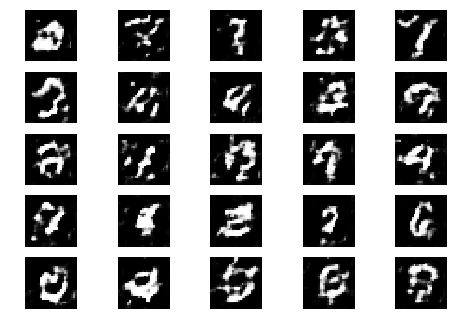

2701 [D loss: 0.999984] [G loss: 1.000056]
2702 [D loss: 0.999966] [G loss: 1.000072]
2703 [D loss: 0.999975] [G loss: 1.000064]
2704 [D loss: 0.999968] [G loss: 1.000042]
2705 [D loss: 0.999983] [G loss: 1.000053]
2706 [D loss: 0.999997] [G loss: 1.000025]
2707 [D loss: 0.999971] [G loss: 1.000047]
2708 [D loss: 0.999958] [G loss: 1.000058]
2709 [D loss: 0.999985] [G loss: 1.000071]
2710 [D loss: 1.000002] [G loss: 1.000039]
2711 [D loss: 0.999971] [G loss: 1.000071]
2712 [D loss: 0.999954] [G loss: 1.000061]
2713 [D loss: 0.999975] [G loss: 1.000083]
2714 [D loss: 0.999953] [G loss: 1.000044]
2715 [D loss: 0.999985] [G loss: 1.000078]
2716 [D loss: 0.999968] [G loss: 1.000067]
2717 [D loss: 0.999981] [G loss: 1.000091]
2718 [D loss: 0.999959] [G loss: 1.000053]
2719 [D loss: 0.999961] [G loss: 1.000043]
2720 [D loss: 0.999969] [G loss: 1.000048]
2721 [D loss: 0.999950] [G loss: 1.000056]
2722 [D loss: 0.999960] [G loss: 1.000060]
2723 [D loss: 0.999956] [G loss: 1.000059]
2724 [D los

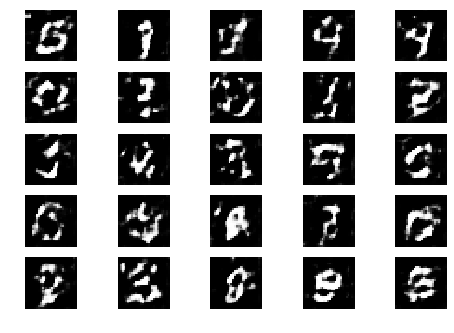

2751 [D loss: 0.999987] [G loss: 1.000072]
2752 [D loss: 0.999964] [G loss: 1.000062]
2753 [D loss: 0.999964] [G loss: 1.000045]
2754 [D loss: 0.999950] [G loss: 1.000042]
2755 [D loss: 0.999962] [G loss: 1.000075]
2756 [D loss: 0.999965] [G loss: 1.000069]
2757 [D loss: 0.999960] [G loss: 1.000063]
2758 [D loss: 0.999973] [G loss: 1.000059]
2759 [D loss: 0.999971] [G loss: 1.000067]
2760 [D loss: 0.999979] [G loss: 1.000041]
2761 [D loss: 0.999980] [G loss: 1.000045]
2762 [D loss: 0.999960] [G loss: 1.000049]
2763 [D loss: 0.999970] [G loss: 1.000067]
2764 [D loss: 0.999963] [G loss: 1.000049]
2765 [D loss: 0.999978] [G loss: 1.000066]
2766 [D loss: 0.999968] [G loss: 1.000039]
2767 [D loss: 0.999967] [G loss: 1.000058]
2768 [D loss: 0.999968] [G loss: 1.000071]
2769 [D loss: 0.999955] [G loss: 1.000042]
2770 [D loss: 0.999953] [G loss: 1.000035]
2771 [D loss: 0.999956] [G loss: 1.000039]
2772 [D loss: 0.999967] [G loss: 1.000048]
2773 [D loss: 0.999949] [G loss: 1.000070]
2774 [D los

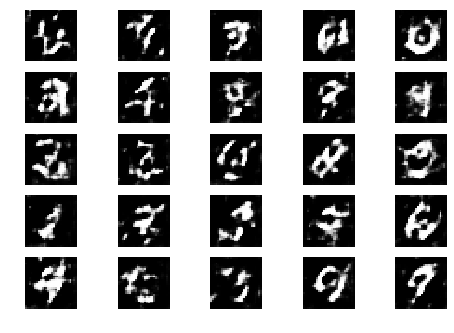

2801 [D loss: 0.999949] [G loss: 1.000033]
2802 [D loss: 0.999955] [G loss: 1.000076]
2803 [D loss: 0.999966] [G loss: 1.000037]
2804 [D loss: 0.999987] [G loss: 1.000057]
2805 [D loss: 0.999964] [G loss: 1.000037]
2806 [D loss: 0.999956] [G loss: 1.000037]
2807 [D loss: 0.999980] [G loss: 1.000070]
2808 [D loss: 0.999950] [G loss: 1.000042]
2809 [D loss: 0.999960] [G loss: 1.000054]
2810 [D loss: 0.999974] [G loss: 1.000073]
2811 [D loss: 0.999968] [G loss: 1.000079]
2812 [D loss: 0.999970] [G loss: 1.000064]
2813 [D loss: 0.999978] [G loss: 1.000060]
2814 [D loss: 0.999955] [G loss: 1.000056]
2815 [D loss: 0.999972] [G loss: 1.000056]
2816 [D loss: 0.999978] [G loss: 1.000065]
2817 [D loss: 0.999967] [G loss: 1.000049]
2818 [D loss: 0.999956] [G loss: 1.000057]
2819 [D loss: 0.999986] [G loss: 1.000084]
2820 [D loss: 0.999963] [G loss: 1.000064]
2821 [D loss: 0.999955] [G loss: 1.000073]
2822 [D loss: 0.999972] [G loss: 1.000084]
2823 [D loss: 0.999963] [G loss: 1.000055]
2824 [D los

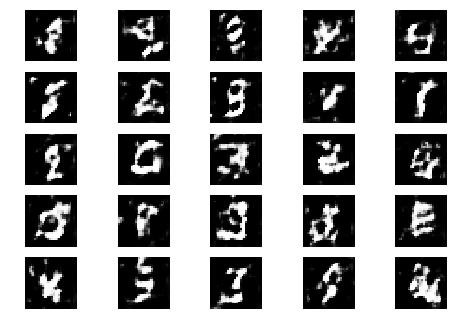

2851 [D loss: 0.999953] [G loss: 1.000063]
2852 [D loss: 0.999985] [G loss: 1.000049]
2853 [D loss: 0.999953] [G loss: 1.000063]
2854 [D loss: 0.999971] [G loss: 1.000050]
2855 [D loss: 0.999954] [G loss: 1.000063]
2856 [D loss: 0.999963] [G loss: 1.000046]
2857 [D loss: 0.999967] [G loss: 1.000070]
2858 [D loss: 0.999977] [G loss: 1.000035]
2859 [D loss: 0.999962] [G loss: 1.000056]
2860 [D loss: 0.999962] [G loss: 1.000037]
2861 [D loss: 0.999979] [G loss: 1.000061]
2862 [D loss: 0.999964] [G loss: 1.000056]
2863 [D loss: 0.999978] [G loss: 1.000060]
2864 [D loss: 0.999970] [G loss: 1.000063]
2865 [D loss: 0.999955] [G loss: 1.000063]
2866 [D loss: 0.999970] [G loss: 1.000047]
2867 [D loss: 0.999942] [G loss: 1.000053]
2868 [D loss: 0.999971] [G loss: 1.000092]
2869 [D loss: 0.999963] [G loss: 1.000059]
2870 [D loss: 0.999956] [G loss: 1.000082]
2871 [D loss: 0.999961] [G loss: 1.000059]
2872 [D loss: 0.999966] [G loss: 1.000074]
2873 [D loss: 0.999984] [G loss: 1.000056]
2874 [D los

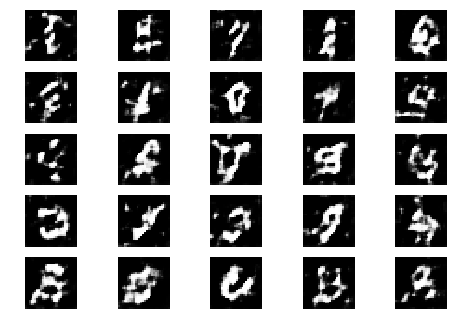

2901 [D loss: 0.999964] [G loss: 1.000050]
2902 [D loss: 0.999944] [G loss: 1.000039]
2903 [D loss: 0.999963] [G loss: 1.000021]
2904 [D loss: 0.999963] [G loss: 1.000070]
2905 [D loss: 0.999959] [G loss: 1.000040]
2906 [D loss: 0.999970] [G loss: 1.000051]
2907 [D loss: 0.999962] [G loss: 1.000053]
2908 [D loss: 0.999967] [G loss: 1.000079]
2909 [D loss: 0.999962] [G loss: 1.000053]
2910 [D loss: 0.999957] [G loss: 1.000032]
2911 [D loss: 0.999952] [G loss: 1.000054]
2912 [D loss: 0.999970] [G loss: 1.000071]
2913 [D loss: 0.999964] [G loss: 1.000070]
2914 [D loss: 0.999936] [G loss: 1.000057]
2915 [D loss: 0.999963] [G loss: 1.000066]
2916 [D loss: 0.999955] [G loss: 1.000082]
2917 [D loss: 0.999953] [G loss: 1.000053]
2918 [D loss: 0.999969] [G loss: 1.000065]
2919 [D loss: 0.999974] [G loss: 1.000075]
2920 [D loss: 0.999954] [G loss: 1.000063]
2921 [D loss: 0.999971] [G loss: 1.000072]
2922 [D loss: 0.999964] [G loss: 1.000052]
2923 [D loss: 0.999971] [G loss: 1.000077]
2924 [D los

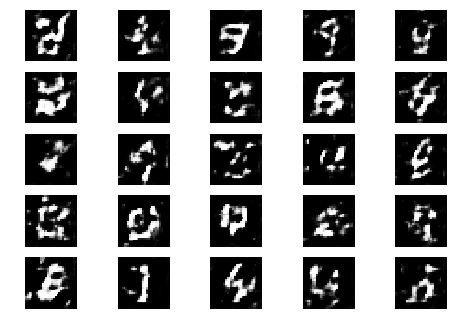

2951 [D loss: 0.999962] [G loss: 1.000062]
2952 [D loss: 0.999969] [G loss: 1.000076]
2953 [D loss: 0.999973] [G loss: 1.000065]
2954 [D loss: 0.999957] [G loss: 1.000057]
2955 [D loss: 0.999961] [G loss: 1.000102]
2956 [D loss: 0.999961] [G loss: 1.000065]
2957 [D loss: 0.999957] [G loss: 1.000073]
2958 [D loss: 0.999969] [G loss: 1.000091]
2959 [D loss: 0.999958] [G loss: 1.000028]
2960 [D loss: 0.999962] [G loss: 1.000057]
2961 [D loss: 0.999971] [G loss: 1.000079]
2962 [D loss: 0.999957] [G loss: 1.000054]
2963 [D loss: 0.999962] [G loss: 1.000061]
2964 [D loss: 0.999971] [G loss: 1.000069]
2965 [D loss: 0.999956] [G loss: 1.000063]
2966 [D loss: 0.999978] [G loss: 1.000027]
2967 [D loss: 0.999955] [G loss: 1.000071]
2968 [D loss: 0.999949] [G loss: 1.000076]
2969 [D loss: 0.999964] [G loss: 1.000067]
2970 [D loss: 0.999973] [G loss: 1.000048]
2971 [D loss: 0.999966] [G loss: 1.000035]
2972 [D loss: 0.999966] [G loss: 1.000073]
2973 [D loss: 0.999971] [G loss: 1.000055]
2974 [D los

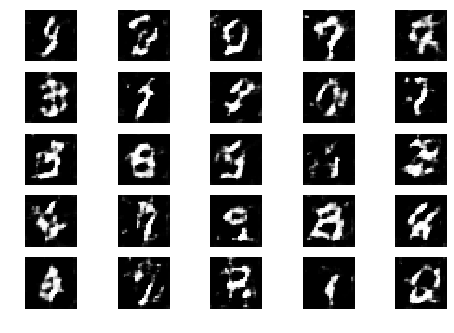

3001 [D loss: 0.999958] [G loss: 1.000058]
3002 [D loss: 0.999961] [G loss: 1.000061]
3003 [D loss: 0.999963] [G loss: 1.000064]
3004 [D loss: 0.999960] [G loss: 1.000092]
3005 [D loss: 0.999974] [G loss: 1.000053]
3006 [D loss: 0.999967] [G loss: 1.000050]
3007 [D loss: 0.999954] [G loss: 1.000043]
3008 [D loss: 0.999970] [G loss: 1.000054]
3009 [D loss: 0.999974] [G loss: 1.000068]
3010 [D loss: 0.999994] [G loss: 1.000022]
3011 [D loss: 0.999981] [G loss: 1.000035]
3012 [D loss: 0.999958] [G loss: 1.000071]
3013 [D loss: 0.999968] [G loss: 1.000059]
3014 [D loss: 0.999965] [G loss: 1.000060]
3015 [D loss: 0.999966] [G loss: 1.000058]
3016 [D loss: 0.999954] [G loss: 1.000076]
3017 [D loss: 0.999968] [G loss: 1.000067]
3018 [D loss: 0.999959] [G loss: 1.000050]
3019 [D loss: 0.999974] [G loss: 1.000060]
3020 [D loss: 0.999965] [G loss: 1.000066]
3021 [D loss: 0.999961] [G loss: 1.000063]
3022 [D loss: 0.999976] [G loss: 1.000045]
3023 [D loss: 0.999986] [G loss: 1.000063]
3024 [D los

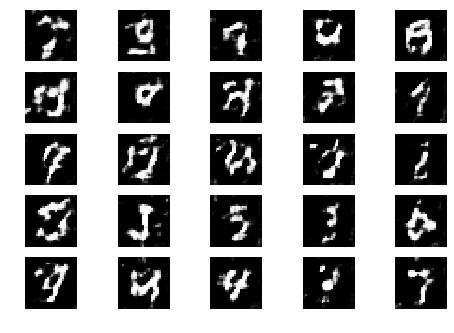

3051 [D loss: 0.999969] [G loss: 1.000058]
3052 [D loss: 0.999961] [G loss: 1.000030]
3053 [D loss: 0.999961] [G loss: 1.000057]
3054 [D loss: 0.999973] [G loss: 1.000065]
3055 [D loss: 0.999951] [G loss: 1.000082]
3056 [D loss: 0.999993] [G loss: 1.000051]
3057 [D loss: 0.999945] [G loss: 1.000060]
3058 [D loss: 0.999989] [G loss: 1.000077]
3059 [D loss: 0.999973] [G loss: 1.000069]
3060 [D loss: 0.999966] [G loss: 1.000064]
3061 [D loss: 0.999965] [G loss: 1.000039]
3062 [D loss: 0.999960] [G loss: 1.000062]
3063 [D loss: 0.999983] [G loss: 1.000076]
3064 [D loss: 0.999980] [G loss: 1.000049]
3065 [D loss: 0.999949] [G loss: 1.000079]
3066 [D loss: 0.999976] [G loss: 1.000045]
3067 [D loss: 0.999984] [G loss: 1.000067]
3068 [D loss: 0.999963] [G loss: 1.000038]
3069 [D loss: 0.999956] [G loss: 1.000064]
3070 [D loss: 0.999960] [G loss: 1.000054]
3071 [D loss: 0.999950] [G loss: 1.000033]
3072 [D loss: 0.999956] [G loss: 1.000018]
3073 [D loss: 0.999962] [G loss: 1.000034]
3074 [D los

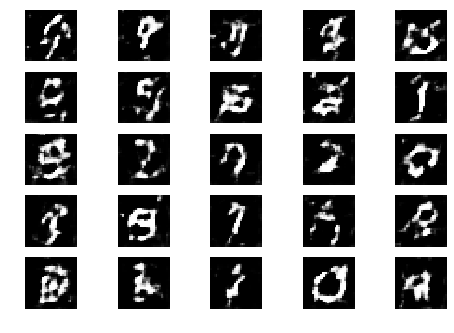

3101 [D loss: 0.999956] [G loss: 1.000056]
3102 [D loss: 0.999958] [G loss: 1.000037]
3103 [D loss: 0.999952] [G loss: 1.000073]
3104 [D loss: 0.999963] [G loss: 1.000065]
3105 [D loss: 0.999948] [G loss: 1.000036]
3106 [D loss: 0.999967] [G loss: 1.000083]
3107 [D loss: 0.999966] [G loss: 1.000059]
3108 [D loss: 0.999968] [G loss: 1.000038]
3109 [D loss: 0.999949] [G loss: 1.000040]
3110 [D loss: 0.999968] [G loss: 1.000075]
3111 [D loss: 0.999978] [G loss: 1.000071]
3112 [D loss: 0.999992] [G loss: 1.000038]
3113 [D loss: 0.999977] [G loss: 1.000029]
3114 [D loss: 0.999980] [G loss: 1.000051]
3115 [D loss: 0.999950] [G loss: 1.000057]
3116 [D loss: 0.999975] [G loss: 1.000083]
3117 [D loss: 0.999954] [G loss: 1.000057]
3118 [D loss: 0.999960] [G loss: 1.000046]
3119 [D loss: 0.999972] [G loss: 1.000072]
3120 [D loss: 0.999948] [G loss: 1.000097]
3121 [D loss: 0.999963] [G loss: 1.000051]
3122 [D loss: 0.999966] [G loss: 1.000063]
3123 [D loss: 0.999968] [G loss: 1.000038]
3124 [D los

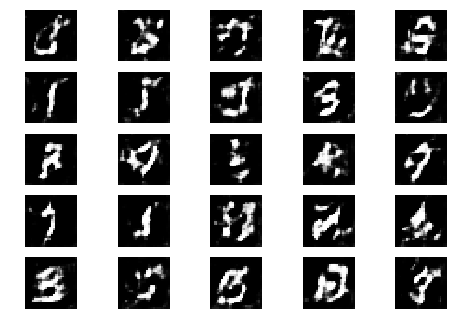

3151 [D loss: 0.999979] [G loss: 1.000064]
3152 [D loss: 0.999975] [G loss: 1.000061]
3153 [D loss: 0.999966] [G loss: 1.000049]
3154 [D loss: 0.999975] [G loss: 1.000065]
3155 [D loss: 0.999971] [G loss: 1.000036]
3156 [D loss: 0.999957] [G loss: 1.000059]
3157 [D loss: 0.999978] [G loss: 1.000064]
3158 [D loss: 0.999972] [G loss: 1.000045]
3159 [D loss: 0.999983] [G loss: 1.000066]
3160 [D loss: 0.999974] [G loss: 1.000057]
3161 [D loss: 0.999964] [G loss: 1.000043]
3162 [D loss: 0.999955] [G loss: 1.000042]
3163 [D loss: 0.999960] [G loss: 1.000033]
3164 [D loss: 0.999971] [G loss: 1.000059]
3165 [D loss: 1.000001] [G loss: 1.000061]
3166 [D loss: 0.999953] [G loss: 1.000064]
3167 [D loss: 0.999962] [G loss: 1.000047]
3168 [D loss: 0.999970] [G loss: 1.000070]
3169 [D loss: 0.999959] [G loss: 1.000077]
3170 [D loss: 0.999963] [G loss: 1.000075]
3171 [D loss: 0.999968] [G loss: 1.000073]
3172 [D loss: 0.999955] [G loss: 1.000072]
3173 [D loss: 0.999947] [G loss: 1.000087]
3174 [D los

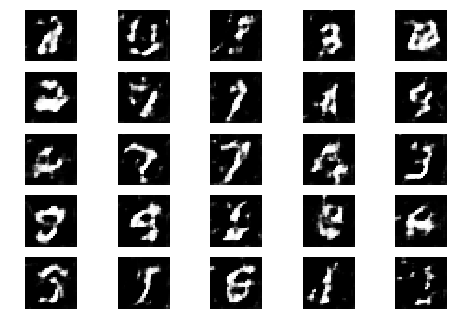

3201 [D loss: 0.999969] [G loss: 1.000039]
3202 [D loss: 0.999964] [G loss: 1.000049]
3203 [D loss: 0.999967] [G loss: 1.000069]
3204 [D loss: 0.999936] [G loss: 1.000076]
3205 [D loss: 0.999975] [G loss: 1.000052]
3206 [D loss: 0.999963] [G loss: 1.000074]
3207 [D loss: 0.999975] [G loss: 1.000039]
3208 [D loss: 0.999969] [G loss: 1.000065]
3209 [D loss: 0.999962] [G loss: 1.000051]
3210 [D loss: 0.999966] [G loss: 1.000074]
3211 [D loss: 0.999975] [G loss: 1.000047]
3212 [D loss: 0.999978] [G loss: 1.000081]
3213 [D loss: 0.999954] [G loss: 1.000063]
3214 [D loss: 0.999962] [G loss: 1.000073]
3215 [D loss: 0.999985] [G loss: 1.000063]
3216 [D loss: 0.999967] [G loss: 1.000064]
3217 [D loss: 0.999975] [G loss: 1.000082]
3218 [D loss: 0.999962] [G loss: 1.000069]
3219 [D loss: 0.999967] [G loss: 1.000080]
3220 [D loss: 0.999982] [G loss: 1.000053]
3221 [D loss: 0.999966] [G loss: 1.000040]
3222 [D loss: 0.999960] [G loss: 1.000073]
3223 [D loss: 0.999958] [G loss: 1.000041]
3224 [D los

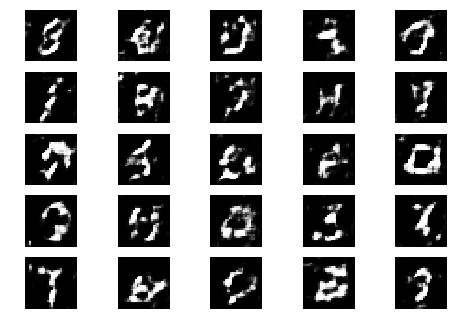

3251 [D loss: 0.999973] [G loss: 1.000072]
3252 [D loss: 0.999964] [G loss: 1.000049]
3253 [D loss: 0.999984] [G loss: 1.000069]
3254 [D loss: 0.999968] [G loss: 1.000059]
3255 [D loss: 0.999971] [G loss: 1.000048]
3256 [D loss: 0.999950] [G loss: 1.000077]
3257 [D loss: 0.999961] [G loss: 1.000025]
3258 [D loss: 0.999961] [G loss: 1.000088]
3259 [D loss: 0.999967] [G loss: 1.000062]
3260 [D loss: 0.999975] [G loss: 1.000033]
3261 [D loss: 0.999963] [G loss: 1.000065]
3262 [D loss: 0.999981] [G loss: 1.000058]
3263 [D loss: 0.999965] [G loss: 1.000041]
3264 [D loss: 0.999956] [G loss: 1.000042]
3265 [D loss: 0.999986] [G loss: 1.000072]
3266 [D loss: 0.999972] [G loss: 1.000073]
3267 [D loss: 0.999963] [G loss: 1.000089]
3268 [D loss: 0.999974] [G loss: 1.000039]
3269 [D loss: 0.999970] [G loss: 1.000073]
3270 [D loss: 0.999975] [G loss: 1.000046]
3271 [D loss: 0.999978] [G loss: 1.000040]
3272 [D loss: 0.999966] [G loss: 1.000088]
3273 [D loss: 0.999957] [G loss: 1.000064]
3274 [D los

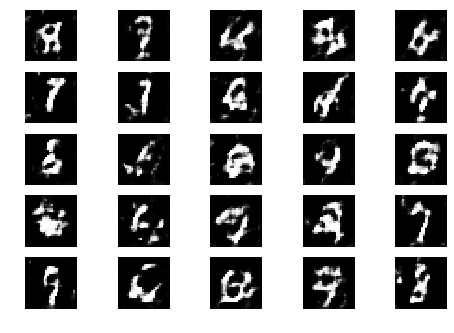

3301 [D loss: 0.999959] [G loss: 1.000044]
3302 [D loss: 0.999975] [G loss: 1.000068]
3303 [D loss: 0.999964] [G loss: 1.000055]
3304 [D loss: 0.999986] [G loss: 1.000074]
3305 [D loss: 0.999972] [G loss: 1.000061]
3306 [D loss: 0.999972] [G loss: 1.000058]
3307 [D loss: 0.999949] [G loss: 1.000051]
3308 [D loss: 0.999967] [G loss: 1.000050]
3309 [D loss: 0.999957] [G loss: 1.000055]
3310 [D loss: 0.999979] [G loss: 1.000056]
3311 [D loss: 0.999957] [G loss: 1.000027]
3312 [D loss: 0.999971] [G loss: 1.000051]
3313 [D loss: 0.999957] [G loss: 1.000042]
3314 [D loss: 0.999961] [G loss: 1.000073]
3315 [D loss: 0.999958] [G loss: 1.000055]
3316 [D loss: 0.999967] [G loss: 1.000065]
3317 [D loss: 0.999989] [G loss: 1.000080]
3318 [D loss: 0.999968] [G loss: 1.000047]
3319 [D loss: 0.999972] [G loss: 1.000042]
3320 [D loss: 0.999968] [G loss: 1.000067]
3321 [D loss: 0.999972] [G loss: 1.000062]
3322 [D loss: 0.999971] [G loss: 1.000043]
3323 [D loss: 0.999952] [G loss: 1.000046]
3324 [D los

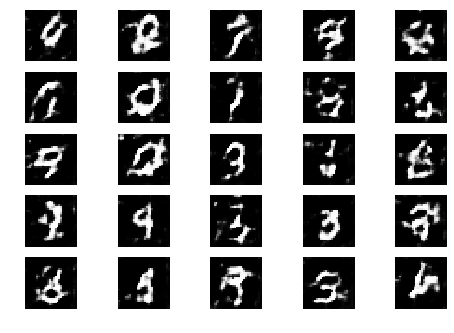

3351 [D loss: 0.999971] [G loss: 1.000068]
3352 [D loss: 0.999974] [G loss: 1.000044]
3353 [D loss: 0.999964] [G loss: 1.000044]
3354 [D loss: 0.999966] [G loss: 1.000057]
3355 [D loss: 0.999956] [G loss: 1.000079]
3356 [D loss: 0.999965] [G loss: 1.000080]
3357 [D loss: 0.999941] [G loss: 1.000054]
3358 [D loss: 0.999971] [G loss: 1.000028]
3359 [D loss: 0.999971] [G loss: 1.000050]
3360 [D loss: 0.999965] [G loss: 1.000055]
3361 [D loss: 0.999952] [G loss: 1.000042]
3362 [D loss: 0.999952] [G loss: 1.000092]
3363 [D loss: 0.999983] [G loss: 1.000053]
3364 [D loss: 0.999985] [G loss: 1.000037]
3365 [D loss: 0.999963] [G loss: 1.000045]
3366 [D loss: 0.999958] [G loss: 1.000045]
3367 [D loss: 0.999961] [G loss: 1.000069]
3368 [D loss: 0.999999] [G loss: 1.000040]
3369 [D loss: 0.999955] [G loss: 1.000085]
3370 [D loss: 0.999975] [G loss: 1.000029]
3371 [D loss: 0.999969] [G loss: 1.000021]
3372 [D loss: 0.999965] [G loss: 1.000051]
3373 [D loss: 0.999955] [G loss: 1.000051]
3374 [D los

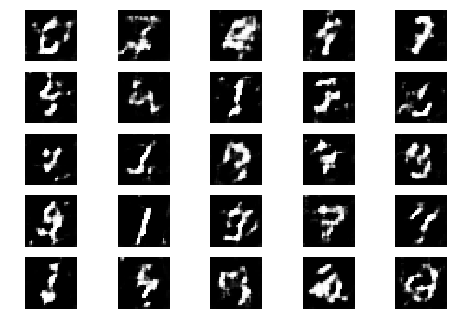

3401 [D loss: 0.999968] [G loss: 1.000047]
3402 [D loss: 0.999960] [G loss: 1.000042]
3403 [D loss: 0.999979] [G loss: 1.000068]
3404 [D loss: 0.999958] [G loss: 1.000047]
3405 [D loss: 0.999979] [G loss: 1.000049]
3406 [D loss: 0.999959] [G loss: 1.000082]
3407 [D loss: 0.999976] [G loss: 1.000083]
3408 [D loss: 0.999965] [G loss: 1.000059]
3409 [D loss: 0.999971] [G loss: 1.000062]
3410 [D loss: 0.999952] [G loss: 1.000056]
3411 [D loss: 0.999984] [G loss: 1.000043]
3412 [D loss: 0.999980] [G loss: 1.000046]
3413 [D loss: 0.999980] [G loss: 1.000044]
3414 [D loss: 0.999967] [G loss: 1.000060]
3415 [D loss: 0.999960] [G loss: 1.000062]
3416 [D loss: 0.999966] [G loss: 1.000033]
3417 [D loss: 0.999967] [G loss: 1.000066]
3418 [D loss: 0.999986] [G loss: 1.000058]
3419 [D loss: 0.999971] [G loss: 1.000044]
3420 [D loss: 0.999986] [G loss: 1.000051]
3421 [D loss: 0.999962] [G loss: 1.000092]
3422 [D loss: 0.999973] [G loss: 1.000079]
3423 [D loss: 0.999969] [G loss: 1.000065]
3424 [D los

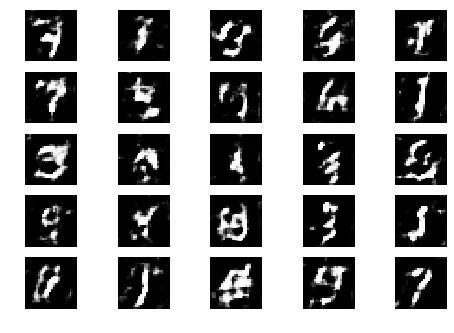

3451 [D loss: 0.999976] [G loss: 1.000057]
3452 [D loss: 0.999962] [G loss: 1.000054]
3453 [D loss: 0.999970] [G loss: 1.000068]
3454 [D loss: 0.999976] [G loss: 1.000045]
3455 [D loss: 0.999973] [G loss: 1.000088]
3456 [D loss: 0.999982] [G loss: 1.000056]
3457 [D loss: 0.999968] [G loss: 1.000074]
3458 [D loss: 0.999983] [G loss: 1.000035]
3459 [D loss: 0.999994] [G loss: 1.000046]
3460 [D loss: 0.999966] [G loss: 1.000056]
3461 [D loss: 0.999957] [G loss: 1.000062]
3462 [D loss: 0.999975] [G loss: 1.000083]
3463 [D loss: 0.999970] [G loss: 1.000078]
3464 [D loss: 0.999964] [G loss: 1.000052]
3465 [D loss: 0.999972] [G loss: 1.000053]
3466 [D loss: 0.999950] [G loss: 1.000059]
3467 [D loss: 0.999974] [G loss: 1.000059]
3468 [D loss: 0.999977] [G loss: 1.000068]
3469 [D loss: 0.999944] [G loss: 1.000075]
3470 [D loss: 0.999971] [G loss: 1.000081]
3471 [D loss: 0.999989] [G loss: 1.000048]
3472 [D loss: 0.999958] [G loss: 1.000082]
3473 [D loss: 0.999960] [G loss: 1.000049]
3474 [D los

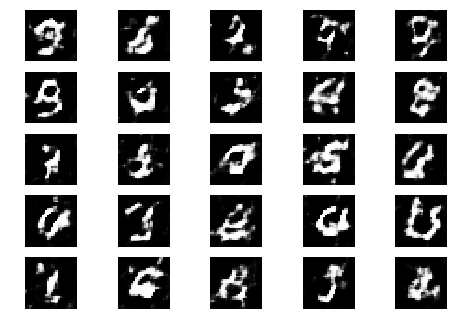

3501 [D loss: 0.999968] [G loss: 1.000055]
3502 [D loss: 0.999979] [G loss: 1.000049]
3503 [D loss: 0.999975] [G loss: 1.000042]
3504 [D loss: 0.999973] [G loss: 1.000053]
3505 [D loss: 0.999960] [G loss: 1.000065]
3506 [D loss: 0.999960] [G loss: 1.000062]
3507 [D loss: 0.999953] [G loss: 1.000048]
3508 [D loss: 0.999973] [G loss: 1.000070]
3509 [D loss: 0.999973] [G loss: 1.000030]
3510 [D loss: 0.999963] [G loss: 1.000036]
3511 [D loss: 0.999967] [G loss: 1.000050]
3512 [D loss: 0.999981] [G loss: 1.000046]
3513 [D loss: 0.999964] [G loss: 1.000047]
3514 [D loss: 0.999976] [G loss: 1.000047]
3515 [D loss: 0.999978] [G loss: 1.000046]
3516 [D loss: 0.999982] [G loss: 1.000054]
3517 [D loss: 0.999972] [G loss: 1.000051]
3518 [D loss: 0.999970] [G loss: 1.000055]
3519 [D loss: 0.999974] [G loss: 1.000095]
3520 [D loss: 0.999973] [G loss: 1.000082]
3521 [D loss: 0.999974] [G loss: 1.000058]
3522 [D loss: 0.999983] [G loss: 1.000062]
3523 [D loss: 0.999972] [G loss: 1.000056]
3524 [D los

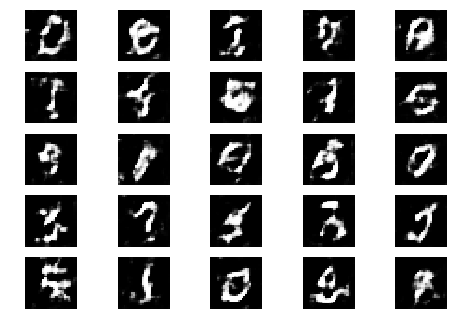

3551 [D loss: 0.999965] [G loss: 1.000048]
3552 [D loss: 0.999975] [G loss: 1.000013]
3553 [D loss: 0.999983] [G loss: 1.000086]
3554 [D loss: 0.999978] [G loss: 1.000074]
3555 [D loss: 0.999964] [G loss: 1.000062]
3556 [D loss: 0.999996] [G loss: 1.000052]
3557 [D loss: 0.999978] [G loss: 1.000066]
3558 [D loss: 0.999969] [G loss: 1.000056]
3559 [D loss: 0.999966] [G loss: 1.000073]
3560 [D loss: 0.999972] [G loss: 1.000073]
3561 [D loss: 0.999965] [G loss: 1.000073]
3562 [D loss: 0.999960] [G loss: 1.000079]
3563 [D loss: 0.999972] [G loss: 1.000068]
3564 [D loss: 0.999959] [G loss: 1.000064]
3565 [D loss: 0.999972] [G loss: 1.000053]
3566 [D loss: 0.999964] [G loss: 1.000056]
3567 [D loss: 0.999963] [G loss: 1.000047]
3568 [D loss: 0.999964] [G loss: 1.000053]
3569 [D loss: 0.999957] [G loss: 1.000042]
3570 [D loss: 0.999973] [G loss: 1.000052]
3571 [D loss: 0.999947] [G loss: 1.000057]
3572 [D loss: 0.999955] [G loss: 1.000063]
3573 [D loss: 0.999999] [G loss: 1.000077]
3574 [D los

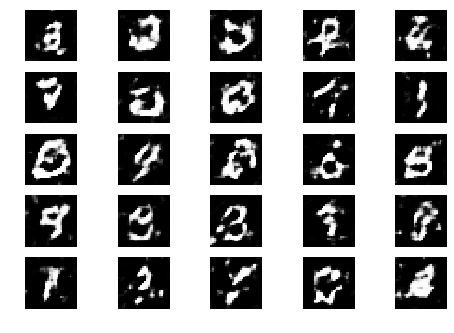

3601 [D loss: 0.999973] [G loss: 1.000058]
3602 [D loss: 0.999966] [G loss: 1.000082]
3603 [D loss: 0.999944] [G loss: 1.000058]
3604 [D loss: 0.999986] [G loss: 1.000051]
3605 [D loss: 0.999981] [G loss: 1.000067]
3606 [D loss: 0.999977] [G loss: 1.000076]
3607 [D loss: 0.999965] [G loss: 1.000066]
3608 [D loss: 0.999973] [G loss: 1.000033]
3609 [D loss: 0.999964] [G loss: 1.000019]
3610 [D loss: 0.999960] [G loss: 1.000047]
3611 [D loss: 0.999977] [G loss: 1.000055]
3612 [D loss: 0.999961] [G loss: 1.000072]
3613 [D loss: 0.999956] [G loss: 1.000055]
3614 [D loss: 0.999974] [G loss: 1.000046]
3615 [D loss: 0.999962] [G loss: 1.000067]
3616 [D loss: 0.999971] [G loss: 1.000067]
3617 [D loss: 0.999976] [G loss: 1.000082]
3618 [D loss: 0.999980] [G loss: 1.000035]
3619 [D loss: 0.999996] [G loss: 1.000071]
3620 [D loss: 0.999968] [G loss: 1.000007]
3621 [D loss: 0.999968] [G loss: 1.000067]
3622 [D loss: 0.999957] [G loss: 1.000054]
3623 [D loss: 0.999952] [G loss: 1.000071]
3624 [D los

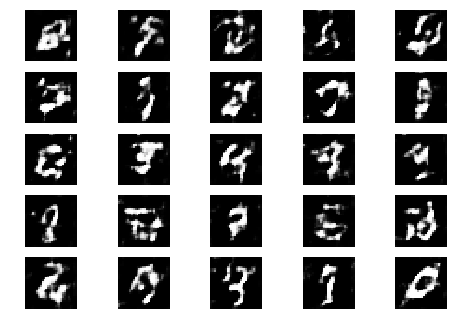

3651 [D loss: 0.999951] [G loss: 1.000071]
3652 [D loss: 0.999986] [G loss: 1.000060]
3653 [D loss: 0.999958] [G loss: 1.000066]
3654 [D loss: 0.999963] [G loss: 1.000039]
3655 [D loss: 0.999959] [G loss: 1.000077]
3656 [D loss: 0.999960] [G loss: 1.000019]
3657 [D loss: 0.999958] [G loss: 1.000051]
3658 [D loss: 0.999963] [G loss: 1.000061]
3659 [D loss: 0.999977] [G loss: 1.000074]
3660 [D loss: 0.999960] [G loss: 1.000093]
3661 [D loss: 0.999954] [G loss: 1.000030]
3662 [D loss: 0.999961] [G loss: 1.000094]
3663 [D loss: 0.999979] [G loss: 1.000064]
3664 [D loss: 0.999948] [G loss: 1.000060]
3665 [D loss: 0.999961] [G loss: 1.000089]
3666 [D loss: 0.999974] [G loss: 1.000040]
3667 [D loss: 0.999969] [G loss: 1.000085]
3668 [D loss: 0.999986] [G loss: 1.000064]
3669 [D loss: 0.999981] [G loss: 1.000037]
3670 [D loss: 0.999972] [G loss: 1.000046]
3671 [D loss: 0.999971] [G loss: 1.000079]
3672 [D loss: 0.999962] [G loss: 1.000067]
3673 [D loss: 0.999948] [G loss: 1.000075]
3674 [D los

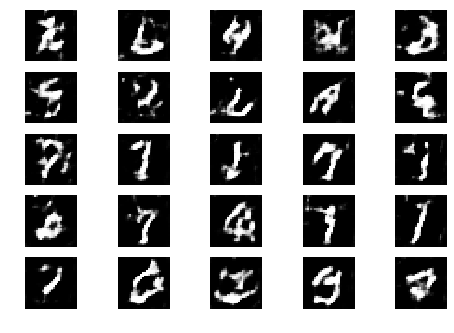

3701 [D loss: 0.999989] [G loss: 1.000044]
3702 [D loss: 0.999980] [G loss: 1.000038]
3703 [D loss: 0.999979] [G loss: 1.000072]
3704 [D loss: 0.999977] [G loss: 1.000053]
3705 [D loss: 0.999977] [G loss: 1.000051]
3706 [D loss: 0.999955] [G loss: 1.000046]
3707 [D loss: 0.999958] [G loss: 1.000059]
3708 [D loss: 0.999953] [G loss: 1.000052]
3709 [D loss: 0.999949] [G loss: 1.000079]
3710 [D loss: 0.999984] [G loss: 1.000054]
3711 [D loss: 0.999952] [G loss: 1.000080]
3712 [D loss: 0.999985] [G loss: 1.000055]
3713 [D loss: 0.999977] [G loss: 1.000046]
3714 [D loss: 0.999979] [G loss: 1.000042]
3715 [D loss: 0.999953] [G loss: 1.000064]
3716 [D loss: 0.999984] [G loss: 1.000033]
3717 [D loss: 0.999966] [G loss: 1.000056]
3718 [D loss: 0.999963] [G loss: 1.000076]
3719 [D loss: 0.999963] [G loss: 1.000048]
3720 [D loss: 0.999967] [G loss: 1.000087]
3721 [D loss: 0.999959] [G loss: 1.000061]
3722 [D loss: 0.999965] [G loss: 1.000055]
3723 [D loss: 0.999980] [G loss: 1.000055]
3724 [D los

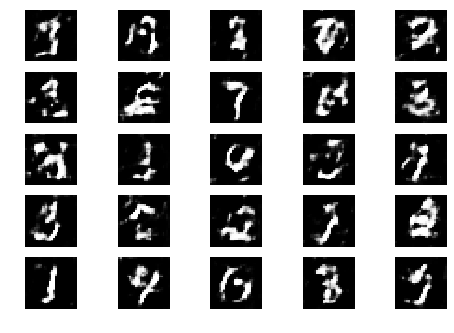

3751 [D loss: 0.999980] [G loss: 1.000048]
3752 [D loss: 0.999958] [G loss: 1.000062]
3753 [D loss: 0.999953] [G loss: 1.000079]
3754 [D loss: 0.999962] [G loss: 1.000035]
3755 [D loss: 0.999965] [G loss: 1.000037]
3756 [D loss: 0.999964] [G loss: 1.000047]
3757 [D loss: 0.999973] [G loss: 1.000074]
3758 [D loss: 0.999962] [G loss: 1.000059]
3759 [D loss: 0.999969] [G loss: 1.000049]
3760 [D loss: 0.999945] [G loss: 1.000056]
3761 [D loss: 0.999956] [G loss: 1.000058]
3762 [D loss: 0.999985] [G loss: 1.000044]
3763 [D loss: 0.999974] [G loss: 1.000067]
3764 [D loss: 0.999972] [G loss: 1.000086]
3765 [D loss: 0.999970] [G loss: 1.000041]
3766 [D loss: 0.999982] [G loss: 1.000058]
3767 [D loss: 0.999989] [G loss: 1.000047]
3768 [D loss: 0.999955] [G loss: 1.000066]
3769 [D loss: 0.999960] [G loss: 1.000065]
3770 [D loss: 0.999974] [G loss: 1.000058]
3771 [D loss: 0.999953] [G loss: 1.000041]
3772 [D loss: 0.999954] [G loss: 1.000064]
3773 [D loss: 0.999987] [G loss: 1.000049]
3774 [D los

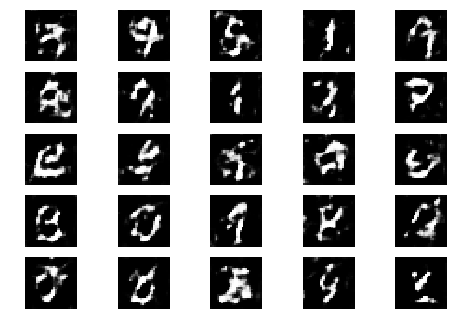

3801 [D loss: 0.999985] [G loss: 1.000065]
3802 [D loss: 0.999968] [G loss: 1.000075]
3803 [D loss: 0.999967] [G loss: 1.000053]
3804 [D loss: 0.999963] [G loss: 1.000071]
3805 [D loss: 0.999960] [G loss: 1.000048]
3806 [D loss: 0.999959] [G loss: 1.000054]
3807 [D loss: 0.999969] [G loss: 1.000068]
3808 [D loss: 0.999950] [G loss: 1.000061]
3809 [D loss: 0.999971] [G loss: 1.000085]
3810 [D loss: 0.999974] [G loss: 1.000036]
3811 [D loss: 0.999967] [G loss: 1.000032]
3812 [D loss: 0.999962] [G loss: 1.000058]
3813 [D loss: 0.999972] [G loss: 1.000059]
3814 [D loss: 0.999943] [G loss: 1.000073]
3815 [D loss: 0.999971] [G loss: 1.000068]
3816 [D loss: 0.999976] [G loss: 1.000021]
3817 [D loss: 0.999965] [G loss: 1.000066]
3818 [D loss: 0.999959] [G loss: 1.000089]
3819 [D loss: 0.999977] [G loss: 1.000039]
3820 [D loss: 0.999972] [G loss: 1.000058]
3821 [D loss: 0.999961] [G loss: 1.000055]
3822 [D loss: 0.999958] [G loss: 1.000056]
3823 [D loss: 0.999961] [G loss: 1.000060]
3824 [D los

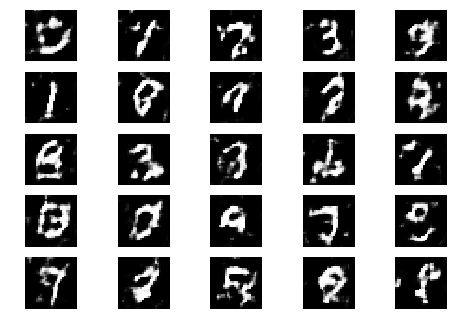

3851 [D loss: 0.999974] [G loss: 1.000063]
3852 [D loss: 0.999965] [G loss: 1.000063]
3853 [D loss: 0.999963] [G loss: 1.000059]
3854 [D loss: 0.999956] [G loss: 1.000070]
3855 [D loss: 0.999967] [G loss: 1.000072]
3856 [D loss: 0.999980] [G loss: 1.000061]
3857 [D loss: 0.999975] [G loss: 1.000057]
3858 [D loss: 0.999959] [G loss: 1.000068]
3859 [D loss: 0.999953] [G loss: 1.000067]
3860 [D loss: 0.999972] [G loss: 1.000059]
3861 [D loss: 0.999976] [G loss: 1.000074]
3862 [D loss: 0.999956] [G loss: 1.000065]
3863 [D loss: 0.999968] [G loss: 1.000044]
3864 [D loss: 0.999973] [G loss: 1.000056]
3865 [D loss: 0.999970] [G loss: 1.000057]
3866 [D loss: 0.999963] [G loss: 1.000059]
3867 [D loss: 0.999974] [G loss: 1.000063]
3868 [D loss: 0.999956] [G loss: 1.000079]
3869 [D loss: 0.999946] [G loss: 1.000074]
3870 [D loss: 0.999960] [G loss: 1.000055]
3871 [D loss: 0.999971] [G loss: 1.000062]
3872 [D loss: 0.999957] [G loss: 1.000044]
3873 [D loss: 0.999984] [G loss: 1.000083]
3874 [D los

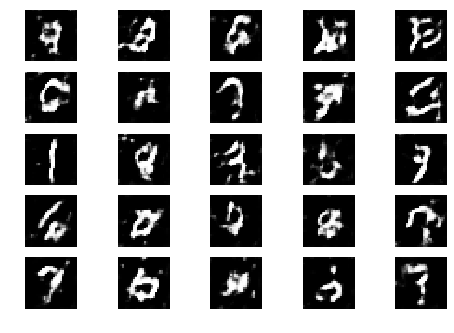

3901 [D loss: 0.999965] [G loss: 1.000058]
3902 [D loss: 0.999963] [G loss: 1.000086]
3903 [D loss: 0.999986] [G loss: 1.000046]
3904 [D loss: 0.999965] [G loss: 1.000041]
3905 [D loss: 0.999960] [G loss: 1.000068]
3906 [D loss: 0.999969] [G loss: 1.000063]
3907 [D loss: 0.999967] [G loss: 1.000050]
3908 [D loss: 0.999993] [G loss: 1.000036]
3909 [D loss: 0.999954] [G loss: 1.000059]
3910 [D loss: 0.999967] [G loss: 1.000060]
3911 [D loss: 0.999980] [G loss: 1.000061]
3912 [D loss: 0.999970] [G loss: 1.000047]
3913 [D loss: 0.999974] [G loss: 1.000048]
3914 [D loss: 0.999986] [G loss: 1.000026]
3915 [D loss: 0.999955] [G loss: 1.000054]
3916 [D loss: 0.999953] [G loss: 1.000065]
3917 [D loss: 0.999979] [G loss: 1.000052]
3918 [D loss: 0.999971] [G loss: 1.000074]
3919 [D loss: 0.999978] [G loss: 1.000053]
3920 [D loss: 0.999932] [G loss: 1.000041]
3921 [D loss: 0.999988] [G loss: 1.000061]
3922 [D loss: 0.999963] [G loss: 1.000046]
3923 [D loss: 0.999974] [G loss: 1.000067]
3924 [D los

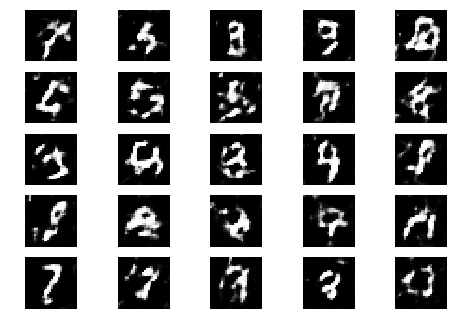

3951 [D loss: 0.999975] [G loss: 1.000063]
3952 [D loss: 0.999958] [G loss: 1.000061]
3953 [D loss: 0.999987] [G loss: 1.000056]
3954 [D loss: 0.999959] [G loss: 1.000058]
3955 [D loss: 0.999977] [G loss: 1.000097]
3956 [D loss: 0.999968] [G loss: 1.000034]
3957 [D loss: 0.999976] [G loss: 1.000049]
3958 [D loss: 0.999970] [G loss: 1.000047]
3959 [D loss: 0.999963] [G loss: 1.000042]
3960 [D loss: 0.999983] [G loss: 1.000028]
3961 [D loss: 0.999975] [G loss: 1.000047]
3962 [D loss: 0.999958] [G loss: 1.000062]
3963 [D loss: 0.999955] [G loss: 1.000056]
3964 [D loss: 0.999950] [G loss: 1.000080]
3965 [D loss: 0.999948] [G loss: 1.000066]
3966 [D loss: 0.999982] [G loss: 1.000064]
3967 [D loss: 0.999961] [G loss: 1.000068]
3968 [D loss: 0.999956] [G loss: 1.000054]
3969 [D loss: 0.999980] [G loss: 1.000061]
3970 [D loss: 0.999970] [G loss: 1.000049]
3971 [D loss: 0.999973] [G loss: 1.000079]
3972 [D loss: 0.999958] [G loss: 1.000070]
3973 [D loss: 0.999983] [G loss: 1.000085]
3974 [D los

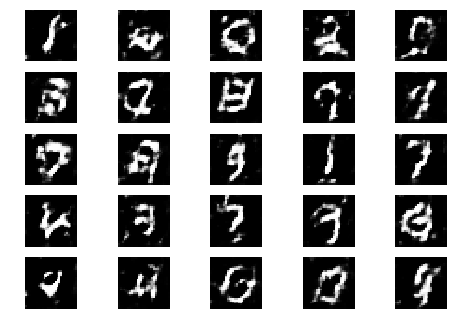

4001 [D loss: 0.999962] [G loss: 1.000060]
4002 [D loss: 0.999967] [G loss: 1.000070]
4003 [D loss: 0.999952] [G loss: 1.000087]
4004 [D loss: 0.999972] [G loss: 1.000048]
4005 [D loss: 0.999966] [G loss: 1.000041]
4006 [D loss: 0.999963] [G loss: 1.000061]
4007 [D loss: 0.999970] [G loss: 1.000054]
4008 [D loss: 0.999967] [G loss: 1.000047]
4009 [D loss: 0.999972] [G loss: 1.000066]
4010 [D loss: 0.999978] [G loss: 1.000073]
4011 [D loss: 0.999970] [G loss: 1.000072]
4012 [D loss: 0.999974] [G loss: 1.000043]
4013 [D loss: 0.999958] [G loss: 1.000038]
4014 [D loss: 0.999976] [G loss: 1.000081]
4015 [D loss: 0.999952] [G loss: 1.000045]
4016 [D loss: 0.999973] [G loss: 1.000080]
4017 [D loss: 0.999959] [G loss: 1.000062]
4018 [D loss: 0.999959] [G loss: 1.000057]
4019 [D loss: 0.999950] [G loss: 1.000070]
4020 [D loss: 0.999956] [G loss: 1.000069]
4021 [D loss: 0.999959] [G loss: 1.000044]
4022 [D loss: 0.999975] [G loss: 1.000055]
4023 [D loss: 0.999967] [G loss: 1.000062]
4024 [D los

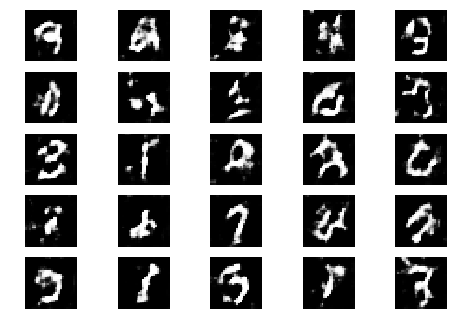

4051 [D loss: 0.999988] [G loss: 1.000065]
4052 [D loss: 0.999975] [G loss: 1.000039]
4053 [D loss: 0.999968] [G loss: 1.000059]
4054 [D loss: 0.999963] [G loss: 1.000076]
4055 [D loss: 0.999958] [G loss: 1.000067]
4056 [D loss: 0.999976] [G loss: 1.000073]
4057 [D loss: 0.999973] [G loss: 1.000062]
4058 [D loss: 0.999988] [G loss: 1.000057]
4059 [D loss: 0.999972] [G loss: 1.000081]
4060 [D loss: 0.999962] [G loss: 1.000052]
4061 [D loss: 0.999963] [G loss: 1.000061]
4062 [D loss: 0.999980] [G loss: 1.000055]
4063 [D loss: 0.999975] [G loss: 1.000056]
4064 [D loss: 0.999935] [G loss: 1.000070]
4065 [D loss: 0.999960] [G loss: 1.000082]
4066 [D loss: 0.999977] [G loss: 1.000052]
4067 [D loss: 0.999965] [G loss: 1.000076]
4068 [D loss: 0.999946] [G loss: 1.000062]
4069 [D loss: 0.999966] [G loss: 1.000050]
4070 [D loss: 0.999980] [G loss: 1.000068]
4071 [D loss: 0.999985] [G loss: 1.000061]
4072 [D loss: 0.999972] [G loss: 1.000064]
4073 [D loss: 0.999973] [G loss: 1.000042]
4074 [D los

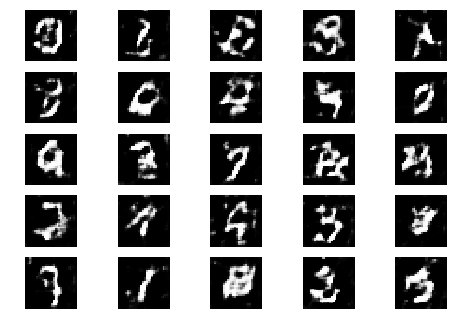

4101 [D loss: 0.999981] [G loss: 1.000055]
4102 [D loss: 0.999969] [G loss: 1.000069]
4103 [D loss: 0.999963] [G loss: 1.000052]
4104 [D loss: 0.999969] [G loss: 1.000066]
4105 [D loss: 0.999971] [G loss: 1.000058]
4106 [D loss: 0.999960] [G loss: 1.000088]
4107 [D loss: 0.999984] [G loss: 1.000096]
4108 [D loss: 0.999980] [G loss: 1.000054]
4109 [D loss: 0.999976] [G loss: 1.000088]
4110 [D loss: 0.999977] [G loss: 1.000067]
4111 [D loss: 0.999964] [G loss: 1.000064]
4112 [D loss: 0.999980] [G loss: 1.000039]
4113 [D loss: 0.999963] [G loss: 1.000064]
4114 [D loss: 0.999956] [G loss: 1.000064]
4115 [D loss: 0.999978] [G loss: 1.000057]
4116 [D loss: 0.999955] [G loss: 1.000053]
4117 [D loss: 0.999965] [G loss: 1.000070]
4118 [D loss: 0.999985] [G loss: 1.000069]
4119 [D loss: 0.999959] [G loss: 1.000080]
4120 [D loss: 0.999957] [G loss: 1.000055]
4121 [D loss: 0.999958] [G loss: 1.000071]
4122 [D loss: 0.999970] [G loss: 1.000057]
4123 [D loss: 0.999957] [G loss: 1.000056]
4124 [D los

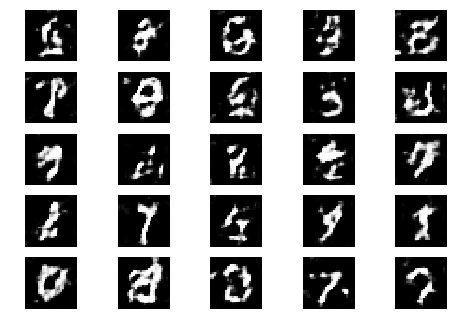

4151 [D loss: 0.999959] [G loss: 1.000045]
4152 [D loss: 0.999974] [G loss: 1.000062]
4153 [D loss: 0.999944] [G loss: 1.000070]
4154 [D loss: 0.999969] [G loss: 1.000059]
4155 [D loss: 0.999969] [G loss: 1.000052]
4156 [D loss: 0.999960] [G loss: 1.000067]
4157 [D loss: 0.999963] [G loss: 1.000073]
4158 [D loss: 0.999958] [G loss: 1.000047]
4159 [D loss: 0.999969] [G loss: 1.000087]
4160 [D loss: 0.999955] [G loss: 1.000075]
4161 [D loss: 0.999969] [G loss: 1.000082]
4162 [D loss: 0.999976] [G loss: 1.000078]
4163 [D loss: 0.999982] [G loss: 1.000087]
4164 [D loss: 0.999959] [G loss: 1.000073]
4165 [D loss: 0.999967] [G loss: 1.000076]
4166 [D loss: 0.999982] [G loss: 1.000074]
4167 [D loss: 0.999962] [G loss: 1.000086]
4168 [D loss: 0.999982] [G loss: 1.000040]
4169 [D loss: 0.999969] [G loss: 1.000041]
4170 [D loss: 0.999947] [G loss: 1.000054]
4171 [D loss: 0.999968] [G loss: 1.000040]
4172 [D loss: 0.999969] [G loss: 1.000049]
4173 [D loss: 0.999958] [G loss: 1.000049]
4174 [D los

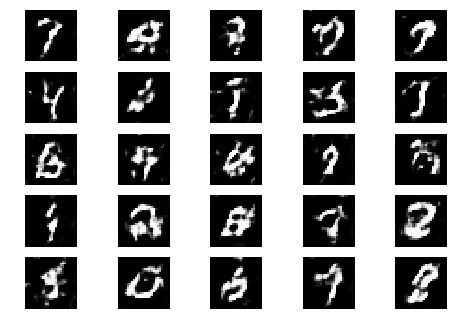

4201 [D loss: 0.999952] [G loss: 1.000057]
4202 [D loss: 0.999985] [G loss: 1.000075]
4203 [D loss: 0.999969] [G loss: 1.000090]
4204 [D loss: 0.999979] [G loss: 1.000049]
4205 [D loss: 0.999966] [G loss: 1.000059]
4206 [D loss: 0.999966] [G loss: 1.000062]
4207 [D loss: 0.999984] [G loss: 1.000055]
4208 [D loss: 0.999959] [G loss: 1.000039]
4209 [D loss: 0.999967] [G loss: 1.000062]
4210 [D loss: 0.999948] [G loss: 1.000066]
4211 [D loss: 0.999980] [G loss: 1.000072]
4212 [D loss: 0.999967] [G loss: 1.000075]
4213 [D loss: 0.999976] [G loss: 1.000059]
4214 [D loss: 0.999948] [G loss: 1.000082]
4215 [D loss: 0.999962] [G loss: 1.000041]
4216 [D loss: 0.999971] [G loss: 1.000041]
4217 [D loss: 0.999983] [G loss: 1.000058]
4218 [D loss: 0.999988] [G loss: 1.000080]
4219 [D loss: 0.999967] [G loss: 1.000100]
4220 [D loss: 0.999958] [G loss: 1.000055]
4221 [D loss: 0.999961] [G loss: 1.000055]
4222 [D loss: 0.999952] [G loss: 1.000050]
4223 [D loss: 0.999974] [G loss: 1.000042]
4224 [D los

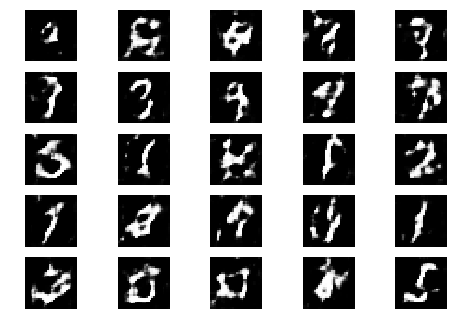

4251 [D loss: 0.999964] [G loss: 1.000044]
4252 [D loss: 0.999974] [G loss: 1.000055]
4253 [D loss: 0.999956] [G loss: 1.000072]
4254 [D loss: 0.999977] [G loss: 1.000043]
4255 [D loss: 0.999965] [G loss: 1.000057]
4256 [D loss: 0.999963] [G loss: 1.000057]
4257 [D loss: 0.999950] [G loss: 1.000057]
4258 [D loss: 0.999967] [G loss: 1.000054]
4259 [D loss: 0.999975] [G loss: 1.000045]
4260 [D loss: 0.999971] [G loss: 1.000052]
4261 [D loss: 0.999970] [G loss: 1.000061]
4262 [D loss: 0.999964] [G loss: 1.000068]
4263 [D loss: 0.999962] [G loss: 1.000052]
4264 [D loss: 0.999979] [G loss: 1.000064]
4265 [D loss: 0.999947] [G loss: 1.000078]
4266 [D loss: 0.999963] [G loss: 1.000051]
4267 [D loss: 0.999984] [G loss: 1.000051]
4268 [D loss: 0.999969] [G loss: 1.000069]
4269 [D loss: 0.999958] [G loss: 1.000073]
4270 [D loss: 0.999975] [G loss: 1.000072]
4271 [D loss: 0.999964] [G loss: 1.000073]
4272 [D loss: 0.999976] [G loss: 1.000062]
4273 [D loss: 0.999965] [G loss: 1.000068]
4274 [D los

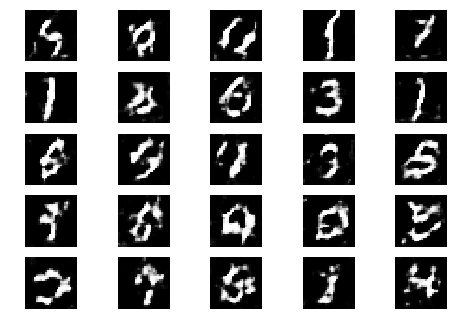

4301 [D loss: 0.999959] [G loss: 1.000060]
4302 [D loss: 0.999980] [G loss: 1.000054]
4303 [D loss: 0.999968] [G loss: 1.000055]
4304 [D loss: 0.999972] [G loss: 1.000064]
4305 [D loss: 0.999980] [G loss: 1.000068]
4306 [D loss: 0.999968] [G loss: 1.000068]
4307 [D loss: 0.999966] [G loss: 1.000038]
4308 [D loss: 0.999967] [G loss: 1.000028]
4309 [D loss: 0.999973] [G loss: 1.000028]
4310 [D loss: 0.999950] [G loss: 1.000061]
4311 [D loss: 0.999964] [G loss: 1.000050]
4312 [D loss: 0.999954] [G loss: 1.000073]
4313 [D loss: 0.999950] [G loss: 1.000057]
4314 [D loss: 0.999955] [G loss: 1.000081]
4315 [D loss: 0.999955] [G loss: 1.000067]
4316 [D loss: 0.999963] [G loss: 1.000070]
4317 [D loss: 0.999986] [G loss: 1.000055]
4318 [D loss: 0.999974] [G loss: 1.000078]
4319 [D loss: 0.999961] [G loss: 1.000050]
4320 [D loss: 0.999968] [G loss: 1.000054]
4321 [D loss: 0.999965] [G loss: 1.000038]
4322 [D loss: 0.999962] [G loss: 1.000072]
4323 [D loss: 0.999961] [G loss: 1.000069]
4324 [D los

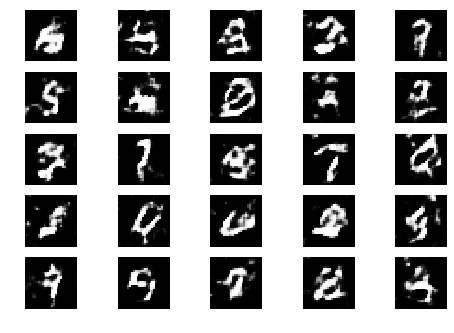

4351 [D loss: 0.999963] [G loss: 1.000047]
4352 [D loss: 0.999976] [G loss: 1.000061]
4353 [D loss: 0.999970] [G loss: 1.000093]
4354 [D loss: 0.999981] [G loss: 1.000069]
4355 [D loss: 0.999970] [G loss: 1.000074]
4356 [D loss: 0.999990] [G loss: 1.000061]
4357 [D loss: 0.999973] [G loss: 1.000086]
4358 [D loss: 0.999965] [G loss: 1.000048]
4359 [D loss: 0.999971] [G loss: 1.000055]
4360 [D loss: 0.999969] [G loss: 1.000067]
4361 [D loss: 0.999961] [G loss: 1.000067]
4362 [D loss: 0.999957] [G loss: 1.000067]
4363 [D loss: 0.999972] [G loss: 1.000081]
4364 [D loss: 0.999962] [G loss: 1.000084]
4365 [D loss: 0.999965] [G loss: 1.000049]
4366 [D loss: 0.999970] [G loss: 1.000082]
4367 [D loss: 0.999957] [G loss: 1.000055]
4368 [D loss: 0.999963] [G loss: 1.000047]
4369 [D loss: 0.999957] [G loss: 1.000081]
4370 [D loss: 0.999983] [G loss: 1.000065]
4371 [D loss: 0.999965] [G loss: 1.000076]
4372 [D loss: 0.999963] [G loss: 1.000054]
4373 [D loss: 0.999968] [G loss: 1.000034]
4374 [D los

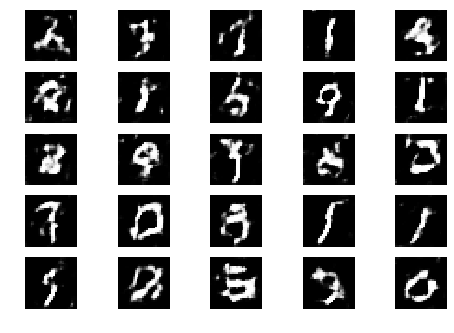

4401 [D loss: 0.999972] [G loss: 1.000039]
4402 [D loss: 0.999981] [G loss: 1.000040]
4403 [D loss: 0.999982] [G loss: 1.000041]
4404 [D loss: 0.999953] [G loss: 1.000052]
4405 [D loss: 0.999969] [G loss: 1.000042]
4406 [D loss: 0.999978] [G loss: 1.000048]
4407 [D loss: 0.999951] [G loss: 1.000066]
4408 [D loss: 0.999972] [G loss: 1.000028]
4409 [D loss: 0.999964] [G loss: 1.000042]
4410 [D loss: 0.999954] [G loss: 1.000055]
4411 [D loss: 0.999970] [G loss: 1.000074]
4412 [D loss: 0.999977] [G loss: 1.000065]
4413 [D loss: 0.999958] [G loss: 1.000061]
4414 [D loss: 0.999950] [G loss: 1.000044]
4415 [D loss: 0.999964] [G loss: 1.000068]
4416 [D loss: 0.999962] [G loss: 1.000090]
4417 [D loss: 0.999958] [G loss: 1.000074]
4418 [D loss: 0.999979] [G loss: 1.000051]
4419 [D loss: 0.999967] [G loss: 1.000071]
4420 [D loss: 0.999983] [G loss: 1.000053]
4421 [D loss: 0.999969] [G loss: 1.000068]
4422 [D loss: 0.999962] [G loss: 1.000052]
4423 [D loss: 0.999971] [G loss: 1.000035]
4424 [D los

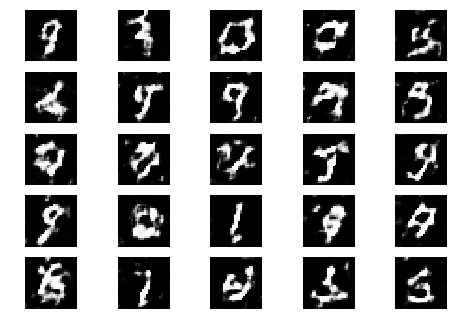

4451 [D loss: 0.999977] [G loss: 1.000076]
4452 [D loss: 0.999974] [G loss: 1.000046]
4453 [D loss: 0.999970] [G loss: 1.000082]
4454 [D loss: 0.999961] [G loss: 1.000079]
4455 [D loss: 0.999969] [G loss: 1.000052]
4456 [D loss: 0.999981] [G loss: 1.000049]
4457 [D loss: 0.999952] [G loss: 1.000069]
4458 [D loss: 0.999952] [G loss: 1.000044]
4459 [D loss: 0.999965] [G loss: 1.000049]
4460 [D loss: 0.999956] [G loss: 1.000075]
4461 [D loss: 0.999968] [G loss: 1.000056]
4462 [D loss: 0.999973] [G loss: 1.000061]
4463 [D loss: 0.999964] [G loss: 1.000075]
4464 [D loss: 0.999966] [G loss: 1.000066]
4465 [D loss: 0.999960] [G loss: 1.000057]
4466 [D loss: 0.999962] [G loss: 1.000073]
4467 [D loss: 0.999988] [G loss: 1.000034]
4468 [D loss: 0.999970] [G loss: 1.000046]
4469 [D loss: 0.999966] [G loss: 1.000053]
4470 [D loss: 0.999969] [G loss: 1.000048]
4471 [D loss: 0.999968] [G loss: 1.000059]
4472 [D loss: 0.999964] [G loss: 1.000062]
4473 [D loss: 0.999963] [G loss: 1.000045]
4474 [D los

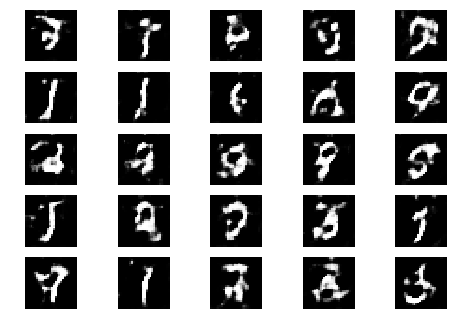

4501 [D loss: 0.999966] [G loss: 1.000061]
4502 [D loss: 0.999939] [G loss: 1.000055]
4503 [D loss: 0.999983] [G loss: 1.000073]
4504 [D loss: 0.999961] [G loss: 1.000055]
4505 [D loss: 0.999967] [G loss: 1.000068]
4506 [D loss: 0.999983] [G loss: 1.000046]
4507 [D loss: 0.999969] [G loss: 1.000057]
4508 [D loss: 0.999976] [G loss: 1.000061]
4509 [D loss: 0.999964] [G loss: 1.000062]
4510 [D loss: 0.999969] [G loss: 1.000064]
4511 [D loss: 0.999986] [G loss: 1.000077]
4512 [D loss: 0.999962] [G loss: 1.000066]
4513 [D loss: 0.999969] [G loss: 1.000061]
4514 [D loss: 0.999959] [G loss: 1.000060]
4515 [D loss: 0.999960] [G loss: 1.000058]
4516 [D loss: 0.999956] [G loss: 1.000069]
4517 [D loss: 0.999976] [G loss: 1.000069]
4518 [D loss: 0.999993] [G loss: 1.000074]
4519 [D loss: 0.999961] [G loss: 1.000073]
4520 [D loss: 0.999970] [G loss: 1.000075]
4521 [D loss: 0.999973] [G loss: 1.000071]
4522 [D loss: 0.999977] [G loss: 1.000028]
4523 [D loss: 0.999971] [G loss: 1.000077]
4524 [D los

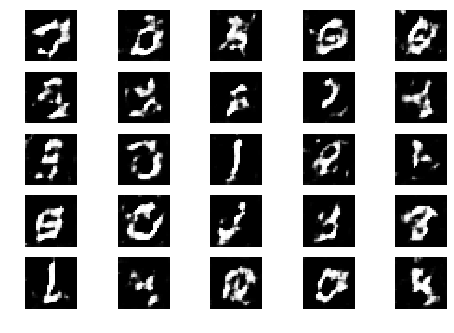

4551 [D loss: 0.999969] [G loss: 1.000071]
4552 [D loss: 0.999965] [G loss: 1.000065]
4553 [D loss: 0.999964] [G loss: 1.000072]
4554 [D loss: 0.999978] [G loss: 1.000058]
4555 [D loss: 0.999965] [G loss: 1.000058]
4556 [D loss: 0.999962] [G loss: 1.000068]
4557 [D loss: 0.999980] [G loss: 1.000073]
4558 [D loss: 0.999951] [G loss: 1.000065]
4559 [D loss: 0.999965] [G loss: 1.000043]
4560 [D loss: 0.999971] [G loss: 1.000056]
4561 [D loss: 0.999950] [G loss: 1.000061]
4562 [D loss: 0.999969] [G loss: 1.000049]
4563 [D loss: 0.999954] [G loss: 1.000030]
4564 [D loss: 0.999973] [G loss: 1.000055]
4565 [D loss: 0.999971] [G loss: 1.000072]
4566 [D loss: 0.999961] [G loss: 1.000072]
4567 [D loss: 0.999965] [G loss: 1.000064]
4568 [D loss: 0.999969] [G loss: 1.000078]
4569 [D loss: 0.999956] [G loss: 1.000076]
4570 [D loss: 0.999954] [G loss: 1.000049]
4571 [D loss: 0.999958] [G loss: 1.000082]
4572 [D loss: 0.999950] [G loss: 1.000085]
4573 [D loss: 0.999971] [G loss: 1.000091]
4574 [D los

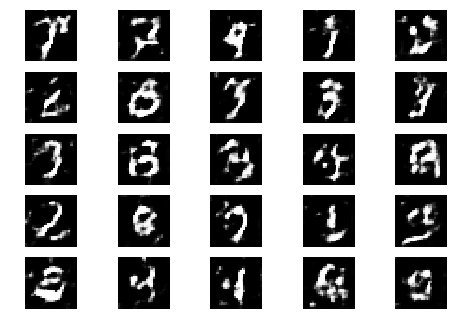

4601 [D loss: 0.999976] [G loss: 1.000064]
4602 [D loss: 0.999967] [G loss: 1.000055]
4603 [D loss: 0.999974] [G loss: 1.000052]
4604 [D loss: 0.999959] [G loss: 1.000064]
4605 [D loss: 0.999977] [G loss: 1.000047]
4606 [D loss: 0.999964] [G loss: 1.000035]
4607 [D loss: 0.999966] [G loss: 1.000067]
4608 [D loss: 0.999962] [G loss: 1.000058]
4609 [D loss: 0.999959] [G loss: 1.000076]
4610 [D loss: 0.999976] [G loss: 1.000068]
4611 [D loss: 0.999967] [G loss: 1.000042]
4612 [D loss: 0.999972] [G loss: 1.000037]
4613 [D loss: 0.999968] [G loss: 1.000074]
4614 [D loss: 0.999958] [G loss: 1.000049]
4615 [D loss: 0.999972] [G loss: 1.000041]
4616 [D loss: 0.999957] [G loss: 1.000051]
4617 [D loss: 0.999959] [G loss: 1.000055]
4618 [D loss: 0.999970] [G loss: 1.000064]
4619 [D loss: 0.999970] [G loss: 1.000044]
4620 [D loss: 0.999982] [G loss: 1.000073]
4621 [D loss: 0.999959] [G loss: 1.000062]
4622 [D loss: 0.999979] [G loss: 1.000085]
4623 [D loss: 0.999962] [G loss: 1.000060]
4624 [D los

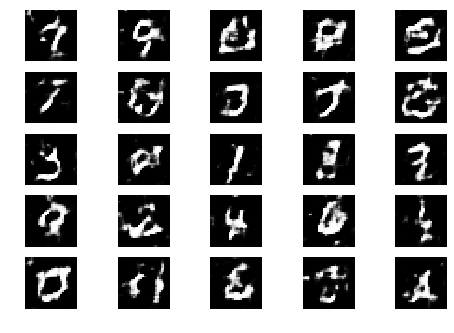

4651 [D loss: 0.999976] [G loss: 1.000089]
4652 [D loss: 0.999982] [G loss: 1.000053]
4653 [D loss: 0.999977] [G loss: 1.000064]
4654 [D loss: 0.999967] [G loss: 1.000051]
4655 [D loss: 0.999962] [G loss: 1.000056]
4656 [D loss: 0.999959] [G loss: 1.000066]
4657 [D loss: 0.999957] [G loss: 1.000046]
4658 [D loss: 0.999945] [G loss: 1.000073]
4659 [D loss: 0.999957] [G loss: 1.000054]
4660 [D loss: 0.999960] [G loss: 1.000074]
4661 [D loss: 0.999984] [G loss: 1.000077]
4662 [D loss: 0.999981] [G loss: 1.000055]
4663 [D loss: 0.999983] [G loss: 1.000045]
4664 [D loss: 0.999963] [G loss: 1.000066]
4665 [D loss: 0.999971] [G loss: 1.000052]
4666 [D loss: 0.999959] [G loss: 1.000047]
4667 [D loss: 0.999971] [G loss: 1.000064]
4668 [D loss: 0.999970] [G loss: 1.000078]
4669 [D loss: 0.999966] [G loss: 1.000067]
4670 [D loss: 0.999972] [G loss: 1.000019]
4671 [D loss: 0.999950] [G loss: 1.000035]
4672 [D loss: 0.999961] [G loss: 1.000052]
4673 [D loss: 0.999978] [G loss: 1.000061]
4674 [D los

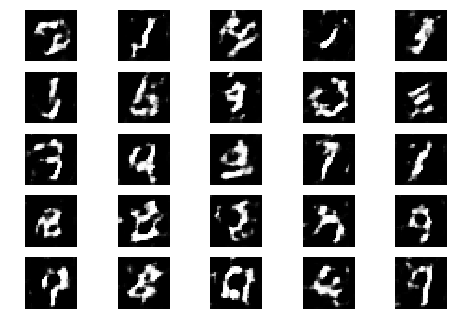

4701 [D loss: 0.999943] [G loss: 1.000057]
4702 [D loss: 0.999963] [G loss: 1.000062]
4703 [D loss: 0.999965] [G loss: 1.000071]
4704 [D loss: 0.999962] [G loss: 1.000075]
4705 [D loss: 0.999968] [G loss: 1.000065]
4706 [D loss: 0.999958] [G loss: 1.000045]
4707 [D loss: 0.999978] [G loss: 1.000068]
4708 [D loss: 0.999966] [G loss: 1.000065]
4709 [D loss: 0.999960] [G loss: 1.000057]
4710 [D loss: 0.999981] [G loss: 1.000072]
4711 [D loss: 0.999980] [G loss: 1.000055]
4712 [D loss: 0.999973] [G loss: 1.000061]
4713 [D loss: 0.999978] [G loss: 1.000059]
4714 [D loss: 0.999961] [G loss: 1.000063]
4715 [D loss: 0.999980] [G loss: 1.000085]
4716 [D loss: 0.999967] [G loss: 1.000058]
4717 [D loss: 0.999963] [G loss: 1.000057]
4718 [D loss: 0.999967] [G loss: 1.000065]
4719 [D loss: 0.999952] [G loss: 1.000056]
4720 [D loss: 0.999954] [G loss: 1.000068]
4721 [D loss: 0.999955] [G loss: 1.000051]
4722 [D loss: 0.999962] [G loss: 1.000083]
4723 [D loss: 0.999972] [G loss: 1.000068]
4724 [D los

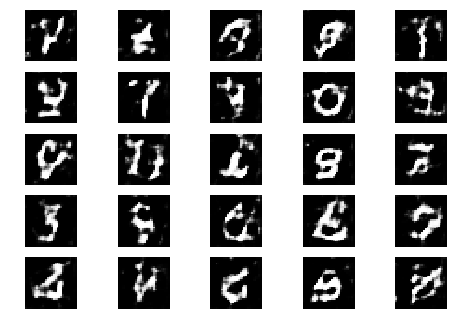

4751 [D loss: 0.999967] [G loss: 1.000063]
4752 [D loss: 0.999957] [G loss: 1.000078]
4753 [D loss: 0.999961] [G loss: 1.000075]
4754 [D loss: 0.999968] [G loss: 1.000088]
4755 [D loss: 0.999971] [G loss: 1.000093]
4756 [D loss: 0.999951] [G loss: 1.000075]
4757 [D loss: 0.999973] [G loss: 1.000059]
4758 [D loss: 0.999956] [G loss: 1.000044]
4759 [D loss: 0.999978] [G loss: 1.000051]
4760 [D loss: 0.999968] [G loss: 1.000049]
4761 [D loss: 0.999974] [G loss: 1.000048]
4762 [D loss: 0.999968] [G loss: 1.000058]
4763 [D loss: 0.999962] [G loss: 1.000056]
4764 [D loss: 0.999955] [G loss: 1.000058]
4765 [D loss: 0.999960] [G loss: 1.000057]
4766 [D loss: 0.999964] [G loss: 1.000052]
4767 [D loss: 0.999960] [G loss: 1.000056]
4768 [D loss: 0.999958] [G loss: 1.000036]
4769 [D loss: 0.999965] [G loss: 1.000051]
4770 [D loss: 0.999957] [G loss: 1.000061]
4771 [D loss: 0.999948] [G loss: 1.000081]
4772 [D loss: 0.999971] [G loss: 1.000047]
4773 [D loss: 0.999956] [G loss: 1.000051]
4774 [D los

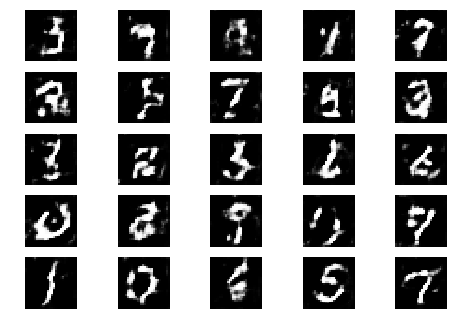

4801 [D loss: 0.999966] [G loss: 1.000084]
4802 [D loss: 0.999981] [G loss: 1.000077]
4803 [D loss: 0.999963] [G loss: 1.000058]
4804 [D loss: 0.999973] [G loss: 1.000047]
4805 [D loss: 0.999971] [G loss: 1.000061]
4806 [D loss: 0.999962] [G loss: 1.000069]
4807 [D loss: 0.999973] [G loss: 1.000056]
4808 [D loss: 0.999961] [G loss: 1.000041]
4809 [D loss: 0.999960] [G loss: 1.000069]
4810 [D loss: 0.999953] [G loss: 1.000058]
4811 [D loss: 0.999978] [G loss: 1.000053]
4812 [D loss: 0.999963] [G loss: 1.000042]
4813 [D loss: 0.999967] [G loss: 1.000077]
4814 [D loss: 0.999967] [G loss: 1.000037]
4815 [D loss: 0.999964] [G loss: 1.000070]
4816 [D loss: 0.999954] [G loss: 1.000022]
4817 [D loss: 0.999965] [G loss: 1.000047]
4818 [D loss: 0.999982] [G loss: 1.000077]
4819 [D loss: 0.999950] [G loss: 1.000067]
4820 [D loss: 0.999975] [G loss: 1.000080]
4821 [D loss: 0.999968] [G loss: 1.000068]
4822 [D loss: 0.999974] [G loss: 1.000063]
4823 [D loss: 0.999954] [G loss: 1.000044]
4824 [D los

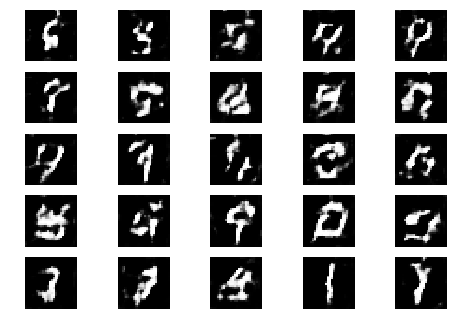

4851 [D loss: 0.999974] [G loss: 1.000061]
4852 [D loss: 0.999975] [G loss: 1.000071]
4853 [D loss: 0.999951] [G loss: 1.000066]
4854 [D loss: 0.999970] [G loss: 1.000051]
4855 [D loss: 0.999978] [G loss: 1.000059]
4856 [D loss: 0.999973] [G loss: 1.000061]
4857 [D loss: 0.999972] [G loss: 1.000063]
4858 [D loss: 0.999978] [G loss: 1.000067]
4859 [D loss: 0.999958] [G loss: 1.000060]
4860 [D loss: 0.999965] [G loss: 1.000064]
4861 [D loss: 0.999961] [G loss: 1.000061]
4862 [D loss: 0.999965] [G loss: 1.000075]
4863 [D loss: 0.999967] [G loss: 1.000063]
4864 [D loss: 0.999975] [G loss: 1.000060]
4865 [D loss: 0.999963] [G loss: 1.000060]
4866 [D loss: 0.999979] [G loss: 1.000055]
4867 [D loss: 0.999958] [G loss: 1.000079]
4868 [D loss: 0.999974] [G loss: 1.000069]
4869 [D loss: 0.999969] [G loss: 1.000060]
4870 [D loss: 0.999957] [G loss: 1.000047]
4871 [D loss: 0.999981] [G loss: 1.000052]
4872 [D loss: 0.999972] [G loss: 1.000054]
4873 [D loss: 0.999965] [G loss: 1.000044]
4874 [D los

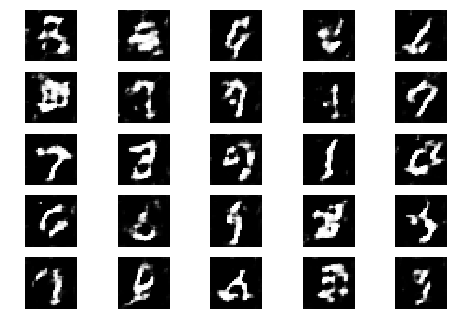

4901 [D loss: 0.999961] [G loss: 1.000073]
4902 [D loss: 0.999948] [G loss: 1.000061]
4903 [D loss: 0.999977] [G loss: 1.000033]
4904 [D loss: 0.999964] [G loss: 1.000095]
4905 [D loss: 0.999965] [G loss: 1.000069]
4906 [D loss: 0.999990] [G loss: 1.000049]
4907 [D loss: 0.999961] [G loss: 1.000051]
4908 [D loss: 0.999972] [G loss: 1.000058]
4909 [D loss: 0.999939] [G loss: 1.000063]
4910 [D loss: 0.999982] [G loss: 1.000046]
4911 [D loss: 0.999967] [G loss: 1.000064]
4912 [D loss: 0.999960] [G loss: 1.000061]
4913 [D loss: 0.999961] [G loss: 1.000067]
4914 [D loss: 0.999970] [G loss: 1.000065]
4915 [D loss: 0.999956] [G loss: 1.000065]
4916 [D loss: 0.999981] [G loss: 1.000029]
4917 [D loss: 0.999976] [G loss: 1.000078]
4918 [D loss: 0.999960] [G loss: 1.000047]
4919 [D loss: 0.999970] [G loss: 1.000071]
4920 [D loss: 0.999952] [G loss: 1.000066]
4921 [D loss: 0.999973] [G loss: 1.000068]
4922 [D loss: 0.999947] [G loss: 1.000078]
4923 [D loss: 0.999968] [G loss: 1.000071]
4924 [D los

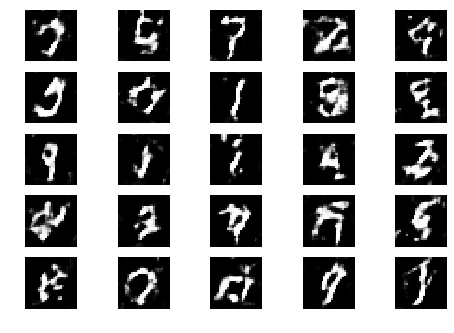

4951 [D loss: 0.999978] [G loss: 1.000046]
4952 [D loss: 0.999956] [G loss: 1.000050]
4953 [D loss: 0.999974] [G loss: 1.000052]
4954 [D loss: 0.999974] [G loss: 1.000067]
4955 [D loss: 0.999960] [G loss: 1.000099]
4956 [D loss: 0.999967] [G loss: 1.000064]
4957 [D loss: 0.999947] [G loss: 1.000024]
4958 [D loss: 0.999966] [G loss: 1.000087]
4959 [D loss: 0.999975] [G loss: 1.000075]
4960 [D loss: 0.999967] [G loss: 1.000032]
4961 [D loss: 0.999947] [G loss: 1.000065]
4962 [D loss: 0.999984] [G loss: 1.000060]
4963 [D loss: 0.999960] [G loss: 1.000066]
4964 [D loss: 0.999984] [G loss: 1.000059]
4965 [D loss: 0.999956] [G loss: 1.000036]
4966 [D loss: 0.999964] [G loss: 1.000065]
4967 [D loss: 0.999978] [G loss: 1.000077]
4968 [D loss: 0.999972] [G loss: 1.000062]
4969 [D loss: 0.999987] [G loss: 1.000018]
4970 [D loss: 0.999982] [G loss: 1.000078]
4971 [D loss: 0.999973] [G loss: 1.000066]
4972 [D loss: 0.999973] [G loss: 1.000049]
4973 [D loss: 0.999975] [G loss: 1.000038]
4974 [D los

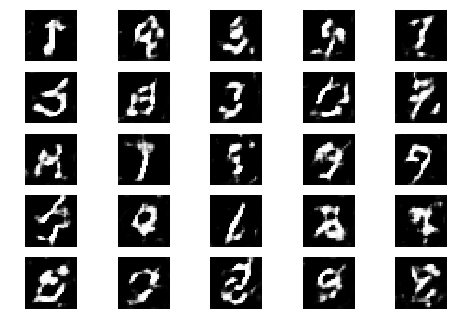

5001 [D loss: 0.999928] [G loss: 1.000077]
5002 [D loss: 0.999960] [G loss: 1.000054]
5003 [D loss: 0.999975] [G loss: 1.000084]
5004 [D loss: 0.999951] [G loss: 1.000073]
5005 [D loss: 0.999988] [G loss: 1.000060]
5006 [D loss: 0.999950] [G loss: 1.000044]
5007 [D loss: 0.999980] [G loss: 1.000051]
5008 [D loss: 0.999980] [G loss: 1.000030]
5009 [D loss: 0.999971] [G loss: 1.000067]
5010 [D loss: 0.999982] [G loss: 1.000037]
5011 [D loss: 0.999979] [G loss: 1.000072]
5012 [D loss: 0.999984] [G loss: 1.000044]
5013 [D loss: 0.999968] [G loss: 1.000047]
5014 [D loss: 0.999974] [G loss: 1.000076]
5015 [D loss: 0.999955] [G loss: 1.000047]
5016 [D loss: 0.999976] [G loss: 1.000069]
5017 [D loss: 0.999965] [G loss: 1.000035]
5018 [D loss: 0.999974] [G loss: 1.000059]
5019 [D loss: 0.999968] [G loss: 1.000063]
5020 [D loss: 0.999982] [G loss: 1.000074]
5021 [D loss: 0.999975] [G loss: 1.000050]
5022 [D loss: 0.999976] [G loss: 1.000060]
5023 [D loss: 0.999964] [G loss: 1.000038]
5024 [D los

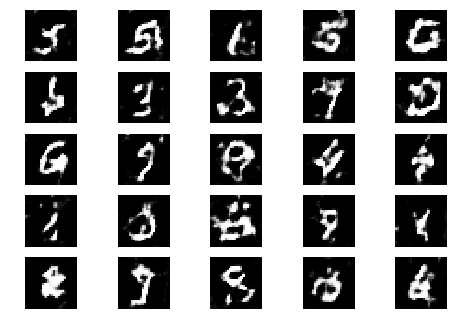

5051 [D loss: 0.999965] [G loss: 1.000074]
5052 [D loss: 0.999976] [G loss: 1.000075]
5053 [D loss: 0.999967] [G loss: 1.000088]
5054 [D loss: 0.999967] [G loss: 1.000059]
5055 [D loss: 0.999952] [G loss: 1.000053]
5056 [D loss: 0.999961] [G loss: 1.000085]
5057 [D loss: 0.999977] [G loss: 1.000063]
5058 [D loss: 0.999977] [G loss: 1.000050]
5059 [D loss: 0.999968] [G loss: 1.000070]
5060 [D loss: 0.999967] [G loss: 1.000053]
5061 [D loss: 0.999961] [G loss: 1.000056]
5062 [D loss: 0.999969] [G loss: 1.000067]
5063 [D loss: 0.999975] [G loss: 1.000054]
5064 [D loss: 0.999976] [G loss: 1.000090]
5065 [D loss: 0.999956] [G loss: 1.000072]
5066 [D loss: 0.999965] [G loss: 1.000051]
5067 [D loss: 0.999956] [G loss: 1.000085]
5068 [D loss: 0.999973] [G loss: 1.000045]
5069 [D loss: 0.999979] [G loss: 1.000055]
5070 [D loss: 0.999978] [G loss: 1.000058]
5071 [D loss: 0.999976] [G loss: 1.000054]
5072 [D loss: 0.999976] [G loss: 1.000060]
5073 [D loss: 0.999974] [G loss: 1.000058]
5074 [D los

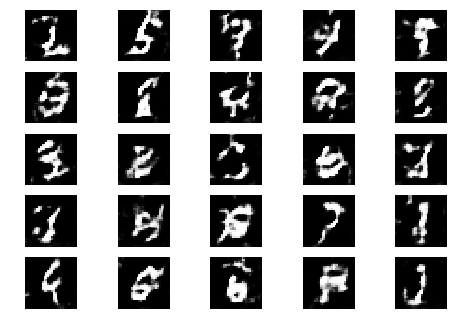

5101 [D loss: 0.999969] [G loss: 1.000052]
5102 [D loss: 0.999966] [G loss: 1.000075]
5103 [D loss: 0.999971] [G loss: 1.000067]
5104 [D loss: 0.999968] [G loss: 1.000042]
5105 [D loss: 0.999963] [G loss: 1.000059]
5106 [D loss: 0.999963] [G loss: 1.000072]
5107 [D loss: 0.999959] [G loss: 1.000060]
5108 [D loss: 0.999986] [G loss: 1.000073]
5109 [D loss: 0.999968] [G loss: 1.000068]
5110 [D loss: 0.999979] [G loss: 1.000051]
5111 [D loss: 0.999964] [G loss: 1.000065]
5112 [D loss: 0.999965] [G loss: 1.000064]
5113 [D loss: 0.999965] [G loss: 1.000069]
5114 [D loss: 0.999961] [G loss: 1.000084]
5115 [D loss: 0.999962] [G loss: 1.000054]
5116 [D loss: 0.999958] [G loss: 1.000050]
5117 [D loss: 0.999966] [G loss: 1.000072]
5118 [D loss: 0.999967] [G loss: 1.000046]
5119 [D loss: 0.999977] [G loss: 1.000062]
5120 [D loss: 0.999958] [G loss: 1.000065]
5121 [D loss: 0.999980] [G loss: 1.000047]
5122 [D loss: 0.999969] [G loss: 1.000023]
5123 [D loss: 0.999962] [G loss: 1.000057]
5124 [D los

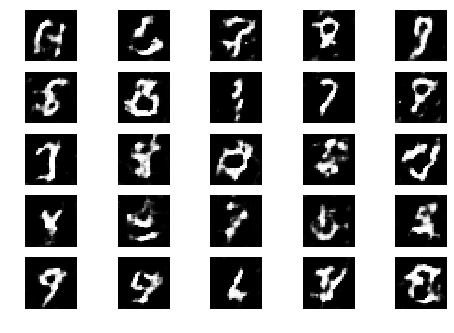

5151 [D loss: 0.999972] [G loss: 1.000058]
5152 [D loss: 0.999965] [G loss: 1.000059]
5153 [D loss: 0.999952] [G loss: 1.000047]
5154 [D loss: 0.999979] [G loss: 1.000060]
5155 [D loss: 0.999966] [G loss: 1.000079]
5156 [D loss: 0.999961] [G loss: 1.000068]
5157 [D loss: 0.999961] [G loss: 1.000089]
5158 [D loss: 0.999968] [G loss: 1.000073]
5159 [D loss: 0.999982] [G loss: 1.000062]
5160 [D loss: 0.999978] [G loss: 1.000061]
5161 [D loss: 0.999959] [G loss: 1.000069]
5162 [D loss: 0.999968] [G loss: 1.000075]
5163 [D loss: 0.999980] [G loss: 1.000067]
5164 [D loss: 0.999952] [G loss: 1.000089]
5165 [D loss: 0.999975] [G loss: 1.000061]
5166 [D loss: 0.999956] [G loss: 1.000048]
5167 [D loss: 0.999947] [G loss: 1.000075]
5168 [D loss: 0.999975] [G loss: 1.000077]
5169 [D loss: 0.999987] [G loss: 1.000093]
5170 [D loss: 0.999958] [G loss: 1.000078]
5171 [D loss: 0.999977] [G loss: 1.000086]
5172 [D loss: 0.999981] [G loss: 1.000059]
5173 [D loss: 0.999972] [G loss: 1.000050]
5174 [D los

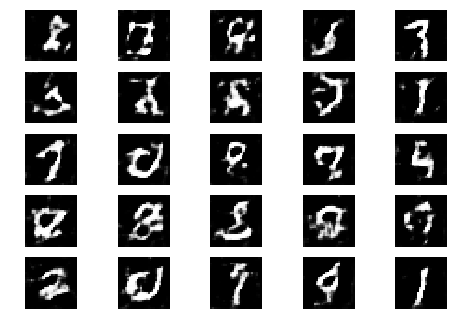

5201 [D loss: 0.999947] [G loss: 1.000079]
5202 [D loss: 0.999953] [G loss: 1.000038]
5203 [D loss: 0.999971] [G loss: 1.000029]
5204 [D loss: 0.999978] [G loss: 1.000037]
5205 [D loss: 0.999957] [G loss: 1.000061]
5206 [D loss: 0.999979] [G loss: 1.000079]
5207 [D loss: 0.999960] [G loss: 1.000074]
5208 [D loss: 0.999978] [G loss: 1.000068]
5209 [D loss: 0.999957] [G loss: 1.000033]
5210 [D loss: 0.999946] [G loss: 1.000050]
5211 [D loss: 0.999952] [G loss: 1.000055]
5212 [D loss: 0.999965] [G loss: 1.000077]
5213 [D loss: 0.999972] [G loss: 1.000039]
5214 [D loss: 0.999960] [G loss: 1.000062]
5215 [D loss: 0.999966] [G loss: 1.000049]
5216 [D loss: 0.999960] [G loss: 1.000064]
5217 [D loss: 0.999976] [G loss: 1.000065]
5218 [D loss: 0.999973] [G loss: 1.000069]
5219 [D loss: 0.999960] [G loss: 1.000058]
5220 [D loss: 0.999956] [G loss: 1.000073]
5221 [D loss: 0.999951] [G loss: 1.000053]
5222 [D loss: 0.999976] [G loss: 1.000075]
5223 [D loss: 0.999971] [G loss: 1.000068]
5224 [D los

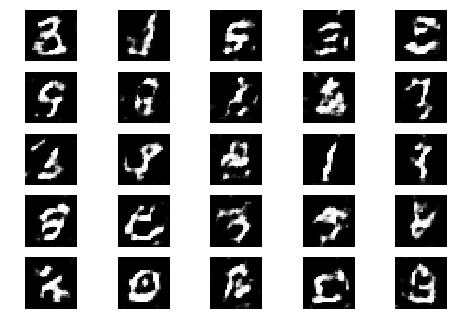

5251 [D loss: 0.999958] [G loss: 1.000056]
5252 [D loss: 0.999960] [G loss: 1.000064]
5253 [D loss: 0.999976] [G loss: 1.000063]
5254 [D loss: 0.999971] [G loss: 1.000066]
5255 [D loss: 0.999968] [G loss: 1.000055]
5256 [D loss: 0.999948] [G loss: 1.000065]
5257 [D loss: 0.999959] [G loss: 1.000048]
5258 [D loss: 0.999964] [G loss: 1.000078]
5259 [D loss: 0.999982] [G loss: 1.000059]
5260 [D loss: 0.999956] [G loss: 1.000043]
5261 [D loss: 0.999980] [G loss: 1.000039]
5262 [D loss: 0.999950] [G loss: 1.000037]
5263 [D loss: 0.999947] [G loss: 1.000059]
5264 [D loss: 0.999959] [G loss: 1.000044]
5265 [D loss: 0.999955] [G loss: 1.000037]
5266 [D loss: 0.999979] [G loss: 1.000072]
5267 [D loss: 0.999976] [G loss: 1.000061]
5268 [D loss: 0.999940] [G loss: 1.000060]
5269 [D loss: 0.999957] [G loss: 1.000028]
5270 [D loss: 0.999959] [G loss: 1.000068]
5271 [D loss: 0.999934] [G loss: 1.000083]
5272 [D loss: 0.999993] [G loss: 1.000040]
5273 [D loss: 0.999970] [G loss: 1.000058]
5274 [D los

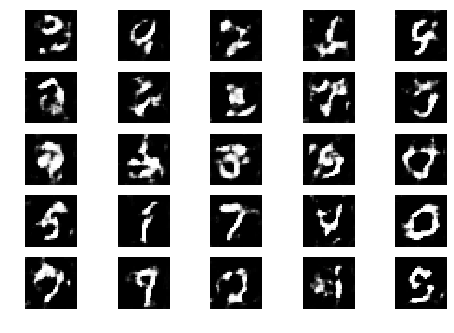

5301 [D loss: 0.999966] [G loss: 1.000074]
5302 [D loss: 0.999963] [G loss: 1.000072]
5303 [D loss: 0.999975] [G loss: 1.000090]
5304 [D loss: 0.999964] [G loss: 1.000070]
5305 [D loss: 0.999971] [G loss: 1.000078]
5306 [D loss: 0.999958] [G loss: 1.000070]
5307 [D loss: 0.999959] [G loss: 1.000064]
5308 [D loss: 0.999978] [G loss: 1.000082]
5309 [D loss: 0.999968] [G loss: 1.000059]
5310 [D loss: 0.999971] [G loss: 1.000073]
5311 [D loss: 0.999974] [G loss: 1.000056]
5312 [D loss: 0.999990] [G loss: 1.000068]
5313 [D loss: 0.999984] [G loss: 1.000066]
5314 [D loss: 0.999962] [G loss: 1.000064]
5315 [D loss: 0.999976] [G loss: 1.000056]
5316 [D loss: 0.999955] [G loss: 1.000033]
5317 [D loss: 0.999965] [G loss: 1.000068]
5318 [D loss: 0.999961] [G loss: 1.000084]
5319 [D loss: 0.999949] [G loss: 1.000054]
5320 [D loss: 0.999972] [G loss: 1.000065]
5321 [D loss: 0.999968] [G loss: 1.000044]
5322 [D loss: 0.999951] [G loss: 1.000067]
5323 [D loss: 0.999978] [G loss: 1.000050]
5324 [D los

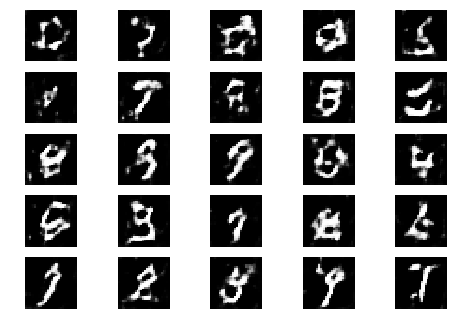

5351 [D loss: 0.999973] [G loss: 1.000055]
5352 [D loss: 0.999971] [G loss: 1.000085]
5353 [D loss: 0.999974] [G loss: 1.000067]
5354 [D loss: 0.999968] [G loss: 1.000057]
5355 [D loss: 0.999968] [G loss: 1.000036]
5356 [D loss: 0.999956] [G loss: 1.000082]
5357 [D loss: 0.999991] [G loss: 1.000039]
5358 [D loss: 0.999948] [G loss: 1.000044]
5359 [D loss: 0.999948] [G loss: 1.000050]
5360 [D loss: 0.999972] [G loss: 1.000041]
5361 [D loss: 0.999965] [G loss: 1.000049]
5362 [D loss: 0.999977] [G loss: 1.000074]
5363 [D loss: 0.999962] [G loss: 1.000063]
5364 [D loss: 0.999971] [G loss: 1.000079]
5365 [D loss: 0.999969] [G loss: 1.000039]
5366 [D loss: 0.999971] [G loss: 1.000073]
5367 [D loss: 0.999964] [G loss: 1.000057]
5368 [D loss: 0.999971] [G loss: 1.000075]
5369 [D loss: 0.999981] [G loss: 1.000059]
5370 [D loss: 0.999964] [G loss: 1.000058]
5371 [D loss: 0.999973] [G loss: 1.000058]
5372 [D loss: 0.999963] [G loss: 1.000039]
5373 [D loss: 0.999984] [G loss: 1.000058]
5374 [D los

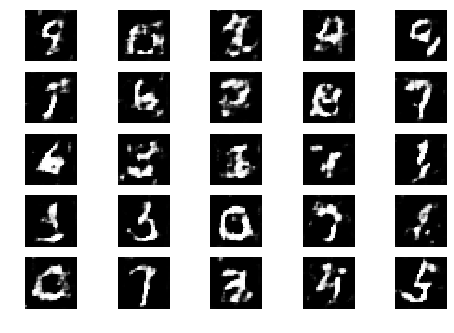

5401 [D loss: 0.999960] [G loss: 1.000049]
5402 [D loss: 0.999957] [G loss: 1.000026]
5403 [D loss: 0.999959] [G loss: 1.000074]
5404 [D loss: 0.999965] [G loss: 1.000069]
5405 [D loss: 0.999974] [G loss: 1.000079]
5406 [D loss: 0.999957] [G loss: 1.000061]
5407 [D loss: 0.999974] [G loss: 1.000043]
5408 [D loss: 0.999980] [G loss: 1.000060]
5409 [D loss: 0.999982] [G loss: 1.000083]
5410 [D loss: 0.999980] [G loss: 1.000065]
5411 [D loss: 0.999966] [G loss: 1.000036]
5412 [D loss: 0.999974] [G loss: 1.000035]
5413 [D loss: 0.999968] [G loss: 1.000044]
5414 [D loss: 0.999973] [G loss: 1.000045]
5415 [D loss: 0.999957] [G loss: 1.000035]
5416 [D loss: 0.999977] [G loss: 1.000046]
5417 [D loss: 0.999960] [G loss: 1.000027]
5418 [D loss: 0.999948] [G loss: 1.000063]
5419 [D loss: 0.999957] [G loss: 1.000068]
5420 [D loss: 0.999977] [G loss: 1.000046]
5421 [D loss: 0.999972] [G loss: 1.000085]
5422 [D loss: 0.999953] [G loss: 1.000056]
5423 [D loss: 0.999973] [G loss: 1.000061]
5424 [D los

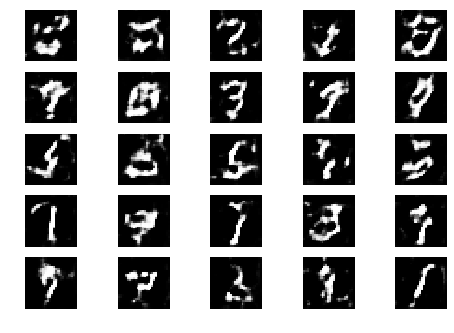

5451 [D loss: 0.999989] [G loss: 1.000073]
5452 [D loss: 0.999971] [G loss: 1.000067]
5453 [D loss: 0.999947] [G loss: 1.000068]
5454 [D loss: 0.999980] [G loss: 1.000057]
5455 [D loss: 0.999983] [G loss: 1.000068]
5456 [D loss: 0.999962] [G loss: 1.000055]
5457 [D loss: 0.999950] [G loss: 1.000048]
5458 [D loss: 0.999952] [G loss: 1.000053]
5459 [D loss: 0.999977] [G loss: 1.000053]
5460 [D loss: 0.999954] [G loss: 1.000059]
5461 [D loss: 0.999976] [G loss: 1.000054]
5462 [D loss: 0.999936] [G loss: 1.000065]
5463 [D loss: 0.999969] [G loss: 1.000065]
5464 [D loss: 0.999939] [G loss: 1.000085]
5465 [D loss: 0.999967] [G loss: 1.000084]
5466 [D loss: 0.999946] [G loss: 1.000077]
5467 [D loss: 0.999976] [G loss: 1.000058]
5468 [D loss: 0.999977] [G loss: 1.000063]
5469 [D loss: 0.999974] [G loss: 1.000087]
5470 [D loss: 0.999968] [G loss: 1.000073]
5471 [D loss: 0.999953] [G loss: 1.000053]
5472 [D loss: 0.999949] [G loss: 1.000052]
5473 [D loss: 0.999971] [G loss: 1.000093]
5474 [D los

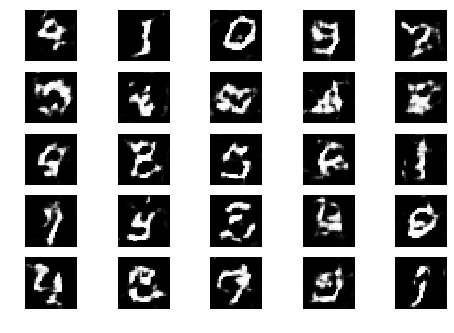

5501 [D loss: 0.999960] [G loss: 1.000045]
5502 [D loss: 0.999966] [G loss: 1.000059]
5503 [D loss: 0.999974] [G loss: 1.000046]
5504 [D loss: 0.999960] [G loss: 1.000058]
5505 [D loss: 0.999980] [G loss: 1.000066]
5506 [D loss: 0.999973] [G loss: 1.000052]
5507 [D loss: 0.999974] [G loss: 1.000031]
5508 [D loss: 0.999981] [G loss: 1.000056]
5509 [D loss: 0.999960] [G loss: 1.000047]
5510 [D loss: 0.999970] [G loss: 1.000059]
5511 [D loss: 0.999960] [G loss: 1.000059]
5512 [D loss: 0.999979] [G loss: 1.000042]
5513 [D loss: 0.999961] [G loss: 1.000054]
5514 [D loss: 0.999961] [G loss: 1.000062]
5515 [D loss: 0.999961] [G loss: 1.000056]
5516 [D loss: 0.999972] [G loss: 1.000057]
5517 [D loss: 0.999966] [G loss: 1.000051]
5518 [D loss: 0.999968] [G loss: 1.000062]
5519 [D loss: 0.999972] [G loss: 1.000067]
5520 [D loss: 0.999967] [G loss: 1.000072]
5521 [D loss: 0.999966] [G loss: 1.000066]
5522 [D loss: 0.999975] [G loss: 1.000071]
5523 [D loss: 0.999980] [G loss: 1.000059]
5524 [D los

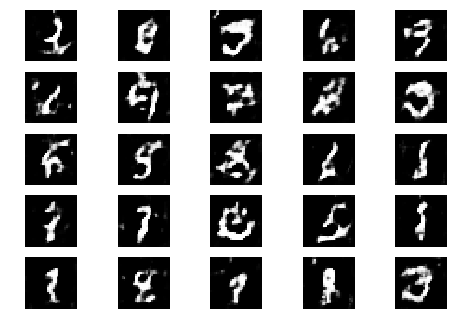

5551 [D loss: 0.999968] [G loss: 1.000061]
5552 [D loss: 0.999963] [G loss: 1.000059]
5553 [D loss: 0.999966] [G loss: 1.000073]
5554 [D loss: 0.999974] [G loss: 1.000069]
5555 [D loss: 0.999955] [G loss: 1.000070]
5556 [D loss: 0.999953] [G loss: 1.000059]
5557 [D loss: 0.999963] [G loss: 1.000061]
5558 [D loss: 0.999970] [G loss: 1.000066]
5559 [D loss: 0.999982] [G loss: 1.000051]
5560 [D loss: 0.999974] [G loss: 1.000062]
5561 [D loss: 0.999976] [G loss: 1.000058]
5562 [D loss: 0.999966] [G loss: 1.000047]
5563 [D loss: 0.999952] [G loss: 1.000069]
5564 [D loss: 0.999970] [G loss: 1.000048]
5565 [D loss: 0.999967] [G loss: 1.000085]
5566 [D loss: 0.999972] [G loss: 1.000070]
5567 [D loss: 0.999983] [G loss: 1.000074]
5568 [D loss: 0.999950] [G loss: 1.000045]
5569 [D loss: 0.999967] [G loss: 1.000077]
5570 [D loss: 0.999977] [G loss: 1.000057]
5571 [D loss: 0.999979] [G loss: 1.000067]
5572 [D loss: 0.999975] [G loss: 1.000045]
5573 [D loss: 0.999968] [G loss: 1.000062]
5574 [D los

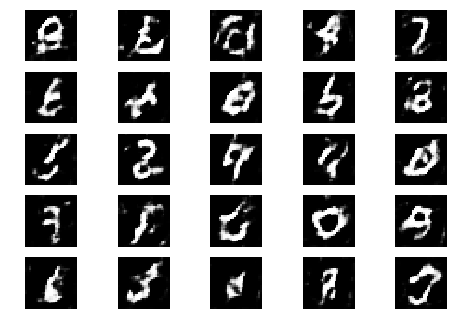

5601 [D loss: 0.999966] [G loss: 1.000082]
5602 [D loss: 0.999975] [G loss: 1.000042]
5603 [D loss: 0.999967] [G loss: 1.000067]
5604 [D loss: 0.999970] [G loss: 1.000032]
5605 [D loss: 0.999971] [G loss: 1.000059]
5606 [D loss: 0.999980] [G loss: 1.000063]
5607 [D loss: 0.999966] [G loss: 1.000056]
5608 [D loss: 0.999968] [G loss: 1.000072]
5609 [D loss: 0.999966] [G loss: 1.000066]
5610 [D loss: 0.999952] [G loss: 1.000071]
5611 [D loss: 0.999969] [G loss: 1.000060]
5612 [D loss: 0.999965] [G loss: 1.000042]
5613 [D loss: 0.999966] [G loss: 1.000074]
5614 [D loss: 0.999969] [G loss: 1.000061]
5615 [D loss: 0.999976] [G loss: 1.000052]
5616 [D loss: 0.999966] [G loss: 1.000076]
5617 [D loss: 0.999974] [G loss: 1.000055]
5618 [D loss: 0.999980] [G loss: 1.000072]
5619 [D loss: 0.999974] [G loss: 1.000074]
5620 [D loss: 0.999964] [G loss: 1.000047]
5621 [D loss: 0.999972] [G loss: 1.000060]
5622 [D loss: 0.999956] [G loss: 1.000051]
5623 [D loss: 0.999971] [G loss: 1.000056]
5624 [D los

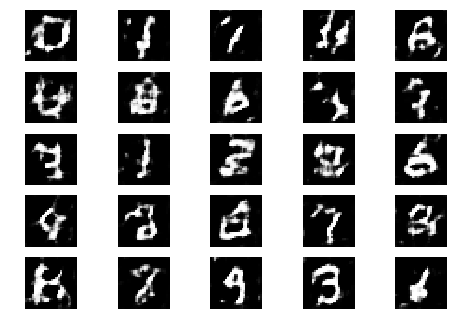

5651 [D loss: 0.999964] [G loss: 1.000057]
5652 [D loss: 0.999989] [G loss: 1.000045]
5653 [D loss: 0.999951] [G loss: 1.000046]
5654 [D loss: 0.999975] [G loss: 1.000074]
5655 [D loss: 0.999966] [G loss: 1.000047]
5656 [D loss: 0.999965] [G loss: 1.000034]
5657 [D loss: 0.999974] [G loss: 1.000067]
5658 [D loss: 0.999952] [G loss: 1.000059]
5659 [D loss: 0.999968] [G loss: 1.000050]
5660 [D loss: 0.999989] [G loss: 1.000068]
5661 [D loss: 0.999962] [G loss: 1.000054]
5662 [D loss: 0.999965] [G loss: 1.000039]
5663 [D loss: 0.999969] [G loss: 1.000043]
5664 [D loss: 0.999967] [G loss: 1.000060]
5665 [D loss: 0.999958] [G loss: 1.000060]
5666 [D loss: 0.999957] [G loss: 1.000054]
5667 [D loss: 0.999974] [G loss: 1.000066]
5668 [D loss: 0.999966] [G loss: 1.000064]
5669 [D loss: 0.999963] [G loss: 1.000044]
5670 [D loss: 0.999962] [G loss: 1.000047]
5671 [D loss: 0.999973] [G loss: 1.000061]
5672 [D loss: 0.999962] [G loss: 1.000070]
5673 [D loss: 0.999976] [G loss: 1.000067]
5674 [D los

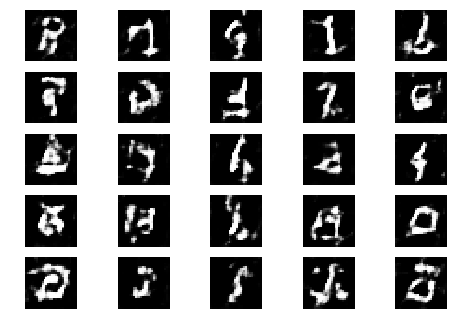

5701 [D loss: 0.999981] [G loss: 1.000044]
5702 [D loss: 0.999967] [G loss: 1.000037]
5703 [D loss: 0.999976] [G loss: 1.000044]
5704 [D loss: 0.999967] [G loss: 1.000040]
5705 [D loss: 0.999959] [G loss: 1.000074]
5706 [D loss: 0.999970] [G loss: 1.000079]
5707 [D loss: 0.999974] [G loss: 1.000062]
5708 [D loss: 0.999951] [G loss: 1.000056]
5709 [D loss: 0.999957] [G loss: 1.000074]
5710 [D loss: 0.999975] [G loss: 1.000069]
5711 [D loss: 0.999966] [G loss: 1.000055]
5712 [D loss: 0.999965] [G loss: 1.000066]
5713 [D loss: 0.999959] [G loss: 1.000051]
5714 [D loss: 0.999956] [G loss: 1.000064]
5715 [D loss: 0.999967] [G loss: 1.000069]
5716 [D loss: 0.999969] [G loss: 1.000054]
5717 [D loss: 0.999973] [G loss: 1.000076]
5718 [D loss: 0.999970] [G loss: 1.000038]
5719 [D loss: 0.999972] [G loss: 1.000068]
5720 [D loss: 0.999955] [G loss: 1.000074]
5721 [D loss: 0.999963] [G loss: 1.000061]
5722 [D loss: 0.999986] [G loss: 1.000055]
5723 [D loss: 0.999958] [G loss: 1.000051]
5724 [D los

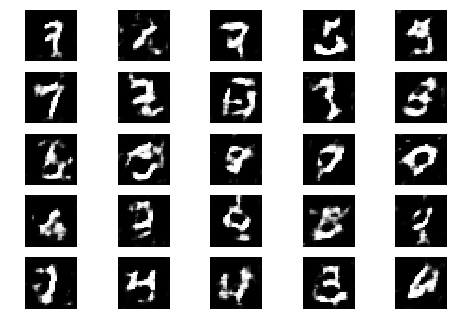

5751 [D loss: 0.999985] [G loss: 1.000065]
5752 [D loss: 0.999973] [G loss: 1.000060]
5753 [D loss: 0.999967] [G loss: 1.000069]
5754 [D loss: 0.999970] [G loss: 1.000064]
5755 [D loss: 0.999970] [G loss: 1.000066]
5756 [D loss: 0.999973] [G loss: 1.000080]
5757 [D loss: 0.999956] [G loss: 1.000071]
5758 [D loss: 0.999974] [G loss: 1.000065]
5759 [D loss: 0.999966] [G loss: 1.000075]
5760 [D loss: 0.999983] [G loss: 1.000074]
5761 [D loss: 0.999955] [G loss: 1.000049]
5762 [D loss: 0.999970] [G loss: 1.000046]
5763 [D loss: 0.999968] [G loss: 1.000060]
5764 [D loss: 0.999964] [G loss: 1.000057]
5765 [D loss: 0.999933] [G loss: 1.000055]
5766 [D loss: 0.999972] [G loss: 1.000073]
5767 [D loss: 0.999969] [G loss: 1.000066]
5768 [D loss: 0.999976] [G loss: 1.000056]
5769 [D loss: 0.999992] [G loss: 1.000046]
5770 [D loss: 0.999967] [G loss: 1.000041]
5771 [D loss: 0.999951] [G loss: 1.000070]
5772 [D loss: 0.999972] [G loss: 1.000058]
5773 [D loss: 0.999973] [G loss: 1.000064]
5774 [D los

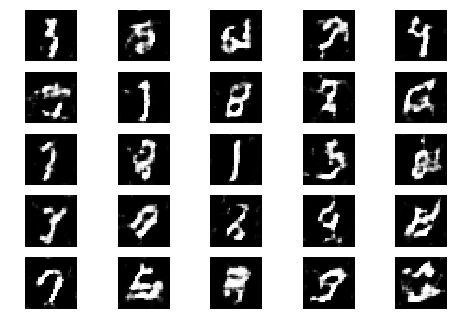

5801 [D loss: 0.999960] [G loss: 1.000072]
5802 [D loss: 0.999963] [G loss: 1.000047]
5803 [D loss: 0.999955] [G loss: 1.000066]
5804 [D loss: 0.999933] [G loss: 1.000072]
5805 [D loss: 0.999963] [G loss: 1.000041]
5806 [D loss: 0.999954] [G loss: 1.000038]
5807 [D loss: 0.999984] [G loss: 1.000045]
5808 [D loss: 0.999966] [G loss: 1.000034]
5809 [D loss: 0.999964] [G loss: 1.000058]
5810 [D loss: 0.999957] [G loss: 1.000084]
5811 [D loss: 0.999968] [G loss: 1.000046]
5812 [D loss: 0.999971] [G loss: 1.000040]
5813 [D loss: 0.999957] [G loss: 1.000079]
5814 [D loss: 0.999976] [G loss: 1.000028]
5815 [D loss: 0.999969] [G loss: 1.000073]
5816 [D loss: 0.999958] [G loss: 1.000032]
5817 [D loss: 0.999964] [G loss: 1.000056]
5818 [D loss: 0.999978] [G loss: 1.000068]
5819 [D loss: 0.999985] [G loss: 1.000054]
5820 [D loss: 0.999978] [G loss: 1.000095]
5821 [D loss: 0.999959] [G loss: 1.000052]
5822 [D loss: 0.999969] [G loss: 1.000067]
5823 [D loss: 0.999975] [G loss: 1.000054]
5824 [D los

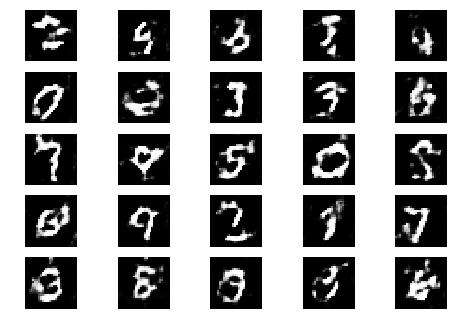

5851 [D loss: 0.999959] [G loss: 1.000070]
5852 [D loss: 0.999977] [G loss: 1.000053]
5853 [D loss: 0.999961] [G loss: 1.000050]
5854 [D loss: 0.999952] [G loss: 1.000058]
5855 [D loss: 0.999953] [G loss: 1.000069]
5856 [D loss: 0.999964] [G loss: 1.000074]
5857 [D loss: 0.999949] [G loss: 1.000047]
5858 [D loss: 0.999974] [G loss: 1.000077]
5859 [D loss: 0.999964] [G loss: 1.000073]
5860 [D loss: 0.999972] [G loss: 1.000088]
5861 [D loss: 0.999959] [G loss: 1.000043]
5862 [D loss: 0.999955] [G loss: 1.000052]
5863 [D loss: 0.999959] [G loss: 1.000065]
5864 [D loss: 0.999969] [G loss: 1.000072]
5865 [D loss: 0.999966] [G loss: 1.000068]
5866 [D loss: 0.999984] [G loss: 1.000054]
5867 [D loss: 0.999978] [G loss: 1.000059]
5868 [D loss: 0.999960] [G loss: 1.000052]
5869 [D loss: 0.999964] [G loss: 1.000062]
5870 [D loss: 0.999983] [G loss: 1.000054]
5871 [D loss: 0.999978] [G loss: 1.000070]
5872 [D loss: 0.999976] [G loss: 1.000056]
5873 [D loss: 0.999977] [G loss: 1.000064]
5874 [D los

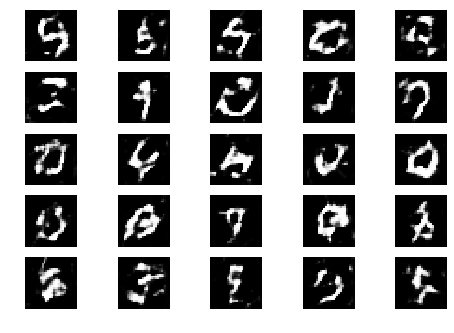

5901 [D loss: 0.999972] [G loss: 1.000066]
5902 [D loss: 0.999977] [G loss: 1.000050]
5903 [D loss: 0.999964] [G loss: 1.000052]
5904 [D loss: 0.999975] [G loss: 1.000036]
5905 [D loss: 0.999961] [G loss: 1.000051]
5906 [D loss: 0.999958] [G loss: 1.000092]
5907 [D loss: 0.999952] [G loss: 1.000049]
5908 [D loss: 0.999999] [G loss: 1.000095]
5909 [D loss: 0.999979] [G loss: 1.000040]
5910 [D loss: 0.999969] [G loss: 1.000051]
5911 [D loss: 0.999966] [G loss: 1.000046]
5912 [D loss: 0.999958] [G loss: 1.000045]
5913 [D loss: 0.999956] [G loss: 1.000077]
5914 [D loss: 0.999970] [G loss: 1.000071]
5915 [D loss: 0.999983] [G loss: 1.000065]
5916 [D loss: 0.999969] [G loss: 1.000052]
5917 [D loss: 0.999959] [G loss: 1.000045]
5918 [D loss: 0.999963] [G loss: 1.000062]
5919 [D loss: 0.999951] [G loss: 1.000056]
5920 [D loss: 0.999971] [G loss: 1.000043]
5921 [D loss: 0.999966] [G loss: 1.000056]
5922 [D loss: 0.999967] [G loss: 1.000051]
5923 [D loss: 0.999987] [G loss: 1.000049]
5924 [D los

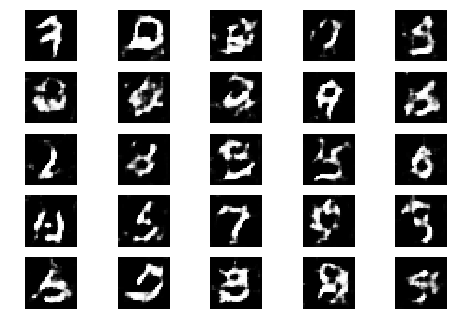

5951 [D loss: 0.999976] [G loss: 1.000049]
5952 [D loss: 0.999961] [G loss: 1.000068]
5953 [D loss: 0.999973] [G loss: 1.000063]
5954 [D loss: 0.999968] [G loss: 1.000065]
5955 [D loss: 0.999973] [G loss: 1.000041]
5956 [D loss: 0.999974] [G loss: 1.000076]
5957 [D loss: 0.999975] [G loss: 1.000037]
5958 [D loss: 0.999979] [G loss: 1.000042]
5959 [D loss: 0.999992] [G loss: 1.000038]
5960 [D loss: 0.999967] [G loss: 1.000063]
5961 [D loss: 0.999966] [G loss: 1.000041]
5962 [D loss: 0.999976] [G loss: 1.000091]
5963 [D loss: 0.999960] [G loss: 1.000057]
5964 [D loss: 0.999964] [G loss: 1.000051]
5965 [D loss: 0.999978] [G loss: 1.000049]
5966 [D loss: 0.999985] [G loss: 1.000069]
5967 [D loss: 0.999973] [G loss: 1.000046]
5968 [D loss: 0.999962] [G loss: 1.000074]
5969 [D loss: 0.999971] [G loss: 1.000075]
5970 [D loss: 0.999993] [G loss: 1.000059]
5971 [D loss: 0.999972] [G loss: 1.000074]
5972 [D loss: 0.999983] [G loss: 1.000083]
5973 [D loss: 0.999973] [G loss: 1.000046]
5974 [D los

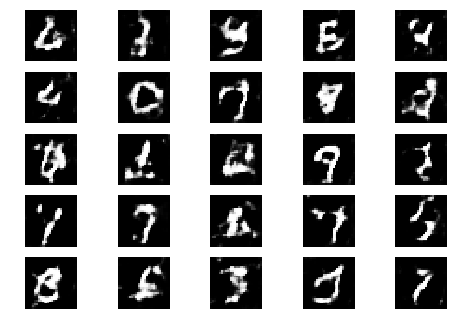

6001 [D loss: 0.999974] [G loss: 1.000067]
6002 [D loss: 0.999947] [G loss: 1.000063]
6003 [D loss: 0.999962] [G loss: 1.000035]
6004 [D loss: 0.999964] [G loss: 1.000047]
6005 [D loss: 0.999980] [G loss: 1.000065]
6006 [D loss: 0.999974] [G loss: 1.000084]
6007 [D loss: 0.999966] [G loss: 1.000057]
6008 [D loss: 0.999958] [G loss: 1.000061]
6009 [D loss: 0.999955] [G loss: 1.000032]
6010 [D loss: 0.999975] [G loss: 1.000090]
6011 [D loss: 0.999963] [G loss: 1.000066]
6012 [D loss: 0.999964] [G loss: 1.000058]
6013 [D loss: 0.999979] [G loss: 1.000060]
6014 [D loss: 0.999971] [G loss: 1.000061]
6015 [D loss: 0.999967] [G loss: 1.000066]
6016 [D loss: 0.999972] [G loss: 1.000053]
6017 [D loss: 0.999970] [G loss: 1.000065]
6018 [D loss: 0.999974] [G loss: 1.000059]
6019 [D loss: 0.999955] [G loss: 1.000042]
6020 [D loss: 0.999963] [G loss: 1.000054]
6021 [D loss: 0.999975] [G loss: 1.000061]
6022 [D loss: 0.999968] [G loss: 1.000048]
6023 [D loss: 0.999976] [G loss: 1.000057]
6024 [D los

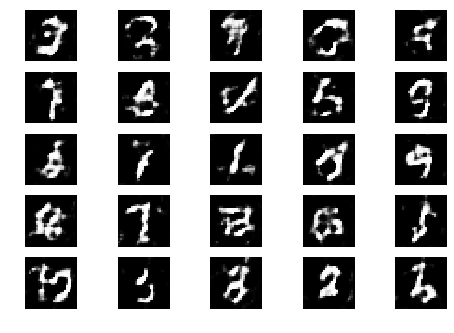

6051 [D loss: 0.999960] [G loss: 1.000067]
6052 [D loss: 0.999970] [G loss: 1.000050]
6053 [D loss: 0.999966] [G loss: 1.000062]
6054 [D loss: 0.999985] [G loss: 1.000083]
6055 [D loss: 0.999972] [G loss: 1.000066]
6056 [D loss: 0.999970] [G loss: 1.000059]
6057 [D loss: 0.999969] [G loss: 1.000066]
6058 [D loss: 0.999968] [G loss: 1.000052]
6059 [D loss: 0.999972] [G loss: 1.000088]
6060 [D loss: 0.999974] [G loss: 1.000066]
6061 [D loss: 0.999968] [G loss: 1.000069]
6062 [D loss: 0.999978] [G loss: 1.000067]
6063 [D loss: 0.999958] [G loss: 1.000059]
6064 [D loss: 0.999971] [G loss: 1.000049]
6065 [D loss: 0.999966] [G loss: 1.000095]
6066 [D loss: 0.999966] [G loss: 1.000069]
6067 [D loss: 0.999951] [G loss: 1.000053]
6068 [D loss: 0.999975] [G loss: 1.000065]
6069 [D loss: 0.999987] [G loss: 1.000056]
6070 [D loss: 0.999963] [G loss: 1.000059]
6071 [D loss: 0.999972] [G loss: 1.000068]
6072 [D loss: 0.999967] [G loss: 1.000059]
6073 [D loss: 0.999986] [G loss: 1.000058]
6074 [D los

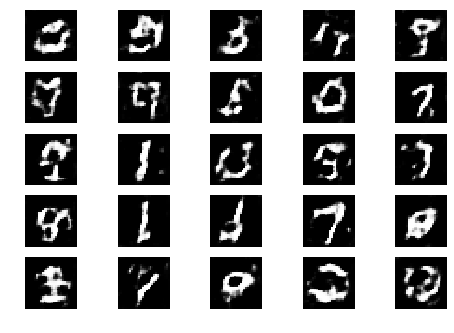

6101 [D loss: 0.999961] [G loss: 1.000060]
6102 [D loss: 0.999968] [G loss: 1.000069]
6103 [D loss: 0.999961] [G loss: 1.000085]
6104 [D loss: 0.999976] [G loss: 1.000062]
6105 [D loss: 0.999956] [G loss: 1.000061]
6106 [D loss: 0.999972] [G loss: 1.000071]
6107 [D loss: 0.999962] [G loss: 1.000056]
6108 [D loss: 0.999961] [G loss: 1.000059]
6109 [D loss: 0.999965] [G loss: 1.000066]
6110 [D loss: 0.999974] [G loss: 1.000052]
6111 [D loss: 0.999970] [G loss: 1.000072]
6112 [D loss: 0.999960] [G loss: 1.000059]
6113 [D loss: 0.999965] [G loss: 1.000053]
6114 [D loss: 0.999976] [G loss: 1.000070]
6115 [D loss: 0.999974] [G loss: 1.000074]
6116 [D loss: 0.999970] [G loss: 1.000046]
6117 [D loss: 0.999974] [G loss: 1.000059]
6118 [D loss: 0.999980] [G loss: 1.000066]
6119 [D loss: 0.999966] [G loss: 1.000036]
6120 [D loss: 0.999977] [G loss: 1.000051]
6121 [D loss: 0.999973] [G loss: 1.000054]
6122 [D loss: 0.999975] [G loss: 1.000083]
6123 [D loss: 0.999974] [G loss: 1.000066]
6124 [D los

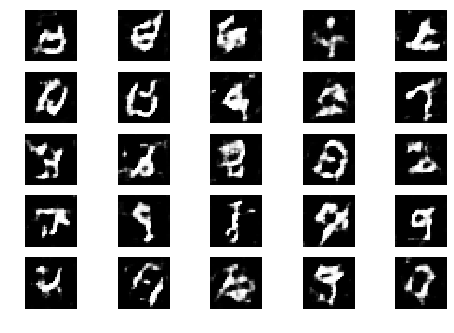

6151 [D loss: 0.999962] [G loss: 1.000073]
6152 [D loss: 0.999947] [G loss: 1.000059]
6153 [D loss: 0.999973] [G loss: 1.000064]
6154 [D loss: 0.999965] [G loss: 1.000069]
6155 [D loss: 0.999957] [G loss: 1.000070]
6156 [D loss: 0.999980] [G loss: 1.000057]
6157 [D loss: 0.999968] [G loss: 1.000061]
6158 [D loss: 0.999965] [G loss: 1.000064]
6159 [D loss: 0.999959] [G loss: 1.000058]
6160 [D loss: 0.999957] [G loss: 1.000076]
6161 [D loss: 0.999988] [G loss: 1.000059]
6162 [D loss: 0.999968] [G loss: 1.000038]
6163 [D loss: 0.999958] [G loss: 1.000066]
6164 [D loss: 0.999958] [G loss: 1.000053]
6165 [D loss: 0.999983] [G loss: 1.000047]
6166 [D loss: 0.999964] [G loss: 1.000060]
6167 [D loss: 0.999973] [G loss: 1.000056]
6168 [D loss: 0.999959] [G loss: 1.000066]
6169 [D loss: 0.999968] [G loss: 1.000086]
6170 [D loss: 0.999971] [G loss: 1.000064]
6171 [D loss: 0.999967] [G loss: 1.000066]
6172 [D loss: 0.999967] [G loss: 1.000063]
6173 [D loss: 0.999965] [G loss: 1.000040]
6174 [D los

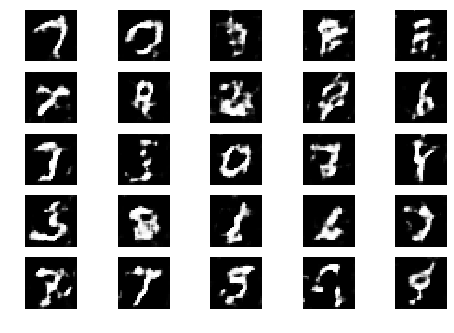

6201 [D loss: 0.999981] [G loss: 1.000057]
6202 [D loss: 0.999960] [G loss: 1.000082]
6203 [D loss: 0.999975] [G loss: 1.000059]
6204 [D loss: 0.999968] [G loss: 1.000050]
6205 [D loss: 0.999943] [G loss: 1.000054]
6206 [D loss: 0.999952] [G loss: 1.000046]
6207 [D loss: 0.999957] [G loss: 1.000065]
6208 [D loss: 0.999966] [G loss: 1.000083]
6209 [D loss: 0.999970] [G loss: 1.000084]
6210 [D loss: 0.999978] [G loss: 1.000061]
6211 [D loss: 0.999969] [G loss: 1.000067]
6212 [D loss: 0.999960] [G loss: 1.000078]
6213 [D loss: 0.999964] [G loss: 1.000067]
6214 [D loss: 0.999967] [G loss: 1.000057]
6215 [D loss: 0.999963] [G loss: 1.000079]
6216 [D loss: 0.999962] [G loss: 1.000072]
6217 [D loss: 0.999978] [G loss: 1.000059]
6218 [D loss: 0.999982] [G loss: 1.000052]
6219 [D loss: 0.999977] [G loss: 1.000048]
6220 [D loss: 0.999962] [G loss: 1.000074]
6221 [D loss: 0.999967] [G loss: 1.000068]
6222 [D loss: 0.999975] [G loss: 1.000050]
6223 [D loss: 0.999968] [G loss: 1.000055]
6224 [D los

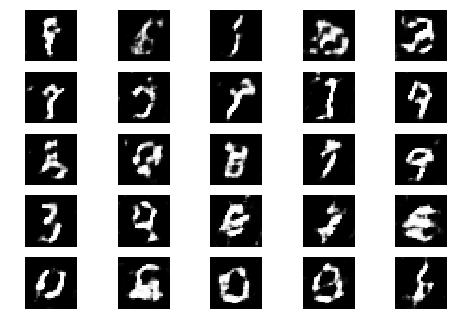

6251 [D loss: 0.999978] [G loss: 1.000077]
6252 [D loss: 0.999966] [G loss: 1.000041]
6253 [D loss: 0.999945] [G loss: 1.000048]
6254 [D loss: 0.999960] [G loss: 1.000073]
6255 [D loss: 0.999964] [G loss: 1.000055]
6256 [D loss: 0.999964] [G loss: 1.000063]
6257 [D loss: 0.999965] [G loss: 1.000090]
6258 [D loss: 0.999957] [G loss: 1.000071]
6259 [D loss: 0.999974] [G loss: 1.000062]
6260 [D loss: 0.999971] [G loss: 1.000070]
6261 [D loss: 0.999968] [G loss: 1.000065]
6262 [D loss: 0.999965] [G loss: 1.000078]
6263 [D loss: 0.999967] [G loss: 1.000059]
6264 [D loss: 0.999964] [G loss: 1.000055]
6265 [D loss: 0.999969] [G loss: 1.000061]
6266 [D loss: 0.999958] [G loss: 1.000072]
6267 [D loss: 0.999970] [G loss: 1.000063]
6268 [D loss: 0.999973] [G loss: 1.000066]
6269 [D loss: 0.999978] [G loss: 1.000064]
6270 [D loss: 0.999973] [G loss: 1.000064]
6271 [D loss: 0.999971] [G loss: 1.000070]
6272 [D loss: 0.999971] [G loss: 1.000062]
6273 [D loss: 0.999979] [G loss: 1.000035]
6274 [D los

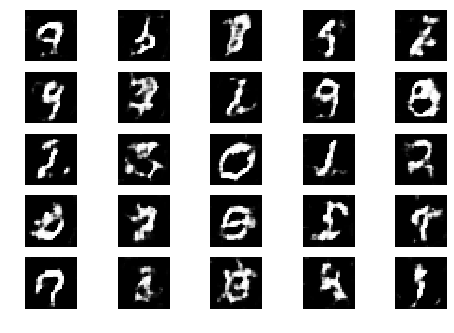

6301 [D loss: 0.999962] [G loss: 1.000078]
6302 [D loss: 0.999964] [G loss: 1.000061]
6303 [D loss: 0.999960] [G loss: 1.000074]
6304 [D loss: 0.999972] [G loss: 1.000065]
6305 [D loss: 0.999972] [G loss: 1.000049]
6306 [D loss: 0.999982] [G loss: 1.000081]
6307 [D loss: 0.999980] [G loss: 1.000060]
6308 [D loss: 0.999969] [G loss: 1.000058]
6309 [D loss: 0.999953] [G loss: 1.000067]
6310 [D loss: 0.999973] [G loss: 1.000075]
6311 [D loss: 0.999991] [G loss: 1.000054]
6312 [D loss: 0.999972] [G loss: 1.000049]
6313 [D loss: 0.999971] [G loss: 1.000053]
6314 [D loss: 0.999965] [G loss: 1.000060]
6315 [D loss: 0.999975] [G loss: 1.000060]
6316 [D loss: 0.999954] [G loss: 1.000060]
6317 [D loss: 0.999970] [G loss: 1.000087]
6318 [D loss: 0.999973] [G loss: 1.000065]
6319 [D loss: 0.999964] [G loss: 1.000049]
6320 [D loss: 0.999968] [G loss: 1.000071]
6321 [D loss: 0.999981] [G loss: 1.000043]
6322 [D loss: 0.999963] [G loss: 1.000055]
6323 [D loss: 0.999955] [G loss: 1.000070]
6324 [D los

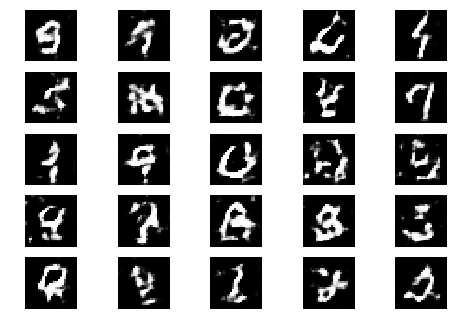

6351 [D loss: 0.999975] [G loss: 1.000060]
6352 [D loss: 0.999961] [G loss: 1.000053]
6353 [D loss: 0.999969] [G loss: 1.000065]
6354 [D loss: 0.999967] [G loss: 1.000078]
6355 [D loss: 0.999965] [G loss: 1.000071]
6356 [D loss: 0.999967] [G loss: 1.000074]
6357 [D loss: 0.999972] [G loss: 1.000028]
6358 [D loss: 0.999976] [G loss: 1.000045]
6359 [D loss: 0.999973] [G loss: 1.000074]
6360 [D loss: 0.999964] [G loss: 1.000056]
6361 [D loss: 0.999960] [G loss: 1.000049]
6362 [D loss: 0.999956] [G loss: 1.000054]
6363 [D loss: 0.999961] [G loss: 1.000052]
6364 [D loss: 0.999967] [G loss: 1.000076]
6365 [D loss: 0.999983] [G loss: 1.000043]
6366 [D loss: 0.999945] [G loss: 1.000041]
6367 [D loss: 0.999979] [G loss: 1.000071]
6368 [D loss: 0.999966] [G loss: 1.000078]
6369 [D loss: 0.999968] [G loss: 1.000058]
6370 [D loss: 0.999981] [G loss: 1.000050]
6371 [D loss: 0.999971] [G loss: 1.000058]
6372 [D loss: 0.999969] [G loss: 1.000034]
6373 [D loss: 0.999952] [G loss: 1.000072]
6374 [D los

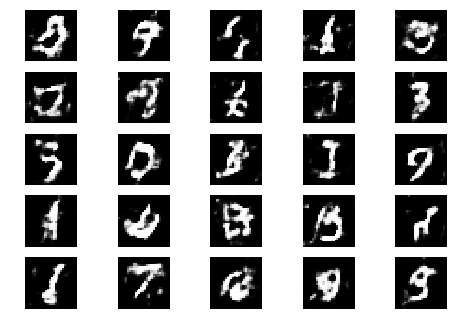

6401 [D loss: 0.999956] [G loss: 1.000053]
6402 [D loss: 0.999980] [G loss: 1.000062]
6403 [D loss: 0.999955] [G loss: 1.000055]
6404 [D loss: 0.999963] [G loss: 1.000072]
6405 [D loss: 0.999949] [G loss: 1.000074]
6406 [D loss: 0.999976] [G loss: 1.000026]
6407 [D loss: 0.999968] [G loss: 1.000075]
6408 [D loss: 0.999957] [G loss: 1.000036]
6409 [D loss: 0.999966] [G loss: 1.000056]
6410 [D loss: 0.999942] [G loss: 1.000066]
6411 [D loss: 0.999972] [G loss: 1.000079]
6412 [D loss: 0.999967] [G loss: 1.000045]
6413 [D loss: 0.999961] [G loss: 1.000055]
6414 [D loss: 0.999964] [G loss: 1.000070]
6415 [D loss: 0.999971] [G loss: 1.000046]
6416 [D loss: 0.999956] [G loss: 1.000070]
6417 [D loss: 0.999958] [G loss: 1.000054]
6418 [D loss: 0.999966] [G loss: 1.000076]
6419 [D loss: 0.999966] [G loss: 1.000069]
6420 [D loss: 0.999974] [G loss: 1.000078]
6421 [D loss: 0.999973] [G loss: 1.000054]
6422 [D loss: 0.999963] [G loss: 1.000052]
6423 [D loss: 0.999972] [G loss: 1.000072]
6424 [D los

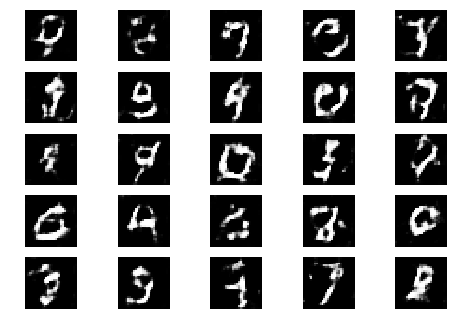

6451 [D loss: 0.999965] [G loss: 1.000053]
6452 [D loss: 0.999974] [G loss: 1.000068]
6453 [D loss: 0.999972] [G loss: 1.000045]
6454 [D loss: 0.999965] [G loss: 1.000070]
6455 [D loss: 0.999974] [G loss: 1.000073]
6456 [D loss: 0.999978] [G loss: 1.000069]
6457 [D loss: 0.999964] [G loss: 1.000054]
6458 [D loss: 0.999969] [G loss: 1.000035]
6459 [D loss: 0.999962] [G loss: 1.000069]
6460 [D loss: 0.999959] [G loss: 1.000065]
6461 [D loss: 0.999967] [G loss: 1.000072]
6462 [D loss: 0.999963] [G loss: 1.000058]
6463 [D loss: 0.999960] [G loss: 1.000039]
6464 [D loss: 0.999964] [G loss: 1.000080]
6465 [D loss: 0.999951] [G loss: 1.000037]
6466 [D loss: 0.999972] [G loss: 1.000067]
6467 [D loss: 0.999981] [G loss: 1.000074]
6468 [D loss: 0.999966] [G loss: 1.000067]
6469 [D loss: 0.999977] [G loss: 1.000062]
6470 [D loss: 0.999957] [G loss: 1.000072]
6471 [D loss: 0.999968] [G loss: 1.000064]
6472 [D loss: 0.999967] [G loss: 1.000075]
6473 [D loss: 0.999964] [G loss: 1.000062]
6474 [D los

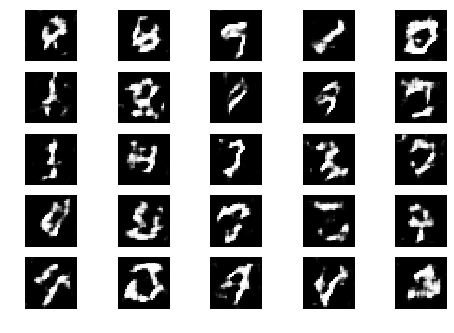

6501 [D loss: 0.999958] [G loss: 1.000057]
6502 [D loss: 0.999977] [G loss: 1.000063]
6503 [D loss: 0.999974] [G loss: 1.000077]
6504 [D loss: 0.999964] [G loss: 1.000044]
6505 [D loss: 0.999957] [G loss: 1.000089]
6506 [D loss: 0.999972] [G loss: 1.000062]
6507 [D loss: 0.999969] [G loss: 1.000062]
6508 [D loss: 0.999955] [G loss: 1.000072]
6509 [D loss: 0.999961] [G loss: 1.000036]
6510 [D loss: 0.999961] [G loss: 1.000060]
6511 [D loss: 0.999968] [G loss: 1.000071]
6512 [D loss: 0.999975] [G loss: 1.000073]
6513 [D loss: 0.999984] [G loss: 1.000048]
6514 [D loss: 0.999971] [G loss: 1.000065]
6515 [D loss: 0.999972] [G loss: 1.000066]
6516 [D loss: 0.999968] [G loss: 1.000067]
6517 [D loss: 0.999959] [G loss: 1.000070]
6518 [D loss: 0.999967] [G loss: 1.000052]
6519 [D loss: 0.999969] [G loss: 1.000059]
6520 [D loss: 0.999974] [G loss: 1.000076]
6521 [D loss: 0.999976] [G loss: 1.000062]
6522 [D loss: 0.999966] [G loss: 1.000078]
6523 [D loss: 0.999942] [G loss: 1.000057]
6524 [D los

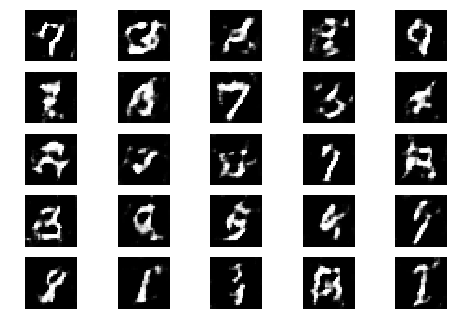

6551 [D loss: 0.999972] [G loss: 1.000081]
6552 [D loss: 0.999985] [G loss: 1.000074]
6553 [D loss: 0.999952] [G loss: 1.000072]
6554 [D loss: 0.999955] [G loss: 1.000073]
6555 [D loss: 0.999954] [G loss: 1.000070]
6556 [D loss: 0.999966] [G loss: 1.000068]
6557 [D loss: 0.999973] [G loss: 1.000070]
6558 [D loss: 0.999975] [G loss: 1.000036]
6559 [D loss: 0.999973] [G loss: 1.000078]
6560 [D loss: 0.999961] [G loss: 1.000045]
6561 [D loss: 0.999973] [G loss: 1.000078]
6562 [D loss: 0.999959] [G loss: 1.000067]
6563 [D loss: 0.999971] [G loss: 1.000078]
6564 [D loss: 0.999984] [G loss: 1.000059]
6565 [D loss: 0.999949] [G loss: 1.000032]
6566 [D loss: 0.999983] [G loss: 1.000060]
6567 [D loss: 0.999969] [G loss: 1.000079]
6568 [D loss: 0.999965] [G loss: 1.000055]
6569 [D loss: 0.999971] [G loss: 1.000064]
6570 [D loss: 0.999978] [G loss: 1.000054]
6571 [D loss: 0.999969] [G loss: 1.000066]
6572 [D loss: 0.999952] [G loss: 1.000061]
6573 [D loss: 0.999964] [G loss: 1.000073]
6574 [D los

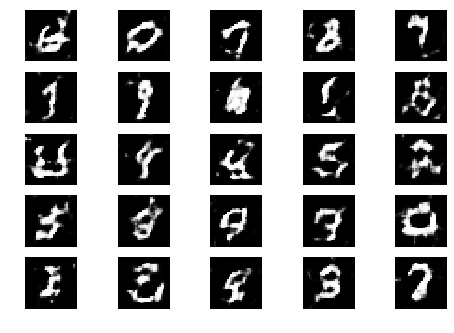

6601 [D loss: 0.999972] [G loss: 1.000090]
6602 [D loss: 0.999968] [G loss: 1.000057]
6603 [D loss: 0.999962] [G loss: 1.000059]
6604 [D loss: 0.999956] [G loss: 1.000069]
6605 [D loss: 0.999968] [G loss: 1.000060]
6606 [D loss: 0.999975] [G loss: 1.000066]
6607 [D loss: 0.999951] [G loss: 1.000071]
6608 [D loss: 0.999982] [G loss: 1.000067]
6609 [D loss: 0.999977] [G loss: 1.000077]
6610 [D loss: 0.999964] [G loss: 1.000072]
6611 [D loss: 0.999962] [G loss: 1.000035]
6612 [D loss: 0.999967] [G loss: 1.000051]
6613 [D loss: 0.999971] [G loss: 1.000056]
6614 [D loss: 0.999960] [G loss: 1.000052]
6615 [D loss: 0.999972] [G loss: 1.000067]
6616 [D loss: 0.999977] [G loss: 1.000060]
6617 [D loss: 0.999964] [G loss: 1.000065]
6618 [D loss: 0.999968] [G loss: 1.000071]
6619 [D loss: 0.999953] [G loss: 1.000053]
6620 [D loss: 0.999961] [G loss: 1.000069]
6621 [D loss: 0.999971] [G loss: 1.000040]
6622 [D loss: 0.999971] [G loss: 1.000044]
6623 [D loss: 0.999968] [G loss: 1.000080]
6624 [D los

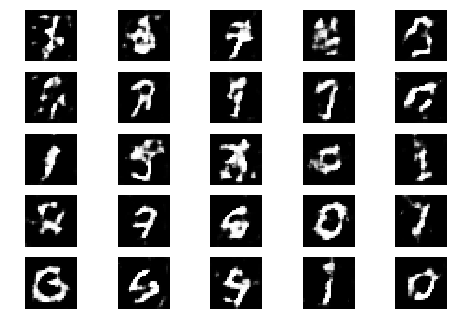

6651 [D loss: 0.999973] [G loss: 1.000054]
6652 [D loss: 0.999969] [G loss: 1.000064]
6653 [D loss: 0.999968] [G loss: 1.000069]
6654 [D loss: 0.999973] [G loss: 1.000053]
6655 [D loss: 0.999977] [G loss: 1.000061]
6656 [D loss: 0.999954] [G loss: 1.000061]
6657 [D loss: 0.999967] [G loss: 1.000062]
6658 [D loss: 0.999977] [G loss: 1.000070]
6659 [D loss: 0.999964] [G loss: 1.000047]
6660 [D loss: 0.999969] [G loss: 1.000051]
6661 [D loss: 0.999973] [G loss: 1.000078]
6662 [D loss: 0.999968] [G loss: 1.000066]
6663 [D loss: 0.999975] [G loss: 1.000062]
6664 [D loss: 0.999968] [G loss: 1.000062]
6665 [D loss: 0.999964] [G loss: 1.000065]
6666 [D loss: 0.999960] [G loss: 1.000049]
6667 [D loss: 0.999959] [G loss: 1.000072]
6668 [D loss: 0.999960] [G loss: 1.000084]
6669 [D loss: 0.999955] [G loss: 1.000065]
6670 [D loss: 0.999971] [G loss: 1.000044]
6671 [D loss: 0.999967] [G loss: 1.000071]
6672 [D loss: 0.999981] [G loss: 1.000074]
6673 [D loss: 0.999969] [G loss: 1.000059]
6674 [D los

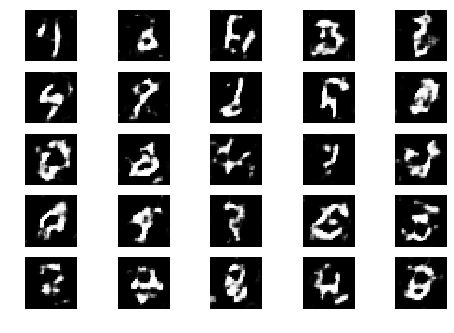

6701 [D loss: 0.999974] [G loss: 1.000068]
6702 [D loss: 0.999964] [G loss: 1.000062]
6703 [D loss: 0.999971] [G loss: 1.000045]
6704 [D loss: 0.999970] [G loss: 1.000069]
6705 [D loss: 0.999973] [G loss: 1.000057]
6706 [D loss: 0.999972] [G loss: 1.000080]
6707 [D loss: 0.999970] [G loss: 1.000080]
6708 [D loss: 0.999957] [G loss: 1.000073]
6709 [D loss: 0.999983] [G loss: 1.000076]
6710 [D loss: 0.999952] [G loss: 1.000065]
6711 [D loss: 0.999955] [G loss: 1.000075]
6712 [D loss: 0.999970] [G loss: 1.000058]
6713 [D loss: 0.999961] [G loss: 1.000079]
6714 [D loss: 0.999955] [G loss: 1.000057]
6715 [D loss: 0.999956] [G loss: 1.000070]
6716 [D loss: 0.999961] [G loss: 1.000064]
6717 [D loss: 0.999971] [G loss: 1.000073]
6718 [D loss: 0.999960] [G loss: 1.000066]
6719 [D loss: 0.999981] [G loss: 1.000069]
6720 [D loss: 0.999973] [G loss: 1.000046]
6721 [D loss: 0.999965] [G loss: 1.000052]
6722 [D loss: 0.999973] [G loss: 1.000071]
6723 [D loss: 0.999978] [G loss: 1.000062]
6724 [D los

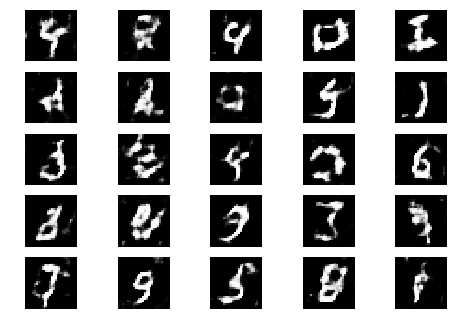

6751 [D loss: 0.999983] [G loss: 1.000057]
6752 [D loss: 0.999971] [G loss: 1.000058]
6753 [D loss: 0.999958] [G loss: 1.000042]
6754 [D loss: 0.999956] [G loss: 1.000060]
6755 [D loss: 0.999966] [G loss: 1.000040]
6756 [D loss: 0.999966] [G loss: 1.000073]
6757 [D loss: 0.999974] [G loss: 1.000072]
6758 [D loss: 0.999966] [G loss: 1.000068]
6759 [D loss: 0.999979] [G loss: 1.000093]
6760 [D loss: 0.999977] [G loss: 1.000059]
6761 [D loss: 0.999964] [G loss: 1.000071]
6762 [D loss: 0.999963] [G loss: 1.000064]
6763 [D loss: 0.999966] [G loss: 1.000066]
6764 [D loss: 0.999965] [G loss: 1.000062]
6765 [D loss: 0.999958] [G loss: 1.000082]
6766 [D loss: 0.999975] [G loss: 1.000057]
6767 [D loss: 0.999970] [G loss: 1.000077]
6768 [D loss: 0.999965] [G loss: 1.000062]
6769 [D loss: 0.999968] [G loss: 1.000059]
6770 [D loss: 0.999973] [G loss: 1.000060]
6771 [D loss: 0.999983] [G loss: 1.000072]
6772 [D loss: 0.999981] [G loss: 1.000061]
6773 [D loss: 0.999976] [G loss: 1.000056]
6774 [D los

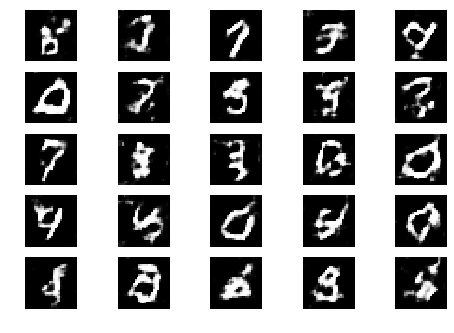

6801 [D loss: 0.999978] [G loss: 1.000074]
6802 [D loss: 0.999957] [G loss: 1.000040]
6803 [D loss: 0.999968] [G loss: 1.000089]
6804 [D loss: 0.999974] [G loss: 1.000059]
6805 [D loss: 0.999970] [G loss: 1.000073]
6806 [D loss: 0.999967] [G loss: 1.000049]
6807 [D loss: 0.999959] [G loss: 1.000066]
6808 [D loss: 0.999961] [G loss: 1.000064]
6809 [D loss: 0.999961] [G loss: 1.000059]
6810 [D loss: 0.999971] [G loss: 1.000079]
6811 [D loss: 0.999969] [G loss: 1.000065]
6812 [D loss: 0.999958] [G loss: 1.000056]
6813 [D loss: 0.999961] [G loss: 1.000057]
6814 [D loss: 0.999962] [G loss: 1.000060]
6815 [D loss: 0.999978] [G loss: 1.000057]
6816 [D loss: 0.999971] [G loss: 1.000054]
6817 [D loss: 0.999966] [G loss: 1.000080]
6818 [D loss: 0.999976] [G loss: 1.000075]
6819 [D loss: 0.999967] [G loss: 1.000068]
6820 [D loss: 0.999968] [G loss: 1.000075]
6821 [D loss: 0.999975] [G loss: 1.000070]
6822 [D loss: 0.999960] [G loss: 1.000042]
6823 [D loss: 0.999957] [G loss: 1.000052]
6824 [D los

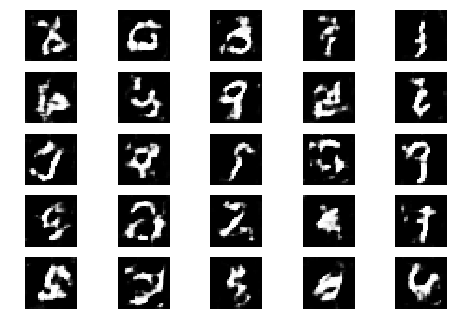

6851 [D loss: 0.999967] [G loss: 1.000062]
6852 [D loss: 0.999973] [G loss: 1.000050]
6853 [D loss: 0.999953] [G loss: 1.000076]
6854 [D loss: 0.999984] [G loss: 1.000028]
6855 [D loss: 0.999961] [G loss: 1.000063]
6856 [D loss: 0.999968] [G loss: 1.000077]
6857 [D loss: 0.999963] [G loss: 1.000067]
6858 [D loss: 0.999973] [G loss: 1.000071]
6859 [D loss: 0.999970] [G loss: 1.000072]
6860 [D loss: 0.999980] [G loss: 1.000074]
6861 [D loss: 0.999952] [G loss: 1.000070]
6862 [D loss: 0.999943] [G loss: 1.000054]
6863 [D loss: 0.999960] [G loss: 1.000080]
6864 [D loss: 0.999973] [G loss: 1.000047]
6865 [D loss: 0.999954] [G loss: 1.000080]
6866 [D loss: 0.999979] [G loss: 1.000059]
6867 [D loss: 0.999975] [G loss: 1.000050]
6868 [D loss: 0.999941] [G loss: 1.000067]
6869 [D loss: 0.999944] [G loss: 1.000057]
6870 [D loss: 0.999964] [G loss: 1.000079]
6871 [D loss: 0.999958] [G loss: 1.000069]
6872 [D loss: 0.999976] [G loss: 1.000069]
6873 [D loss: 0.999957] [G loss: 1.000052]
6874 [D los

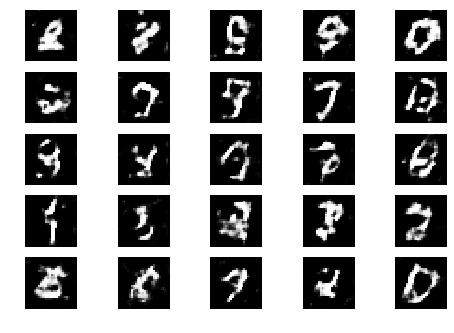

6901 [D loss: 0.999965] [G loss: 1.000064]
6902 [D loss: 0.999986] [G loss: 1.000069]
6903 [D loss: 0.999977] [G loss: 1.000040]
6904 [D loss: 0.999982] [G loss: 1.000075]
6905 [D loss: 0.999956] [G loss: 1.000088]
6906 [D loss: 0.999965] [G loss: 1.000059]
6907 [D loss: 0.999970] [G loss: 1.000061]
6908 [D loss: 0.999957] [G loss: 1.000068]
6909 [D loss: 0.999962] [G loss: 1.000054]
6910 [D loss: 0.999959] [G loss: 1.000065]
6911 [D loss: 0.999973] [G loss: 1.000055]
6912 [D loss: 0.999969] [G loss: 1.000061]
6913 [D loss: 0.999967] [G loss: 1.000065]
6914 [D loss: 0.999973] [G loss: 1.000084]
6915 [D loss: 0.999977] [G loss: 1.000073]
6916 [D loss: 0.999970] [G loss: 1.000065]
6917 [D loss: 0.999971] [G loss: 1.000071]
6918 [D loss: 0.999965] [G loss: 1.000064]
6919 [D loss: 0.999984] [G loss: 1.000063]
6920 [D loss: 0.999962] [G loss: 1.000046]
6921 [D loss: 0.999966] [G loss: 1.000062]
6922 [D loss: 0.999955] [G loss: 1.000060]
6923 [D loss: 0.999967] [G loss: 1.000068]
6924 [D los

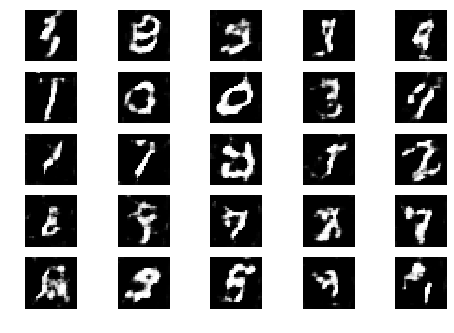

6951 [D loss: 0.999962] [G loss: 1.000078]
6952 [D loss: 0.999968] [G loss: 1.000062]
6953 [D loss: 0.999972] [G loss: 1.000048]
6954 [D loss: 0.999970] [G loss: 1.000069]
6955 [D loss: 0.999978] [G loss: 1.000090]
6956 [D loss: 0.999974] [G loss: 1.000056]
6957 [D loss: 0.999968] [G loss: 1.000051]
6958 [D loss: 0.999974] [G loss: 1.000050]
6959 [D loss: 0.999972] [G loss: 1.000046]
6960 [D loss: 0.999960] [G loss: 1.000070]
6961 [D loss: 0.999964] [G loss: 1.000047]
6962 [D loss: 0.999965] [G loss: 1.000048]
6963 [D loss: 0.999951] [G loss: 1.000042]
6964 [D loss: 0.999967] [G loss: 1.000062]
6965 [D loss: 0.999964] [G loss: 1.000078]
6966 [D loss: 0.999973] [G loss: 1.000075]
6967 [D loss: 0.999972] [G loss: 1.000061]
6968 [D loss: 0.999980] [G loss: 1.000068]
6969 [D loss: 0.999974] [G loss: 1.000083]
6970 [D loss: 0.999975] [G loss: 1.000085]
6971 [D loss: 0.999963] [G loss: 1.000067]
6972 [D loss: 0.999959] [G loss: 1.000066]
6973 [D loss: 0.999974] [G loss: 1.000053]
6974 [D los

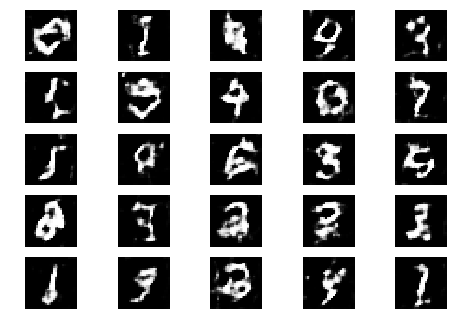

7001 [D loss: 0.999982] [G loss: 1.000050]
7002 [D loss: 0.999980] [G loss: 1.000055]
7003 [D loss: 0.999972] [G loss: 1.000059]
7004 [D loss: 0.999980] [G loss: 1.000067]
7005 [D loss: 0.999974] [G loss: 1.000074]
7006 [D loss: 0.999962] [G loss: 1.000050]
7007 [D loss: 0.999970] [G loss: 1.000047]
7008 [D loss: 0.999962] [G loss: 1.000067]
7009 [D loss: 0.999958] [G loss: 1.000053]
7010 [D loss: 0.999957] [G loss: 1.000065]
7011 [D loss: 0.999976] [G loss: 1.000050]
7012 [D loss: 0.999958] [G loss: 1.000072]
7013 [D loss: 0.999960] [G loss: 1.000059]
7014 [D loss: 0.999967] [G loss: 1.000073]
7015 [D loss: 0.999962] [G loss: 1.000056]
7016 [D loss: 0.999967] [G loss: 1.000070]
7017 [D loss: 0.999966] [G loss: 1.000058]
7018 [D loss: 0.999979] [G loss: 1.000060]
7019 [D loss: 0.999973] [G loss: 1.000043]
7020 [D loss: 0.999957] [G loss: 1.000065]
7021 [D loss: 0.999966] [G loss: 1.000063]
7022 [D loss: 0.999961] [G loss: 1.000058]
7023 [D loss: 0.999972] [G loss: 1.000045]
7024 [D los

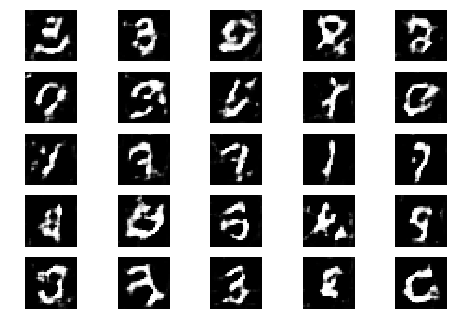

7051 [D loss: 0.999975] [G loss: 1.000070]
7052 [D loss: 0.999970] [G loss: 1.000053]
7053 [D loss: 0.999972] [G loss: 1.000093]
7054 [D loss: 0.999972] [G loss: 1.000047]
7055 [D loss: 0.999969] [G loss: 1.000068]
7056 [D loss: 0.999961] [G loss: 1.000077]
7057 [D loss: 0.999969] [G loss: 1.000075]
7058 [D loss: 0.999982] [G loss: 1.000062]
7059 [D loss: 0.999962] [G loss: 1.000064]
7060 [D loss: 0.999973] [G loss: 1.000078]
7061 [D loss: 0.999972] [G loss: 1.000057]
7062 [D loss: 0.999974] [G loss: 1.000063]
7063 [D loss: 0.999975] [G loss: 1.000060]
7064 [D loss: 0.999983] [G loss: 1.000037]
7065 [D loss: 0.999968] [G loss: 1.000070]
7066 [D loss: 0.999948] [G loss: 1.000062]
7067 [D loss: 0.999968] [G loss: 1.000072]
7068 [D loss: 0.999958] [G loss: 1.000087]
7069 [D loss: 0.999966] [G loss: 1.000070]
7070 [D loss: 0.999967] [G loss: 1.000063]
7071 [D loss: 0.999983] [G loss: 1.000074]
7072 [D loss: 0.999973] [G loss: 1.000061]
7073 [D loss: 0.999965] [G loss: 1.000072]
7074 [D los

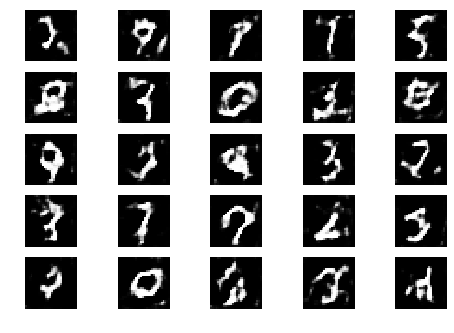

7101 [D loss: 0.999974] [G loss: 1.000039]
7102 [D loss: 0.999959] [G loss: 1.000108]
7103 [D loss: 0.999970] [G loss: 1.000068]
7104 [D loss: 0.999944] [G loss: 1.000063]
7105 [D loss: 0.999962] [G loss: 1.000051]
7106 [D loss: 0.999959] [G loss: 1.000054]
7107 [D loss: 0.999979] [G loss: 1.000060]
7108 [D loss: 0.999956] [G loss: 1.000047]
7109 [D loss: 0.999974] [G loss: 1.000071]
7110 [D loss: 0.999971] [G loss: 1.000068]
7111 [D loss: 0.999973] [G loss: 1.000062]
7112 [D loss: 0.999969] [G loss: 1.000086]
7113 [D loss: 0.999967] [G loss: 1.000058]
7114 [D loss: 0.999959] [G loss: 1.000050]
7115 [D loss: 0.999978] [G loss: 1.000058]
7116 [D loss: 0.999964] [G loss: 1.000058]
7117 [D loss: 0.999976] [G loss: 1.000077]
7118 [D loss: 0.999977] [G loss: 1.000051]
7119 [D loss: 0.999982] [G loss: 1.000066]
7120 [D loss: 0.999971] [G loss: 1.000060]
7121 [D loss: 0.999966] [G loss: 1.000028]
7122 [D loss: 0.999964] [G loss: 1.000057]
7123 [D loss: 0.999975] [G loss: 1.000035]
7124 [D los

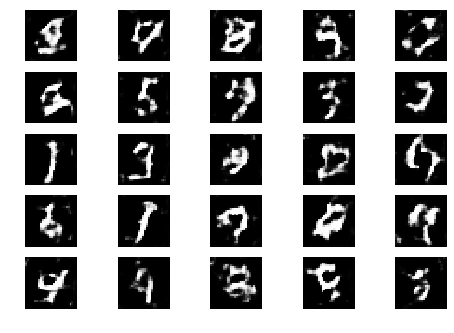

7151 [D loss: 0.999978] [G loss: 1.000072]
7152 [D loss: 0.999961] [G loss: 1.000075]
7153 [D loss: 0.999959] [G loss: 1.000080]
7154 [D loss: 0.999982] [G loss: 1.000056]
7155 [D loss: 0.999962] [G loss: 1.000078]
7156 [D loss: 0.999955] [G loss: 1.000066]
7157 [D loss: 0.999957] [G loss: 1.000057]
7158 [D loss: 0.999973] [G loss: 1.000068]
7159 [D loss: 0.999970] [G loss: 1.000050]
7160 [D loss: 0.999978] [G loss: 1.000084]
7161 [D loss: 0.999969] [G loss: 1.000062]
7162 [D loss: 0.999974] [G loss: 1.000073]
7163 [D loss: 0.999953] [G loss: 1.000056]
7164 [D loss: 0.999968] [G loss: 1.000059]
7165 [D loss: 0.999954] [G loss: 1.000055]
7166 [D loss: 0.999966] [G loss: 1.000078]
7167 [D loss: 0.999957] [G loss: 1.000029]
7168 [D loss: 0.999971] [G loss: 1.000062]
7169 [D loss: 0.999965] [G loss: 1.000073]
7170 [D loss: 0.999964] [G loss: 1.000068]
7171 [D loss: 0.999973] [G loss: 1.000072]
7172 [D loss: 0.999966] [G loss: 1.000051]
7173 [D loss: 0.999970] [G loss: 1.000055]
7174 [D los

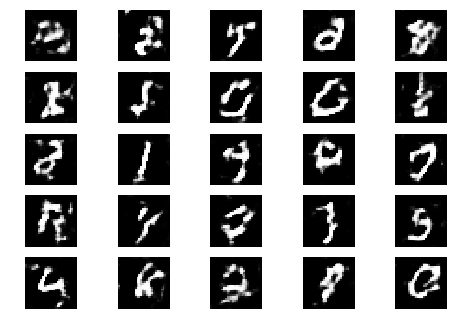

7201 [D loss: 0.999972] [G loss: 1.000065]
7202 [D loss: 0.999978] [G loss: 1.000059]
7203 [D loss: 0.999954] [G loss: 1.000064]
7204 [D loss: 0.999969] [G loss: 1.000085]
7205 [D loss: 0.999967] [G loss: 1.000048]
7206 [D loss: 0.999975] [G loss: 1.000051]
7207 [D loss: 0.999966] [G loss: 1.000091]
7208 [D loss: 0.999974] [G loss: 1.000094]
7209 [D loss: 0.999965] [G loss: 1.000079]
7210 [D loss: 0.999970] [G loss: 1.000053]
7211 [D loss: 0.999966] [G loss: 1.000046]
7212 [D loss: 0.999977] [G loss: 1.000035]
7213 [D loss: 0.999958] [G loss: 1.000065]
7214 [D loss: 0.999973] [G loss: 1.000043]
7215 [D loss: 0.999989] [G loss: 1.000037]
7216 [D loss: 0.999965] [G loss: 1.000084]
7217 [D loss: 0.999949] [G loss: 1.000044]
7218 [D loss: 0.999973] [G loss: 1.000074]
7219 [D loss: 0.999960] [G loss: 1.000086]
7220 [D loss: 0.999965] [G loss: 1.000049]
7221 [D loss: 1.000000] [G loss: 1.000077]
7222 [D loss: 0.999998] [G loss: 1.000084]
7223 [D loss: 0.999955] [G loss: 1.000063]
7224 [D los

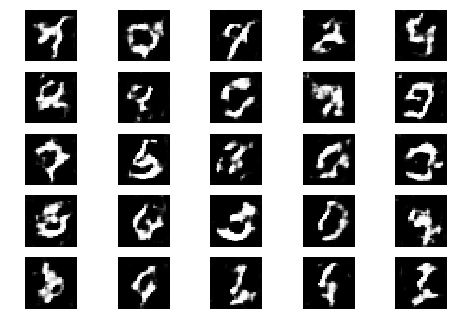

7251 [D loss: 0.999953] [G loss: 1.000081]
7252 [D loss: 0.999968] [G loss: 1.000068]
7253 [D loss: 0.999966] [G loss: 1.000045]
7254 [D loss: 0.999955] [G loss: 1.000055]
7255 [D loss: 0.999948] [G loss: 1.000078]
7256 [D loss: 0.999988] [G loss: 1.000053]
7257 [D loss: 0.999972] [G loss: 1.000052]
7258 [D loss: 0.999964] [G loss: 1.000059]
7259 [D loss: 0.999957] [G loss: 1.000057]
7260 [D loss: 0.999962] [G loss: 1.000051]
7261 [D loss: 0.999978] [G loss: 1.000060]
7262 [D loss: 0.999965] [G loss: 1.000084]
7263 [D loss: 0.999966] [G loss: 1.000047]
7264 [D loss: 0.999979] [G loss: 1.000041]
7265 [D loss: 0.999981] [G loss: 1.000067]
7266 [D loss: 0.999965] [G loss: 1.000069]
7267 [D loss: 0.999968] [G loss: 1.000071]
7268 [D loss: 0.999972] [G loss: 1.000064]
7269 [D loss: 0.999964] [G loss: 1.000077]
7270 [D loss: 0.999971] [G loss: 1.000077]
7271 [D loss: 0.999942] [G loss: 1.000080]
7272 [D loss: 0.999952] [G loss: 1.000069]
7273 [D loss: 0.999964] [G loss: 1.000067]
7274 [D los

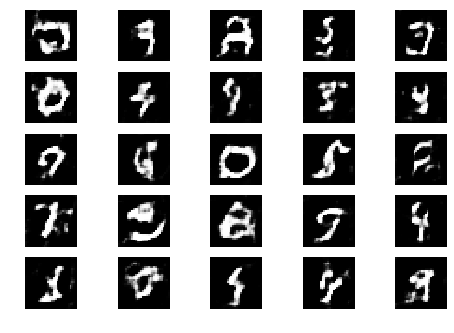

7301 [D loss: 0.999966] [G loss: 1.000074]
7302 [D loss: 0.999972] [G loss: 1.000074]
7303 [D loss: 0.999964] [G loss: 1.000054]
7304 [D loss: 0.999951] [G loss: 1.000054]
7305 [D loss: 0.999967] [G loss: 1.000052]
7306 [D loss: 0.999963] [G loss: 1.000078]
7307 [D loss: 0.999954] [G loss: 1.000073]
7308 [D loss: 0.999961] [G loss: 1.000076]
7309 [D loss: 0.999969] [G loss: 1.000064]
7310 [D loss: 0.999974] [G loss: 1.000064]
7311 [D loss: 0.999959] [G loss: 1.000063]
7312 [D loss: 0.999969] [G loss: 1.000046]
7313 [D loss: 0.999965] [G loss: 1.000085]
7314 [D loss: 0.999966] [G loss: 1.000072]
7315 [D loss: 0.999971] [G loss: 1.000075]
7316 [D loss: 0.999960] [G loss: 1.000047]
7317 [D loss: 0.999977] [G loss: 1.000074]
7318 [D loss: 0.999983] [G loss: 1.000064]
7319 [D loss: 0.999966] [G loss: 1.000072]
7320 [D loss: 0.999959] [G loss: 1.000038]
7321 [D loss: 0.999972] [G loss: 1.000057]
7322 [D loss: 0.999968] [G loss: 1.000066]
7323 [D loss: 0.999962] [G loss: 1.000054]
7324 [D los

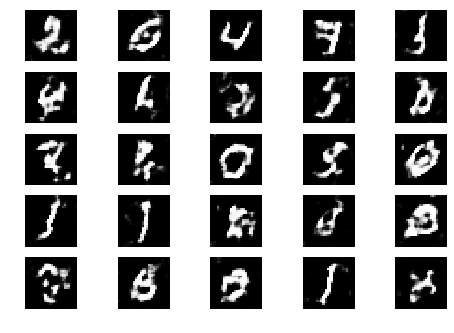

7351 [D loss: 0.999961] [G loss: 1.000059]
7352 [D loss: 0.999979] [G loss: 1.000048]
7353 [D loss: 0.999956] [G loss: 1.000051]
7354 [D loss: 0.999955] [G loss: 1.000090]
7355 [D loss: 0.999967] [G loss: 1.000040]
7356 [D loss: 0.999959] [G loss: 1.000054]
7357 [D loss: 0.999945] [G loss: 1.000061]
7358 [D loss: 0.999964] [G loss: 1.000065]
7359 [D loss: 0.999970] [G loss: 1.000061]
7360 [D loss: 0.999963] [G loss: 1.000071]
7361 [D loss: 0.999979] [G loss: 1.000057]
7362 [D loss: 0.999970] [G loss: 1.000051]
7363 [D loss: 0.999974] [G loss: 1.000073]
7364 [D loss: 0.999973] [G loss: 1.000068]
7365 [D loss: 0.999957] [G loss: 1.000071]
7366 [D loss: 0.999963] [G loss: 1.000066]
7367 [D loss: 0.999972] [G loss: 1.000070]
7368 [D loss: 0.999969] [G loss: 1.000062]
7369 [D loss: 0.999986] [G loss: 1.000068]
7370 [D loss: 0.999965] [G loss: 1.000062]
7371 [D loss: 0.999967] [G loss: 1.000056]
7372 [D loss: 0.999976] [G loss: 1.000074]
7373 [D loss: 0.999961] [G loss: 1.000070]
7374 [D los

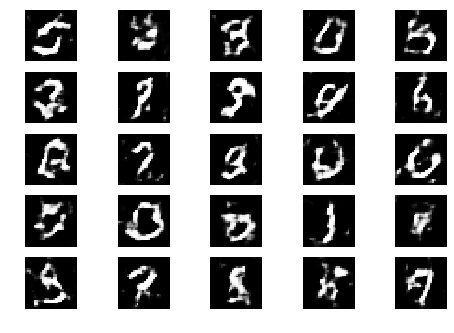

7401 [D loss: 0.999965] [G loss: 1.000037]
7402 [D loss: 0.999954] [G loss: 1.000050]
7403 [D loss: 0.999969] [G loss: 1.000071]
7404 [D loss: 0.999964] [G loss: 1.000079]
7405 [D loss: 0.999966] [G loss: 1.000056]
7406 [D loss: 0.999971] [G loss: 1.000041]
7407 [D loss: 0.999969] [G loss: 1.000070]
7408 [D loss: 0.999975] [G loss: 1.000062]
7409 [D loss: 0.999972] [G loss: 1.000059]
7410 [D loss: 0.999985] [G loss: 1.000063]
7411 [D loss: 0.999945] [G loss: 1.000060]
7412 [D loss: 0.999957] [G loss: 1.000071]
7413 [D loss: 0.999960] [G loss: 1.000069]
7414 [D loss: 0.999966] [G loss: 1.000060]
7415 [D loss: 0.999956] [G loss: 1.000040]
7416 [D loss: 0.999972] [G loss: 1.000075]
7417 [D loss: 0.999959] [G loss: 1.000086]
7418 [D loss: 0.999960] [G loss: 1.000045]
7419 [D loss: 0.999968] [G loss: 1.000085]
7420 [D loss: 0.999965] [G loss: 1.000052]
7421 [D loss: 0.999969] [G loss: 1.000061]
7422 [D loss: 0.999969] [G loss: 1.000068]
7423 [D loss: 0.999966] [G loss: 1.000058]
7424 [D los

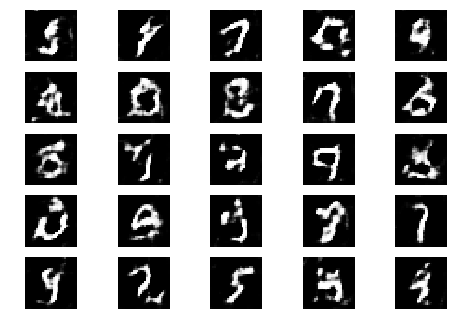

7451 [D loss: 0.999968] [G loss: 1.000055]
7452 [D loss: 0.999968] [G loss: 1.000091]
7453 [D loss: 0.999950] [G loss: 1.000051]
7454 [D loss: 0.999954] [G loss: 1.000060]
7455 [D loss: 0.999975] [G loss: 1.000062]
7456 [D loss: 0.999974] [G loss: 1.000073]
7457 [D loss: 0.999961] [G loss: 1.000047]
7458 [D loss: 0.999959] [G loss: 1.000065]
7459 [D loss: 0.999973] [G loss: 1.000076]
7460 [D loss: 0.999970] [G loss: 1.000062]
7461 [D loss: 0.999961] [G loss: 1.000068]
7462 [D loss: 0.999963] [G loss: 1.000049]
7463 [D loss: 0.999960] [G loss: 1.000058]
7464 [D loss: 0.999955] [G loss: 1.000072]
7465 [D loss: 0.999967] [G loss: 1.000080]
7466 [D loss: 0.999960] [G loss: 1.000051]
7467 [D loss: 0.999961] [G loss: 1.000063]
7468 [D loss: 0.999972] [G loss: 1.000032]
7469 [D loss: 0.999969] [G loss: 1.000063]
7470 [D loss: 0.999948] [G loss: 1.000066]
7471 [D loss: 0.999948] [G loss: 1.000066]
7472 [D loss: 0.999985] [G loss: 1.000072]
7473 [D loss: 0.999950] [G loss: 1.000040]
7474 [D los

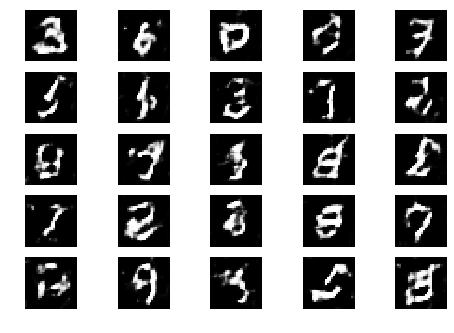

7501 [D loss: 0.999981] [G loss: 1.000080]
7502 [D loss: 0.999959] [G loss: 1.000064]
7503 [D loss: 0.999961] [G loss: 1.000056]
7504 [D loss: 0.999973] [G loss: 1.000086]
7505 [D loss: 0.999986] [G loss: 1.000054]
7506 [D loss: 0.999966] [G loss: 1.000059]
7507 [D loss: 0.999975] [G loss: 1.000061]
7508 [D loss: 0.999967] [G loss: 1.000035]
7509 [D loss: 0.999975] [G loss: 1.000056]
7510 [D loss: 0.999963] [G loss: 1.000059]
7511 [D loss: 0.999966] [G loss: 1.000042]
7512 [D loss: 0.999958] [G loss: 1.000053]
7513 [D loss: 0.999952] [G loss: 1.000034]
7514 [D loss: 0.999966] [G loss: 1.000048]
7515 [D loss: 0.999962] [G loss: 1.000062]
7516 [D loss: 0.999980] [G loss: 1.000074]
7517 [D loss: 0.999972] [G loss: 1.000053]
7518 [D loss: 0.999977] [G loss: 1.000061]
7519 [D loss: 0.999971] [G loss: 1.000033]
7520 [D loss: 0.999948] [G loss: 1.000048]
7521 [D loss: 0.999976] [G loss: 1.000049]
7522 [D loss: 0.999976] [G loss: 1.000026]
7523 [D loss: 0.999979] [G loss: 1.000055]
7524 [D los

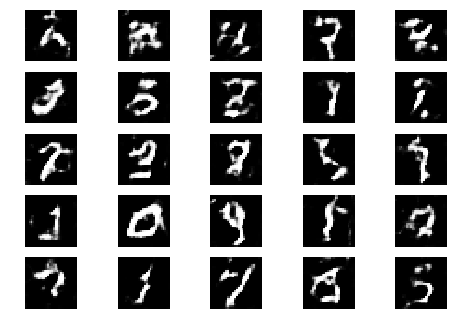

7551 [D loss: 0.999976] [G loss: 1.000073]
7552 [D loss: 0.999968] [G loss: 1.000047]
7553 [D loss: 0.999977] [G loss: 1.000068]
7554 [D loss: 0.999965] [G loss: 1.000049]
7555 [D loss: 0.999952] [G loss: 1.000060]
7556 [D loss: 0.999953] [G loss: 1.000049]
7557 [D loss: 0.999960] [G loss: 1.000072]
7558 [D loss: 0.999955] [G loss: 1.000063]
7559 [D loss: 0.999976] [G loss: 1.000046]
7560 [D loss: 0.999971] [G loss: 1.000048]
7561 [D loss: 0.999963] [G loss: 1.000055]
7562 [D loss: 0.999947] [G loss: 1.000077]
7563 [D loss: 0.999963] [G loss: 1.000063]
7564 [D loss: 0.999956] [G loss: 1.000077]
7565 [D loss: 0.999975] [G loss: 1.000060]
7566 [D loss: 0.999971] [G loss: 1.000024]
7567 [D loss: 0.999961] [G loss: 1.000061]
7568 [D loss: 0.999959] [G loss: 1.000070]
7569 [D loss: 0.999973] [G loss: 1.000053]
7570 [D loss: 0.999975] [G loss: 1.000061]
7571 [D loss: 0.999954] [G loss: 1.000058]
7572 [D loss: 0.999982] [G loss: 1.000051]
7573 [D loss: 0.999964] [G loss: 1.000056]
7574 [D los

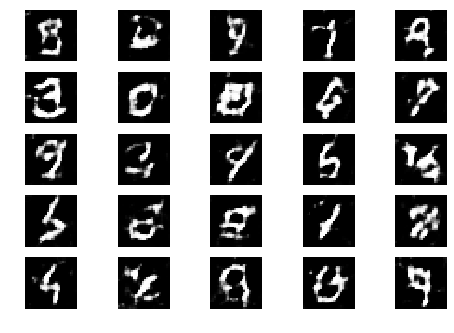

7601 [D loss: 0.999981] [G loss: 1.000063]
7602 [D loss: 0.999979] [G loss: 1.000069]
7603 [D loss: 0.999948] [G loss: 1.000061]
7604 [D loss: 0.999956] [G loss: 1.000075]
7605 [D loss: 0.999958] [G loss: 1.000048]
7606 [D loss: 0.999970] [G loss: 1.000082]
7607 [D loss: 0.999965] [G loss: 1.000045]
7608 [D loss: 0.999974] [G loss: 1.000081]
7609 [D loss: 0.999968] [G loss: 1.000075]
7610 [D loss: 0.999962] [G loss: 1.000056]
7611 [D loss: 0.999968] [G loss: 1.000081]
7612 [D loss: 0.999974] [G loss: 1.000061]
7613 [D loss: 0.999982] [G loss: 1.000048]
7614 [D loss: 0.999957] [G loss: 1.000046]
7615 [D loss: 0.999980] [G loss: 1.000064]
7616 [D loss: 0.999960] [G loss: 1.000056]
7617 [D loss: 0.999958] [G loss: 1.000062]
7618 [D loss: 0.999977] [G loss: 1.000046]
7619 [D loss: 0.999952] [G loss: 1.000050]
7620 [D loss: 0.999965] [G loss: 1.000066]
7621 [D loss: 0.999982] [G loss: 1.000071]
7622 [D loss: 0.999983] [G loss: 1.000074]
7623 [D loss: 0.999962] [G loss: 1.000057]
7624 [D los

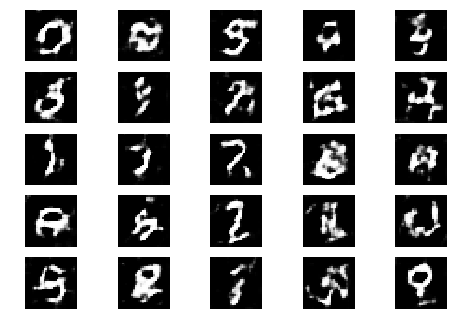

7651 [D loss: 0.999966] [G loss: 1.000048]
7652 [D loss: 0.999962] [G loss: 1.000084]
7653 [D loss: 0.999965] [G loss: 1.000057]
7654 [D loss: 0.999972] [G loss: 1.000063]
7655 [D loss: 0.999971] [G loss: 1.000062]
7656 [D loss: 0.999959] [G loss: 1.000062]
7657 [D loss: 0.999966] [G loss: 1.000065]
7658 [D loss: 0.999979] [G loss: 1.000065]
7659 [D loss: 0.999975] [G loss: 1.000057]
7660 [D loss: 0.999970] [G loss: 1.000047]
7661 [D loss: 0.999979] [G loss: 1.000052]
7662 [D loss: 0.999964] [G loss: 1.000040]
7663 [D loss: 0.999962] [G loss: 1.000074]
7664 [D loss: 0.999965] [G loss: 1.000084]
7665 [D loss: 0.999964] [G loss: 1.000055]
7666 [D loss: 0.999968] [G loss: 1.000051]
7667 [D loss: 0.999962] [G loss: 1.000066]
7668 [D loss: 0.999975] [G loss: 1.000055]
7669 [D loss: 0.999972] [G loss: 1.000070]
7670 [D loss: 0.999971] [G loss: 1.000061]
7671 [D loss: 0.999975] [G loss: 1.000054]
7672 [D loss: 0.999973] [G loss: 1.000051]
7673 [D loss: 0.999967] [G loss: 1.000066]
7674 [D los

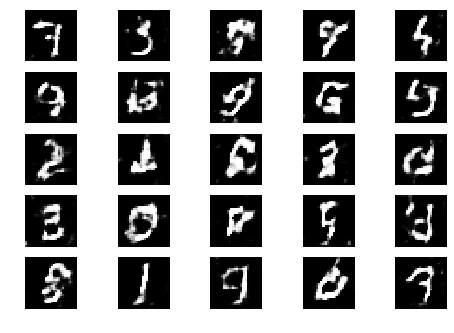

7701 [D loss: 0.999976] [G loss: 1.000047]
7702 [D loss: 0.999988] [G loss: 1.000038]
7703 [D loss: 0.999975] [G loss: 1.000043]
7704 [D loss: 0.999956] [G loss: 1.000008]
7705 [D loss: 0.999968] [G loss: 1.000057]
7706 [D loss: 0.999980] [G loss: 1.000055]
7707 [D loss: 0.999965] [G loss: 1.000100]
7708 [D loss: 0.999965] [G loss: 1.000069]
7709 [D loss: 0.999955] [G loss: 1.000061]
7710 [D loss: 0.999965] [G loss: 1.000061]
7711 [D loss: 0.999975] [G loss: 1.000052]
7712 [D loss: 0.999983] [G loss: 1.000046]
7713 [D loss: 0.999987] [G loss: 1.000027]
7714 [D loss: 0.999979] [G loss: 1.000044]
7715 [D loss: 0.999975] [G loss: 1.000069]
7716 [D loss: 0.999969] [G loss: 1.000073]
7717 [D loss: 0.999965] [G loss: 1.000055]
7718 [D loss: 0.999977] [G loss: 1.000068]
7719 [D loss: 0.999963] [G loss: 1.000028]
7720 [D loss: 0.999975] [G loss: 1.000072]
7721 [D loss: 0.999984] [G loss: 1.000063]
7722 [D loss: 0.999970] [G loss: 1.000060]
7723 [D loss: 0.999971] [G loss: 1.000076]
7724 [D los

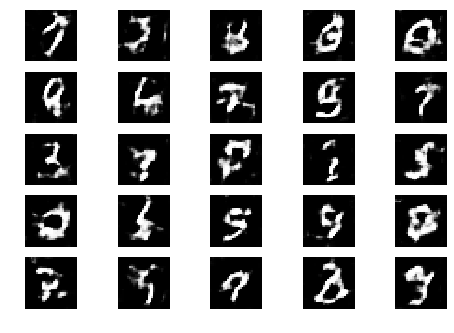

7751 [D loss: 0.999974] [G loss: 1.000066]
7752 [D loss: 0.999968] [G loss: 1.000068]
7753 [D loss: 0.999971] [G loss: 1.000034]
7754 [D loss: 0.999975] [G loss: 1.000054]
7755 [D loss: 0.999972] [G loss: 1.000069]
7756 [D loss: 0.999975] [G loss: 1.000062]
7757 [D loss: 0.999966] [G loss: 1.000067]
7758 [D loss: 0.999961] [G loss: 1.000061]
7759 [D loss: 0.999954] [G loss: 1.000053]
7760 [D loss: 0.999983] [G loss: 1.000080]
7761 [D loss: 0.999964] [G loss: 1.000059]
7762 [D loss: 0.999960] [G loss: 1.000065]
7763 [D loss: 0.999957] [G loss: 1.000066]
7764 [D loss: 0.999968] [G loss: 1.000069]
7765 [D loss: 0.999977] [G loss: 1.000059]
7766 [D loss: 0.999961] [G loss: 1.000084]
7767 [D loss: 0.999962] [G loss: 1.000061]
7768 [D loss: 0.999979] [G loss: 1.000068]
7769 [D loss: 0.999974] [G loss: 1.000065]
7770 [D loss: 0.999967] [G loss: 1.000068]
7771 [D loss: 0.999979] [G loss: 1.000041]
7772 [D loss: 0.999977] [G loss: 1.000071]
7773 [D loss: 0.999968] [G loss: 1.000063]
7774 [D los

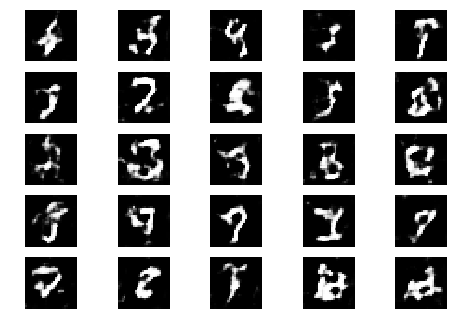

7801 [D loss: 0.999964] [G loss: 1.000071]
7802 [D loss: 0.999994] [G loss: 1.000069]
7803 [D loss: 0.999963] [G loss: 1.000083]
7804 [D loss: 0.999984] [G loss: 1.000038]
7805 [D loss: 0.999962] [G loss: 1.000080]
7806 [D loss: 0.999983] [G loss: 1.000062]
7807 [D loss: 0.999964] [G loss: 1.000050]
7808 [D loss: 0.999975] [G loss: 1.000045]
7809 [D loss: 0.999971] [G loss: 1.000065]
7810 [D loss: 0.999948] [G loss: 1.000079]
7811 [D loss: 0.999978] [G loss: 1.000074]
7812 [D loss: 0.999966] [G loss: 1.000056]
7813 [D loss: 0.999959] [G loss: 1.000056]
7814 [D loss: 0.999953] [G loss: 1.000059]
7815 [D loss: 0.999965] [G loss: 1.000029]
7816 [D loss: 0.999987] [G loss: 1.000070]
7817 [D loss: 0.999948] [G loss: 1.000072]
7818 [D loss: 0.999955] [G loss: 1.000051]
7819 [D loss: 0.999974] [G loss: 1.000041]
7820 [D loss: 0.999952] [G loss: 1.000052]
7821 [D loss: 0.999971] [G loss: 1.000057]
7822 [D loss: 0.999962] [G loss: 1.000040]
7823 [D loss: 0.999958] [G loss: 1.000066]
7824 [D los

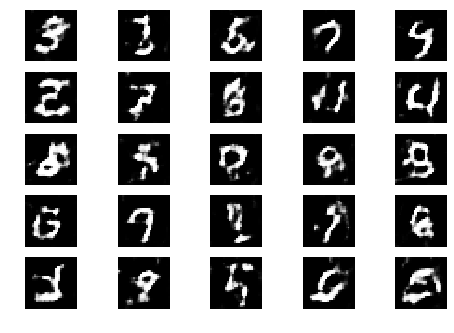

7851 [D loss: 0.999965] [G loss: 1.000058]
7852 [D loss: 0.999952] [G loss: 1.000065]
7853 [D loss: 0.999964] [G loss: 1.000065]
7854 [D loss: 0.999978] [G loss: 1.000052]
7855 [D loss: 0.999952] [G loss: 1.000056]
7856 [D loss: 0.999962] [G loss: 1.000078]
7857 [D loss: 0.999971] [G loss: 1.000076]
7858 [D loss: 0.999973] [G loss: 1.000083]
7859 [D loss: 0.999972] [G loss: 1.000072]
7860 [D loss: 0.999970] [G loss: 1.000063]
7861 [D loss: 0.999974] [G loss: 1.000056]
7862 [D loss: 0.999973] [G loss: 1.000067]
7863 [D loss: 0.999964] [G loss: 1.000061]
7864 [D loss: 0.999979] [G loss: 1.000057]
7865 [D loss: 0.999970] [G loss: 1.000056]
7866 [D loss: 0.999970] [G loss: 1.000056]
7867 [D loss: 0.999973] [G loss: 1.000057]
7868 [D loss: 0.999971] [G loss: 1.000062]
7869 [D loss: 0.999955] [G loss: 1.000048]
7870 [D loss: 0.999967] [G loss: 1.000058]
7871 [D loss: 0.999969] [G loss: 1.000064]
7872 [D loss: 0.999961] [G loss: 1.000069]
7873 [D loss: 0.999963] [G loss: 1.000054]
7874 [D los

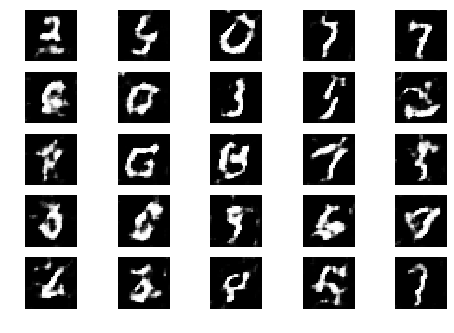

7901 [D loss: 0.999976] [G loss: 1.000053]
7902 [D loss: 0.999960] [G loss: 1.000056]
7903 [D loss: 0.999961] [G loss: 1.000053]
7904 [D loss: 0.999957] [G loss: 1.000069]
7905 [D loss: 0.999980] [G loss: 1.000077]
7906 [D loss: 0.999979] [G loss: 1.000055]
7907 [D loss: 0.999960] [G loss: 1.000068]
7908 [D loss: 0.999966] [G loss: 1.000067]
7909 [D loss: 0.999971] [G loss: 1.000058]
7910 [D loss: 0.999982] [G loss: 1.000073]
7911 [D loss: 0.999969] [G loss: 1.000035]
7912 [D loss: 0.999955] [G loss: 1.000064]
7913 [D loss: 0.999975] [G loss: 1.000073]
7914 [D loss: 0.999955] [G loss: 1.000078]
7915 [D loss: 0.999973] [G loss: 1.000076]
7916 [D loss: 0.999951] [G loss: 1.000092]
7917 [D loss: 0.999970] [G loss: 1.000082]
7918 [D loss: 0.999946] [G loss: 1.000048]
7919 [D loss: 0.999966] [G loss: 1.000066]
7920 [D loss: 0.999968] [G loss: 1.000073]
7921 [D loss: 0.999964] [G loss: 1.000063]
7922 [D loss: 0.999956] [G loss: 1.000065]
7923 [D loss: 0.999973] [G loss: 1.000068]
7924 [D los

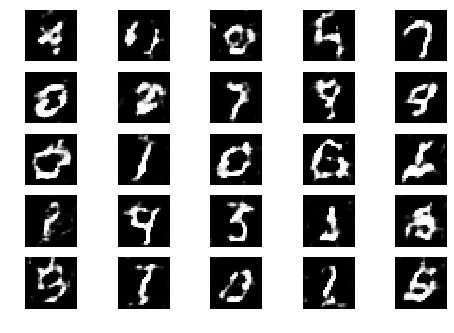

7951 [D loss: 0.999977] [G loss: 1.000049]
7952 [D loss: 0.999981] [G loss: 1.000048]
7953 [D loss: 0.999958] [G loss: 1.000056]
7954 [D loss: 0.999974] [G loss: 1.000059]
7955 [D loss: 0.999976] [G loss: 1.000060]
7956 [D loss: 0.999970] [G loss: 1.000063]
7957 [D loss: 0.999975] [G loss: 1.000043]
7958 [D loss: 0.999958] [G loss: 1.000034]
7959 [D loss: 0.999954] [G loss: 1.000051]
7960 [D loss: 0.999960] [G loss: 1.000072]
7961 [D loss: 0.999960] [G loss: 1.000065]
7962 [D loss: 0.999974] [G loss: 1.000047]
7963 [D loss: 0.999960] [G loss: 1.000073]
7964 [D loss: 0.999965] [G loss: 1.000057]
7965 [D loss: 0.999968] [G loss: 1.000062]
7966 [D loss: 0.999959] [G loss: 1.000070]
7967 [D loss: 0.999973] [G loss: 1.000070]
7968 [D loss: 0.999964] [G loss: 1.000062]
7969 [D loss: 0.999975] [G loss: 1.000078]
7970 [D loss: 0.999966] [G loss: 1.000051]
7971 [D loss: 0.999967] [G loss: 1.000058]
7972 [D loss: 0.999981] [G loss: 1.000065]
7973 [D loss: 0.999973] [G loss: 1.000063]
7974 [D los

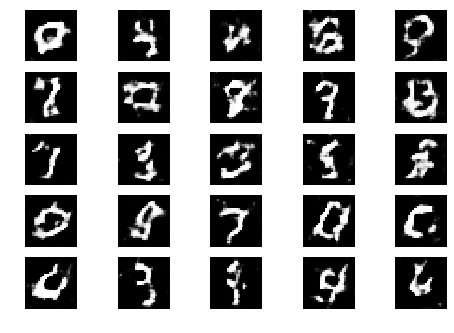

8001 [D loss: 0.999963] [G loss: 1.000062]
8002 [D loss: 0.999974] [G loss: 1.000074]
8003 [D loss: 0.999967] [G loss: 1.000061]
8004 [D loss: 0.999957] [G loss: 1.000058]
8005 [D loss: 0.999968] [G loss: 1.000074]
8006 [D loss: 0.999978] [G loss: 1.000065]
8007 [D loss: 0.999970] [G loss: 1.000064]
8008 [D loss: 0.999973] [G loss: 1.000026]
8009 [D loss: 0.999967] [G loss: 1.000051]
8010 [D loss: 0.999964] [G loss: 1.000062]
8011 [D loss: 0.999967] [G loss: 1.000053]
8012 [D loss: 0.999974] [G loss: 1.000058]
8013 [D loss: 0.999990] [G loss: 1.000044]
8014 [D loss: 0.999977] [G loss: 1.000056]
8015 [D loss: 0.999963] [G loss: 1.000044]
8016 [D loss: 0.999962] [G loss: 1.000046]
8017 [D loss: 0.999958] [G loss: 1.000067]
8018 [D loss: 0.999945] [G loss: 1.000059]
8019 [D loss: 0.999963] [G loss: 1.000073]
8020 [D loss: 0.999971] [G loss: 1.000066]
8021 [D loss: 0.999976] [G loss: 1.000059]
8022 [D loss: 0.999947] [G loss: 1.000089]
8023 [D loss: 0.999981] [G loss: 1.000075]
8024 [D los

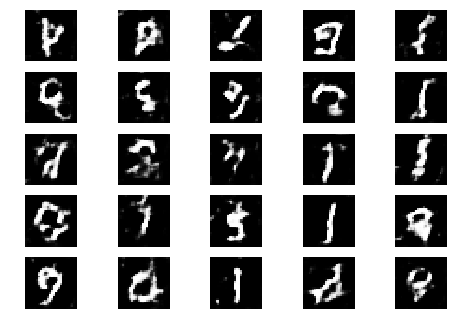

8051 [D loss: 0.999967] [G loss: 1.000047]
8052 [D loss: 0.999977] [G loss: 1.000071]
8053 [D loss: 0.999942] [G loss: 1.000080]
8054 [D loss: 0.999976] [G loss: 1.000056]
8055 [D loss: 0.999960] [G loss: 1.000063]
8056 [D loss: 0.999965] [G loss: 1.000062]
8057 [D loss: 0.999971] [G loss: 1.000076]
8058 [D loss: 0.999975] [G loss: 1.000074]
8059 [D loss: 0.999948] [G loss: 1.000072]
8060 [D loss: 0.999960] [G loss: 1.000067]
8061 [D loss: 0.999958] [G loss: 1.000055]
8062 [D loss: 0.999974] [G loss: 1.000052]
8063 [D loss: 0.999969] [G loss: 1.000075]
8064 [D loss: 0.999975] [G loss: 1.000043]
8065 [D loss: 0.999962] [G loss: 1.000070]
8066 [D loss: 0.999955] [G loss: 1.000065]
8067 [D loss: 0.999963] [G loss: 1.000067]
8068 [D loss: 0.999961] [G loss: 1.000059]
8069 [D loss: 0.999964] [G loss: 1.000058]
8070 [D loss: 0.999962] [G loss: 1.000068]
8071 [D loss: 0.999974] [G loss: 1.000063]
8072 [D loss: 0.999970] [G loss: 1.000051]
8073 [D loss: 0.999963] [G loss: 1.000066]
8074 [D los

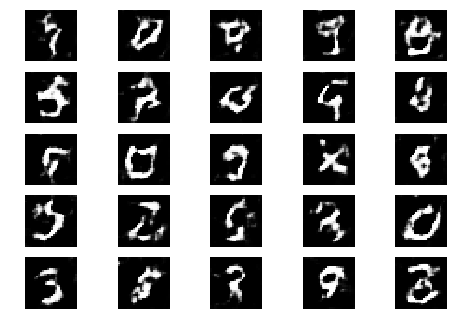

8101 [D loss: 0.999969] [G loss: 1.000064]
8102 [D loss: 0.999975] [G loss: 1.000060]
8103 [D loss: 0.999968] [G loss: 1.000035]
8104 [D loss: 0.999970] [G loss: 1.000062]
8105 [D loss: 0.999984] [G loss: 1.000063]
8106 [D loss: 0.999973] [G loss: 1.000072]
8107 [D loss: 0.999961] [G loss: 1.000083]
8108 [D loss: 0.999962] [G loss: 1.000049]
8109 [D loss: 0.999974] [G loss: 1.000053]
8110 [D loss: 0.999977] [G loss: 1.000059]
8111 [D loss: 0.999981] [G loss: 1.000071]
8112 [D loss: 0.999973] [G loss: 1.000072]
8113 [D loss: 0.999957] [G loss: 1.000061]
8114 [D loss: 0.999972] [G loss: 1.000070]
8115 [D loss: 0.999958] [G loss: 1.000083]
8116 [D loss: 0.999989] [G loss: 1.000048]
8117 [D loss: 0.999973] [G loss: 1.000050]
8118 [D loss: 0.999969] [G loss: 1.000041]
8119 [D loss: 0.999987] [G loss: 1.000068]
8120 [D loss: 0.999973] [G loss: 1.000029]
8121 [D loss: 0.999970] [G loss: 1.000052]
8122 [D loss: 0.999960] [G loss: 1.000055]
8123 [D loss: 0.999978] [G loss: 1.000064]
8124 [D los

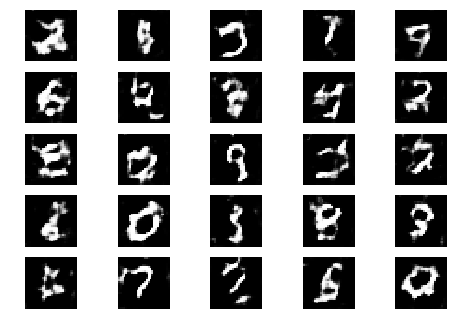

8151 [D loss: 0.999950] [G loss: 1.000056]
8152 [D loss: 0.999982] [G loss: 1.000058]
8153 [D loss: 0.999948] [G loss: 1.000063]
8154 [D loss: 0.999970] [G loss: 1.000047]
8155 [D loss: 0.999964] [G loss: 1.000062]
8156 [D loss: 0.999984] [G loss: 1.000068]
8157 [D loss: 0.999978] [G loss: 1.000077]
8158 [D loss: 0.999980] [G loss: 1.000052]
8159 [D loss: 0.999968] [G loss: 1.000061]
8160 [D loss: 0.999944] [G loss: 1.000072]
8161 [D loss: 0.999965] [G loss: 1.000066]
8162 [D loss: 0.999956] [G loss: 1.000059]
8163 [D loss: 0.999985] [G loss: 1.000064]
8164 [D loss: 0.999962] [G loss: 1.000067]
8165 [D loss: 0.999977] [G loss: 1.000075]
8166 [D loss: 0.999972] [G loss: 1.000032]
8167 [D loss: 0.999977] [G loss: 1.000070]
8168 [D loss: 0.999973] [G loss: 1.000058]
8169 [D loss: 0.999956] [G loss: 1.000073]
8170 [D loss: 0.999979] [G loss: 1.000082]
8171 [D loss: 0.999996] [G loss: 1.000069]
8172 [D loss: 0.999965] [G loss: 1.000063]
8173 [D loss: 0.999966] [G loss: 1.000086]
8174 [D los

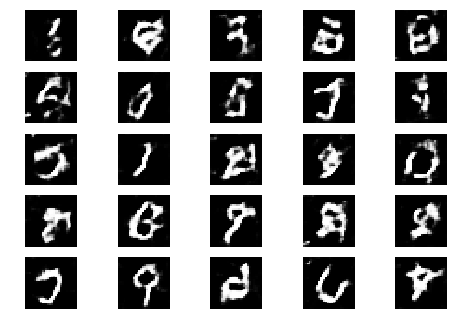

8201 [D loss: 0.999977] [G loss: 1.000073]
8202 [D loss: 0.999942] [G loss: 1.000049]
8203 [D loss: 0.999959] [G loss: 1.000074]
8204 [D loss: 0.999943] [G loss: 1.000033]
8205 [D loss: 0.999971] [G loss: 1.000084]
8206 [D loss: 0.999960] [G loss: 1.000040]
8207 [D loss: 0.999957] [G loss: 1.000066]
8208 [D loss: 0.999966] [G loss: 1.000061]
8209 [D loss: 0.999980] [G loss: 1.000073]
8210 [D loss: 0.999974] [G loss: 1.000046]
8211 [D loss: 0.999957] [G loss: 1.000050]
8212 [D loss: 0.999955] [G loss: 1.000041]
8213 [D loss: 0.999965] [G loss: 1.000052]
8214 [D loss: 0.999981] [G loss: 1.000054]
8215 [D loss: 0.999975] [G loss: 1.000064]
8216 [D loss: 0.999967] [G loss: 1.000036]
8217 [D loss: 0.999978] [G loss: 1.000059]
8218 [D loss: 0.999967] [G loss: 1.000064]
8219 [D loss: 0.999977] [G loss: 1.000033]
8220 [D loss: 0.999945] [G loss: 1.000062]
8221 [D loss: 0.999973] [G loss: 1.000069]
8222 [D loss: 0.999957] [G loss: 1.000063]
8223 [D loss: 0.999975] [G loss: 1.000058]
8224 [D los

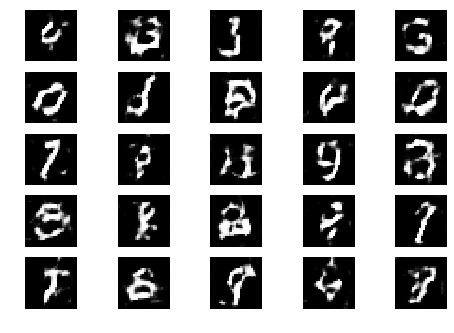

8251 [D loss: 0.999970] [G loss: 1.000058]
8252 [D loss: 0.999970] [G loss: 1.000063]
8253 [D loss: 0.999961] [G loss: 1.000064]
8254 [D loss: 0.999957] [G loss: 1.000062]
8255 [D loss: 0.999973] [G loss: 1.000078]
8256 [D loss: 0.999964] [G loss: 1.000079]
8257 [D loss: 0.999982] [G loss: 1.000077]
8258 [D loss: 0.999957] [G loss: 1.000054]
8259 [D loss: 0.999960] [G loss: 1.000062]
8260 [D loss: 0.999980] [G loss: 1.000092]
8261 [D loss: 0.999968] [G loss: 1.000062]
8262 [D loss: 0.999958] [G loss: 1.000057]
8263 [D loss: 0.999964] [G loss: 1.000077]
8264 [D loss: 0.999963] [G loss: 1.000052]
8265 [D loss: 0.999947] [G loss: 1.000075]
8266 [D loss: 0.999962] [G loss: 1.000066]
8267 [D loss: 0.999969] [G loss: 1.000072]
8268 [D loss: 0.999964] [G loss: 1.000079]
8269 [D loss: 0.999963] [G loss: 1.000078]
8270 [D loss: 0.999969] [G loss: 1.000078]
8271 [D loss: 0.999963] [G loss: 1.000072]
8272 [D loss: 0.999971] [G loss: 1.000052]
8273 [D loss: 0.999964] [G loss: 1.000061]
8274 [D los

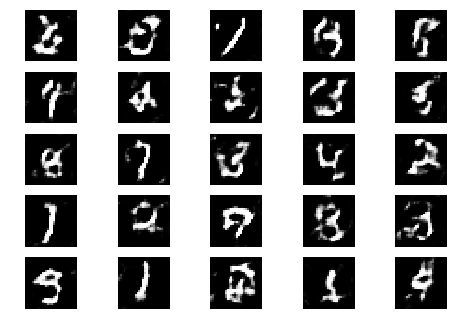

8301 [D loss: 0.999976] [G loss: 1.000062]
8302 [D loss: 0.999968] [G loss: 1.000069]
8303 [D loss: 0.999972] [G loss: 1.000059]
8304 [D loss: 0.999968] [G loss: 1.000063]
8305 [D loss: 0.999954] [G loss: 1.000068]
8306 [D loss: 0.999976] [G loss: 1.000074]
8307 [D loss: 0.999958] [G loss: 1.000077]
8308 [D loss: 0.999963] [G loss: 1.000054]
8309 [D loss: 0.999955] [G loss: 1.000066]
8310 [D loss: 0.999970] [G loss: 1.000045]
8311 [D loss: 0.999973] [G loss: 1.000084]
8312 [D loss: 0.999972] [G loss: 1.000059]
8313 [D loss: 0.999977] [G loss: 1.000052]
8314 [D loss: 0.999974] [G loss: 1.000063]
8315 [D loss: 0.999970] [G loss: 1.000052]
8316 [D loss: 0.999966] [G loss: 1.000073]
8317 [D loss: 0.999967] [G loss: 1.000064]
8318 [D loss: 0.999973] [G loss: 1.000068]
8319 [D loss: 0.999977] [G loss: 1.000051]
8320 [D loss: 0.999965] [G loss: 1.000053]
8321 [D loss: 0.999975] [G loss: 1.000041]
8322 [D loss: 0.999974] [G loss: 1.000063]
8323 [D loss: 0.999974] [G loss: 1.000079]
8324 [D los

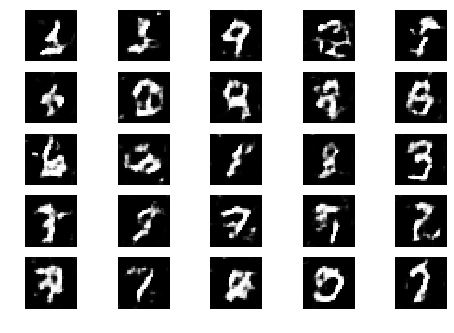

8351 [D loss: 0.999954] [G loss: 1.000044]
8352 [D loss: 0.999948] [G loss: 1.000059]
8353 [D loss: 0.999981] [G loss: 1.000081]
8354 [D loss: 0.999975] [G loss: 1.000067]
8355 [D loss: 0.999964] [G loss: 1.000065]
8356 [D loss: 0.999970] [G loss: 1.000055]
8357 [D loss: 0.999965] [G loss: 1.000070]
8358 [D loss: 0.999976] [G loss: 1.000046]
8359 [D loss: 0.999968] [G loss: 1.000083]
8360 [D loss: 0.999990] [G loss: 1.000049]
8361 [D loss: 0.999972] [G loss: 1.000070]
8362 [D loss: 0.999977] [G loss: 1.000058]
8363 [D loss: 0.999955] [G loss: 1.000038]
8364 [D loss: 0.999966] [G loss: 1.000058]
8365 [D loss: 0.999970] [G loss: 1.000056]
8366 [D loss: 0.999967] [G loss: 1.000062]
8367 [D loss: 0.999965] [G loss: 1.000070]
8368 [D loss: 0.999963] [G loss: 1.000068]
8369 [D loss: 0.999956] [G loss: 1.000057]
8370 [D loss: 0.999980] [G loss: 1.000056]
8371 [D loss: 0.999984] [G loss: 1.000078]
8372 [D loss: 0.999964] [G loss: 1.000070]
8373 [D loss: 0.999960] [G loss: 1.000058]
8374 [D los

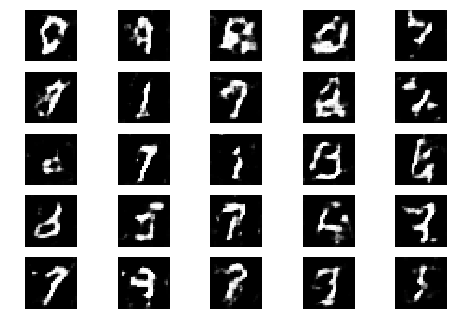

8401 [D loss: 0.999968] [G loss: 1.000058]
8402 [D loss: 0.999978] [G loss: 1.000059]
8403 [D loss: 0.999971] [G loss: 1.000056]
8404 [D loss: 0.999962] [G loss: 1.000065]
8405 [D loss: 0.999956] [G loss: 1.000062]
8406 [D loss: 0.999975] [G loss: 1.000057]
8407 [D loss: 0.999974] [G loss: 1.000106]
8408 [D loss: 0.999977] [G loss: 1.000038]
8409 [D loss: 0.999964] [G loss: 1.000059]
8410 [D loss: 0.999970] [G loss: 1.000062]
8411 [D loss: 0.999965] [G loss: 1.000064]
8412 [D loss: 0.999963] [G loss: 1.000054]
8413 [D loss: 0.999957] [G loss: 1.000083]
8414 [D loss: 0.999968] [G loss: 1.000046]
8415 [D loss: 0.999975] [G loss: 1.000055]
8416 [D loss: 0.999962] [G loss: 1.000047]
8417 [D loss: 0.999962] [G loss: 1.000041]
8418 [D loss: 0.999986] [G loss: 1.000063]
8419 [D loss: 0.999990] [G loss: 1.000040]
8420 [D loss: 0.999962] [G loss: 1.000036]
8421 [D loss: 0.999986] [G loss: 1.000069]
8422 [D loss: 0.999989] [G loss: 1.000061]
8423 [D loss: 0.999957] [G loss: 1.000095]
8424 [D los

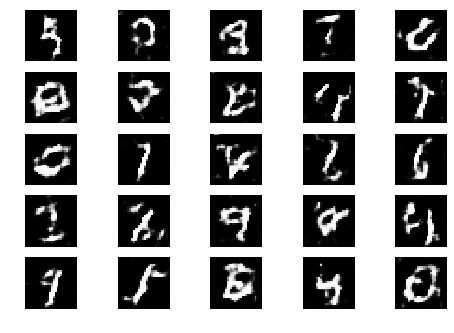

8451 [D loss: 0.999976] [G loss: 1.000043]
8452 [D loss: 0.999970] [G loss: 1.000069]
8453 [D loss: 0.999967] [G loss: 1.000066]
8454 [D loss: 0.999982] [G loss: 1.000072]
8455 [D loss: 0.999979] [G loss: 1.000068]
8456 [D loss: 0.999958] [G loss: 1.000050]
8457 [D loss: 0.999962] [G loss: 1.000080]
8458 [D loss: 0.999959] [G loss: 1.000062]
8459 [D loss: 0.999952] [G loss: 1.000066]
8460 [D loss: 0.999965] [G loss: 1.000052]
8461 [D loss: 0.999964] [G loss: 1.000060]
8462 [D loss: 0.999983] [G loss: 1.000071]
8463 [D loss: 0.999981] [G loss: 1.000089]
8464 [D loss: 0.999970] [G loss: 1.000058]
8465 [D loss: 0.999976] [G loss: 1.000061]
8466 [D loss: 0.999971] [G loss: 1.000065]
8467 [D loss: 0.999978] [G loss: 1.000067]
8468 [D loss: 0.999961] [G loss: 1.000052]
8469 [D loss: 0.999981] [G loss: 1.000049]
8470 [D loss: 0.999970] [G loss: 1.000072]
8471 [D loss: 0.999963] [G loss: 1.000064]
8472 [D loss: 0.999960] [G loss: 1.000048]
8473 [D loss: 0.999954] [G loss: 1.000050]
8474 [D los

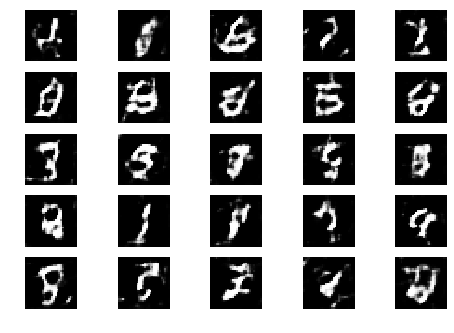

8501 [D loss: 0.999964] [G loss: 1.000059]
8502 [D loss: 0.999969] [G loss: 1.000059]
8503 [D loss: 0.999968] [G loss: 1.000059]
8504 [D loss: 0.999974] [G loss: 1.000051]
8505 [D loss: 0.999970] [G loss: 1.000082]
8506 [D loss: 0.999964] [G loss: 1.000080]
8507 [D loss: 0.999984] [G loss: 1.000052]
8508 [D loss: 0.999967] [G loss: 1.000049]
8509 [D loss: 0.999970] [G loss: 1.000073]
8510 [D loss: 0.999971] [G loss: 1.000053]
8511 [D loss: 0.999972] [G loss: 1.000059]
8512 [D loss: 0.999981] [G loss: 1.000052]
8513 [D loss: 0.999962] [G loss: 1.000067]
8514 [D loss: 0.999959] [G loss: 1.000041]
8515 [D loss: 0.999982] [G loss: 1.000054]
8516 [D loss: 0.999959] [G loss: 1.000083]
8517 [D loss: 0.999973] [G loss: 1.000069]
8518 [D loss: 0.999967] [G loss: 1.000053]
8519 [D loss: 0.999957] [G loss: 1.000068]
8520 [D loss: 0.999981] [G loss: 1.000045]
8521 [D loss: 0.999970] [G loss: 1.000062]
8522 [D loss: 0.999962] [G loss: 1.000047]
8523 [D loss: 0.999970] [G loss: 1.000066]
8524 [D los

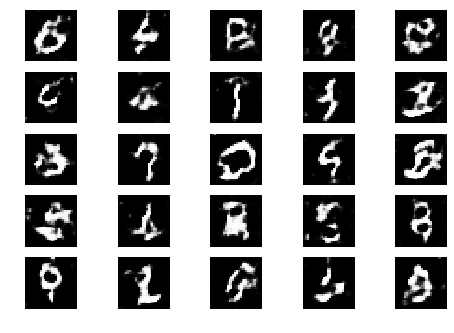

8551 [D loss: 0.999962] [G loss: 1.000052]
8552 [D loss: 0.999951] [G loss: 1.000067]
8553 [D loss: 0.999975] [G loss: 1.000054]
8554 [D loss: 0.999957] [G loss: 1.000047]
8555 [D loss: 0.999958] [G loss: 1.000077]
8556 [D loss: 0.999971] [G loss: 1.000050]
8557 [D loss: 0.999969] [G loss: 1.000042]
8558 [D loss: 0.999950] [G loss: 1.000060]
8559 [D loss: 0.999961] [G loss: 1.000074]
8560 [D loss: 0.999969] [G loss: 1.000043]
8561 [D loss: 0.999971] [G loss: 1.000058]
8562 [D loss: 0.999970] [G loss: 1.000068]
8563 [D loss: 0.999963] [G loss: 1.000064]
8564 [D loss: 0.999968] [G loss: 1.000054]
8565 [D loss: 0.999968] [G loss: 1.000045]
8566 [D loss: 0.999975] [G loss: 1.000068]
8567 [D loss: 0.999979] [G loss: 1.000051]
8568 [D loss: 0.999972] [G loss: 1.000071]
8569 [D loss: 0.999964] [G loss: 1.000042]
8570 [D loss: 0.999970] [G loss: 1.000063]
8571 [D loss: 0.999978] [G loss: 1.000065]
8572 [D loss: 0.999973] [G loss: 1.000059]
8573 [D loss: 0.999976] [G loss: 1.000081]
8574 [D los

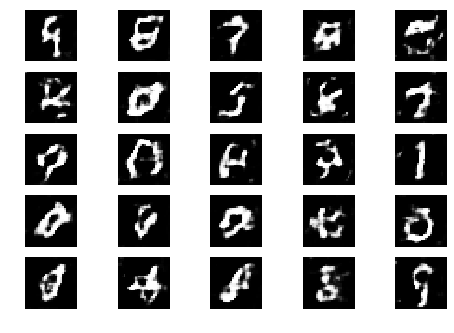

8601 [D loss: 0.999965] [G loss: 1.000068]
8602 [D loss: 0.999960] [G loss: 1.000049]
8603 [D loss: 0.999966] [G loss: 1.000071]
8604 [D loss: 0.999966] [G loss: 1.000065]
8605 [D loss: 0.999965] [G loss: 1.000044]
8606 [D loss: 0.999964] [G loss: 1.000093]
8607 [D loss: 0.999955] [G loss: 1.000083]
8608 [D loss: 0.999961] [G loss: 1.000079]
8609 [D loss: 0.999965] [G loss: 1.000078]
8610 [D loss: 0.999967] [G loss: 1.000061]
8611 [D loss: 0.999959] [G loss: 1.000052]
8612 [D loss: 0.999967] [G loss: 1.000056]
8613 [D loss: 0.999970] [G loss: 1.000084]
8614 [D loss: 0.999958] [G loss: 1.000047]
8615 [D loss: 0.999967] [G loss: 1.000066]
8616 [D loss: 0.999971] [G loss: 1.000079]
8617 [D loss: 0.999965] [G loss: 1.000087]
8618 [D loss: 0.999974] [G loss: 1.000071]
8619 [D loss: 0.999971] [G loss: 1.000077]
8620 [D loss: 0.999972] [G loss: 1.000060]
8621 [D loss: 0.999963] [G loss: 1.000056]
8622 [D loss: 0.999961] [G loss: 1.000074]
8623 [D loss: 0.999955] [G loss: 1.000068]
8624 [D los

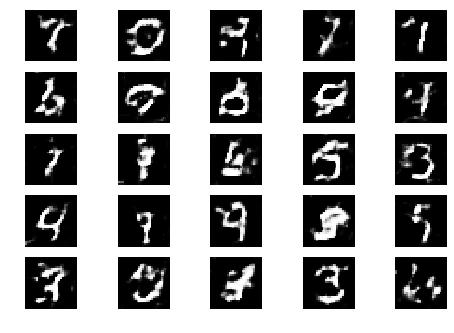

8651 [D loss: 0.999954] [G loss: 1.000024]
8652 [D loss: 0.999964] [G loss: 1.000080]
8653 [D loss: 0.999963] [G loss: 1.000076]
8654 [D loss: 0.999972] [G loss: 1.000053]
8655 [D loss: 0.999984] [G loss: 1.000085]
8656 [D loss: 0.999971] [G loss: 1.000076]
8657 [D loss: 0.999961] [G loss: 1.000069]
8658 [D loss: 0.999974] [G loss: 1.000074]
8659 [D loss: 0.999970] [G loss: 1.000056]
8660 [D loss: 0.999983] [G loss: 1.000056]
8661 [D loss: 0.999962] [G loss: 1.000048]
8662 [D loss: 0.999960] [G loss: 1.000073]
8663 [D loss: 0.999959] [G loss: 1.000062]
8664 [D loss: 0.999977] [G loss: 1.000071]
8665 [D loss: 0.999977] [G loss: 1.000039]
8666 [D loss: 0.999965] [G loss: 1.000074]
8667 [D loss: 0.999960] [G loss: 1.000043]
8668 [D loss: 0.999986] [G loss: 1.000076]
8669 [D loss: 0.999974] [G loss: 1.000075]
8670 [D loss: 0.999945] [G loss: 1.000068]
8671 [D loss: 0.999957] [G loss: 1.000087]
8672 [D loss: 0.999972] [G loss: 1.000086]
8673 [D loss: 0.999987] [G loss: 1.000060]
8674 [D los

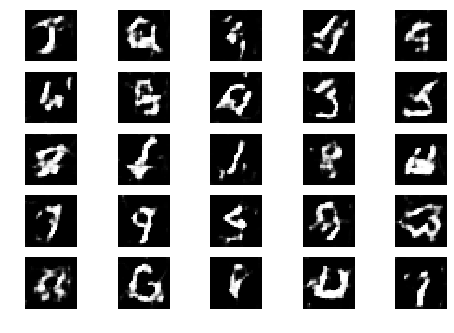

8701 [D loss: 0.999979] [G loss: 1.000039]
8702 [D loss: 0.999966] [G loss: 1.000072]
8703 [D loss: 0.999965] [G loss: 1.000037]
8704 [D loss: 0.999954] [G loss: 1.000060]
8705 [D loss: 0.999954] [G loss: 1.000091]
8706 [D loss: 0.999979] [G loss: 1.000092]
8707 [D loss: 0.999963] [G loss: 1.000070]
8708 [D loss: 0.999961] [G loss: 1.000035]
8709 [D loss: 0.999981] [G loss: 1.000037]
8710 [D loss: 0.999939] [G loss: 1.000065]
8711 [D loss: 0.999964] [G loss: 1.000069]
8712 [D loss: 0.999958] [G loss: 1.000084]
8713 [D loss: 0.999957] [G loss: 1.000033]
8714 [D loss: 0.999962] [G loss: 1.000078]
8715 [D loss: 0.999962] [G loss: 1.000068]
8716 [D loss: 0.999980] [G loss: 1.000032]
8717 [D loss: 0.999980] [G loss: 1.000057]
8718 [D loss: 0.999969] [G loss: 1.000055]
8719 [D loss: 0.999969] [G loss: 1.000055]
8720 [D loss: 0.999951] [G loss: 1.000044]
8721 [D loss: 0.999954] [G loss: 1.000071]
8722 [D loss: 0.999968] [G loss: 1.000082]
8723 [D loss: 0.999974] [G loss: 1.000063]
8724 [D los

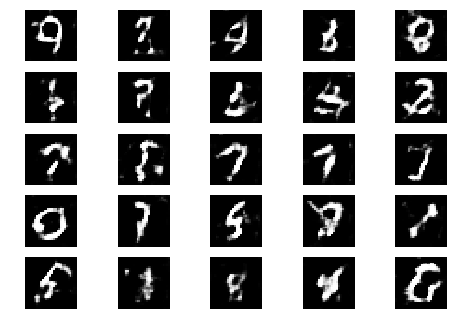

8751 [D loss: 0.999967] [G loss: 1.000094]
8752 [D loss: 0.999958] [G loss: 1.000075]
8753 [D loss: 0.999968] [G loss: 1.000056]
8754 [D loss: 0.999959] [G loss: 1.000039]
8755 [D loss: 0.999987] [G loss: 1.000077]
8756 [D loss: 0.999960] [G loss: 1.000089]
8757 [D loss: 0.999963] [G loss: 1.000058]
8758 [D loss: 0.999972] [G loss: 1.000046]
8759 [D loss: 0.999974] [G loss: 1.000080]
8760 [D loss: 0.999972] [G loss: 1.000076]
8761 [D loss: 0.999953] [G loss: 1.000079]
8762 [D loss: 0.999979] [G loss: 1.000044]
8763 [D loss: 0.999972] [G loss: 1.000076]
8764 [D loss: 0.999970] [G loss: 1.000057]
8765 [D loss: 0.999966] [G loss: 1.000066]
8766 [D loss: 0.999964] [G loss: 1.000077]
8767 [D loss: 0.999965] [G loss: 1.000086]
8768 [D loss: 0.999981] [G loss: 1.000053]
8769 [D loss: 0.999944] [G loss: 1.000057]
8770 [D loss: 0.999958] [G loss: 1.000058]
8771 [D loss: 0.999970] [G loss: 1.000052]
8772 [D loss: 0.999973] [G loss: 1.000054]
8773 [D loss: 0.999974] [G loss: 1.000075]
8774 [D los

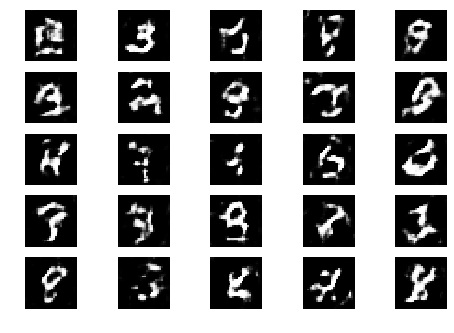

8801 [D loss: 0.999958] [G loss: 1.000081]
8802 [D loss: 0.999975] [G loss: 1.000056]
8803 [D loss: 0.999960] [G loss: 1.000069]
8804 [D loss: 0.999979] [G loss: 1.000066]
8805 [D loss: 0.999985] [G loss: 1.000043]
8806 [D loss: 0.999986] [G loss: 1.000064]
8807 [D loss: 0.999961] [G loss: 1.000070]
8808 [D loss: 0.999959] [G loss: 1.000052]
8809 [D loss: 0.999970] [G loss: 1.000064]
8810 [D loss: 0.999960] [G loss: 1.000059]
8811 [D loss: 0.999971] [G loss: 1.000055]
8812 [D loss: 0.999972] [G loss: 1.000070]
8813 [D loss: 0.999967] [G loss: 1.000069]
8814 [D loss: 0.999963] [G loss: 1.000062]
8815 [D loss: 0.999969] [G loss: 1.000069]
8816 [D loss: 0.999975] [G loss: 1.000062]
8817 [D loss: 0.999957] [G loss: 1.000044]
8818 [D loss: 0.999972] [G loss: 1.000052]
8819 [D loss: 0.999958] [G loss: 1.000056]
8820 [D loss: 0.999953] [G loss: 1.000078]
8821 [D loss: 0.999962] [G loss: 1.000068]
8822 [D loss: 0.999972] [G loss: 1.000040]
8823 [D loss: 0.999958] [G loss: 1.000088]
8824 [D los

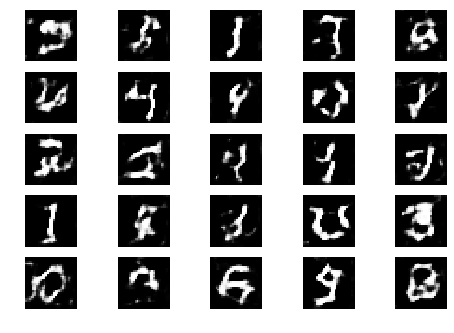

8851 [D loss: 0.999976] [G loss: 1.000061]
8852 [D loss: 0.999962] [G loss: 1.000053]
8853 [D loss: 0.999966] [G loss: 1.000054]
8854 [D loss: 0.999969] [G loss: 1.000059]
8855 [D loss: 0.999951] [G loss: 1.000072]
8856 [D loss: 0.999974] [G loss: 1.000064]
8857 [D loss: 0.999979] [G loss: 1.000075]
8858 [D loss: 0.999962] [G loss: 1.000055]
8859 [D loss: 0.999960] [G loss: 1.000054]
8860 [D loss: 0.999951] [G loss: 1.000060]
8861 [D loss: 0.999962] [G loss: 1.000046]
8862 [D loss: 0.999967] [G loss: 1.000075]
8863 [D loss: 0.999969] [G loss: 1.000059]
8864 [D loss: 0.999970] [G loss: 1.000041]
8865 [D loss: 0.999977] [G loss: 1.000063]
8866 [D loss: 0.999979] [G loss: 1.000025]
8867 [D loss: 0.999987] [G loss: 1.000046]
8868 [D loss: 0.999971] [G loss: 1.000098]
8869 [D loss: 0.999966] [G loss: 1.000073]
8870 [D loss: 0.999974] [G loss: 1.000056]
8871 [D loss: 0.999973] [G loss: 1.000077]
8872 [D loss: 0.999982] [G loss: 1.000055]
8873 [D loss: 0.999955] [G loss: 1.000060]
8874 [D los

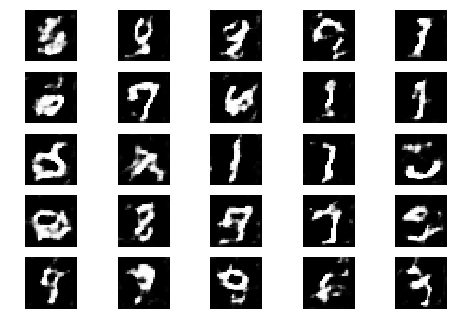

8901 [D loss: 0.999967] [G loss: 1.000062]
8902 [D loss: 0.999963] [G loss: 1.000041]
8903 [D loss: 0.999955] [G loss: 1.000056]
8904 [D loss: 0.999976] [G loss: 1.000057]
8905 [D loss: 0.999964] [G loss: 1.000057]
8906 [D loss: 0.999982] [G loss: 1.000058]
8907 [D loss: 0.999972] [G loss: 1.000076]
8908 [D loss: 0.999961] [G loss: 1.000061]
8909 [D loss: 0.999972] [G loss: 1.000073]
8910 [D loss: 0.999977] [G loss: 1.000068]
8911 [D loss: 0.999968] [G loss: 1.000068]
8912 [D loss: 0.999966] [G loss: 1.000059]
8913 [D loss: 0.999986] [G loss: 1.000066]
8914 [D loss: 0.999957] [G loss: 1.000054]
8915 [D loss: 0.999972] [G loss: 1.000068]
8916 [D loss: 0.999980] [G loss: 1.000077]
8917 [D loss: 0.999973] [G loss: 1.000042]
8918 [D loss: 0.999965] [G loss: 1.000052]
8919 [D loss: 0.999965] [G loss: 1.000045]
8920 [D loss: 0.999961] [G loss: 1.000069]
8921 [D loss: 0.999985] [G loss: 1.000060]
8922 [D loss: 0.999962] [G loss: 1.000062]
8923 [D loss: 0.999963] [G loss: 1.000039]
8924 [D los

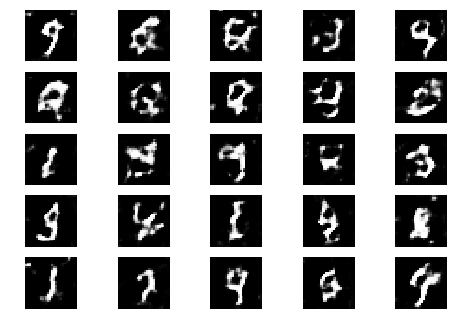

8951 [D loss: 0.999951] [G loss: 1.000061]
8952 [D loss: 0.999962] [G loss: 1.000084]
8953 [D loss: 0.999943] [G loss: 1.000114]
8954 [D loss: 0.999977] [G loss: 1.000027]
8955 [D loss: 0.999964] [G loss: 1.000079]
8956 [D loss: 0.999980] [G loss: 0.999991]
8957 [D loss: 0.999969] [G loss: 1.000051]
8958 [D loss: 0.999964] [G loss: 1.000056]
8959 [D loss: 0.999950] [G loss: 1.000052]
8960 [D loss: 0.999975] [G loss: 1.000050]
8961 [D loss: 0.999967] [G loss: 1.000055]
8962 [D loss: 0.999963] [G loss: 1.000043]
8963 [D loss: 0.999957] [G loss: 1.000054]
8964 [D loss: 0.999965] [G loss: 1.000030]
8965 [D loss: 0.999970] [G loss: 1.000053]
8966 [D loss: 0.999975] [G loss: 1.000049]
8967 [D loss: 0.999956] [G loss: 1.000058]
8968 [D loss: 0.999948] [G loss: 1.000074]
8969 [D loss: 0.999971] [G loss: 1.000043]
8970 [D loss: 0.999981] [G loss: 1.000065]
8971 [D loss: 0.999951] [G loss: 1.000047]
8972 [D loss: 0.999968] [G loss: 1.000043]
8973 [D loss: 0.999955] [G loss: 1.000069]
8974 [D los

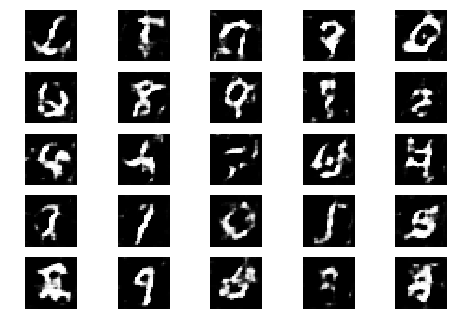

9001 [D loss: 0.999963] [G loss: 1.000059]
9002 [D loss: 0.999968] [G loss: 1.000062]
9003 [D loss: 0.999976] [G loss: 1.000039]
9004 [D loss: 0.999963] [G loss: 1.000043]
9005 [D loss: 0.999977] [G loss: 1.000058]
9006 [D loss: 0.999969] [G loss: 1.000065]
9007 [D loss: 0.999955] [G loss: 1.000061]
9008 [D loss: 0.999988] [G loss: 1.000065]
9009 [D loss: 0.999964] [G loss: 1.000061]
9010 [D loss: 0.999981] [G loss: 1.000069]
9011 [D loss: 0.999961] [G loss: 1.000071]
9012 [D loss: 0.999953] [G loss: 1.000046]
9013 [D loss: 0.999957] [G loss: 1.000061]
9014 [D loss: 0.999956] [G loss: 1.000055]
9015 [D loss: 0.999970] [G loss: 1.000068]
9016 [D loss: 0.999976] [G loss: 1.000058]
9017 [D loss: 0.999952] [G loss: 1.000067]
9018 [D loss: 0.999965] [G loss: 1.000054]
9019 [D loss: 0.999972] [G loss: 1.000067]
9020 [D loss: 0.999971] [G loss: 1.000064]
9021 [D loss: 0.999972] [G loss: 1.000066]
9022 [D loss: 0.999973] [G loss: 1.000064]
9023 [D loss: 0.999961] [G loss: 1.000056]
9024 [D los

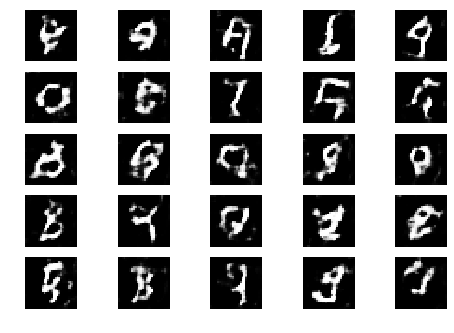

9051 [D loss: 0.999967] [G loss: 1.000055]
9052 [D loss: 0.999969] [G loss: 1.000050]
9053 [D loss: 0.999964] [G loss: 1.000068]
9054 [D loss: 0.999969] [G loss: 1.000043]
9055 [D loss: 0.999962] [G loss: 1.000065]
9056 [D loss: 0.999965] [G loss: 1.000058]
9057 [D loss: 0.999971] [G loss: 1.000081]
9058 [D loss: 0.999973] [G loss: 1.000076]
9059 [D loss: 0.999974] [G loss: 1.000061]
9060 [D loss: 0.999966] [G loss: 1.000079]
9061 [D loss: 0.999976] [G loss: 1.000066]
9062 [D loss: 0.999972] [G loss: 1.000055]
9063 [D loss: 0.999975] [G loss: 1.000068]
9064 [D loss: 0.999973] [G loss: 1.000058]
9065 [D loss: 0.999967] [G loss: 1.000037]
9066 [D loss: 0.999950] [G loss: 1.000048]
9067 [D loss: 0.999956] [G loss: 1.000081]
9068 [D loss: 0.999979] [G loss: 1.000045]
9069 [D loss: 0.999961] [G loss: 1.000050]
9070 [D loss: 0.999974] [G loss: 1.000055]
9071 [D loss: 0.999974] [G loss: 1.000075]
9072 [D loss: 0.999970] [G loss: 1.000061]
9073 [D loss: 0.999982] [G loss: 1.000071]
9074 [D los

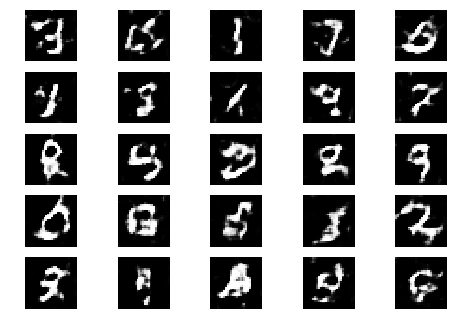

9101 [D loss: 0.999975] [G loss: 1.000064]
9102 [D loss: 0.999964] [G loss: 1.000069]
9103 [D loss: 0.999971] [G loss: 1.000047]
9104 [D loss: 0.999966] [G loss: 1.000059]
9105 [D loss: 0.999963] [G loss: 1.000071]
9106 [D loss: 0.999965] [G loss: 1.000039]
9107 [D loss: 0.999972] [G loss: 1.000046]
9108 [D loss: 0.999964] [G loss: 1.000057]
9109 [D loss: 0.999967] [G loss: 1.000058]
9110 [D loss: 0.999966] [G loss: 1.000063]
9111 [D loss: 0.999974] [G loss: 1.000066]
9112 [D loss: 0.999980] [G loss: 1.000052]
9113 [D loss: 0.999954] [G loss: 1.000046]
9114 [D loss: 0.999993] [G loss: 1.000068]
9115 [D loss: 0.999967] [G loss: 1.000069]
9116 [D loss: 0.999979] [G loss: 1.000065]
9117 [D loss: 0.999967] [G loss: 1.000067]
9118 [D loss: 0.999965] [G loss: 1.000050]
9119 [D loss: 0.999970] [G loss: 1.000068]
9120 [D loss: 0.999948] [G loss: 1.000057]
9121 [D loss: 0.999981] [G loss: 1.000045]
9122 [D loss: 0.999952] [G loss: 1.000057]
9123 [D loss: 0.999973] [G loss: 1.000057]
9124 [D los

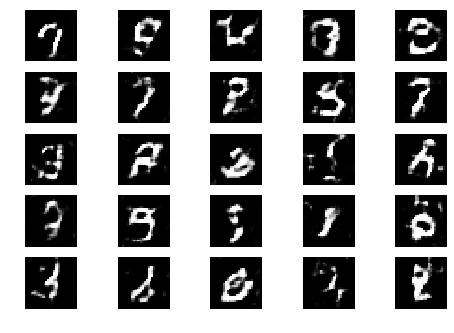

9151 [D loss: 0.999982] [G loss: 1.000070]
9152 [D loss: 0.999963] [G loss: 1.000060]
9153 [D loss: 0.999964] [G loss: 1.000077]
9154 [D loss: 0.999962] [G loss: 1.000064]
9155 [D loss: 0.999975] [G loss: 1.000048]
9156 [D loss: 0.999950] [G loss: 1.000048]
9157 [D loss: 0.999969] [G loss: 1.000049]
9158 [D loss: 0.999978] [G loss: 1.000061]
9159 [D loss: 0.999965] [G loss: 1.000049]
9160 [D loss: 0.999953] [G loss: 1.000048]
9161 [D loss: 0.999975] [G loss: 1.000049]
9162 [D loss: 0.999951] [G loss: 1.000072]
9163 [D loss: 0.999980] [G loss: 1.000074]
9164 [D loss: 0.999953] [G loss: 1.000042]
9165 [D loss: 0.999968] [G loss: 1.000045]
9166 [D loss: 0.999970] [G loss: 1.000043]
9167 [D loss: 0.999976] [G loss: 1.000061]
9168 [D loss: 0.999968] [G loss: 1.000058]
9169 [D loss: 0.999965] [G loss: 1.000058]
9170 [D loss: 0.999976] [G loss: 1.000069]
9171 [D loss: 0.999955] [G loss: 1.000083]
9172 [D loss: 0.999969] [G loss: 1.000047]
9173 [D loss: 0.999969] [G loss: 1.000070]
9174 [D los

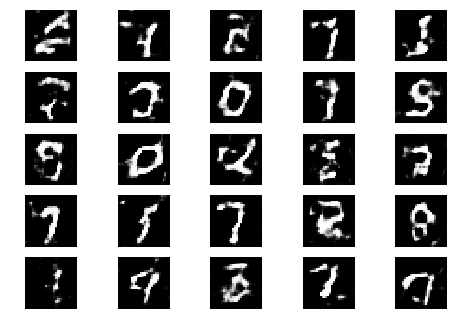

9201 [D loss: 0.999960] [G loss: 1.000070]
9202 [D loss: 0.999963] [G loss: 1.000064]
9203 [D loss: 0.999976] [G loss: 1.000068]
9204 [D loss: 0.999972] [G loss: 1.000058]
9205 [D loss: 0.999986] [G loss: 1.000051]
9206 [D loss: 0.999967] [G loss: 1.000072]
9207 [D loss: 0.999954] [G loss: 1.000057]
9208 [D loss: 0.999968] [G loss: 1.000065]
9209 [D loss: 0.999968] [G loss: 1.000062]
9210 [D loss: 0.999961] [G loss: 1.000048]
9211 [D loss: 0.999965] [G loss: 1.000064]
9212 [D loss: 0.999956] [G loss: 1.000062]
9213 [D loss: 0.999980] [G loss: 1.000069]
9214 [D loss: 0.999972] [G loss: 1.000049]
9215 [D loss: 0.999958] [G loss: 1.000071]
9216 [D loss: 0.999979] [G loss: 1.000052]
9217 [D loss: 0.999944] [G loss: 1.000067]
9218 [D loss: 0.999982] [G loss: 1.000066]
9219 [D loss: 0.999973] [G loss: 1.000038]
9220 [D loss: 0.999961] [G loss: 1.000071]
9221 [D loss: 0.999967] [G loss: 1.000067]
9222 [D loss: 0.999977] [G loss: 1.000075]
9223 [D loss: 0.999961] [G loss: 1.000080]
9224 [D los

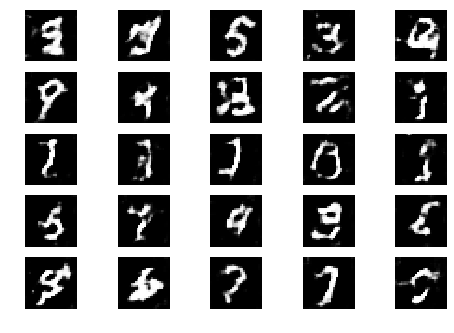

9251 [D loss: 0.999972] [G loss: 1.000031]
9252 [D loss: 0.999950] [G loss: 1.000067]
9253 [D loss: 0.999953] [G loss: 1.000073]
9254 [D loss: 0.999967] [G loss: 1.000070]
9255 [D loss: 0.999966] [G loss: 1.000060]
9256 [D loss: 0.999969] [G loss: 1.000053]
9257 [D loss: 0.999975] [G loss: 1.000059]
9258 [D loss: 0.999972] [G loss: 1.000059]
9259 [D loss: 0.999967] [G loss: 1.000047]
9260 [D loss: 0.999967] [G loss: 1.000052]
9261 [D loss: 0.999958] [G loss: 1.000058]
9262 [D loss: 0.999976] [G loss: 1.000064]
9263 [D loss: 0.999966] [G loss: 1.000048]
9264 [D loss: 0.999973] [G loss: 1.000068]
9265 [D loss: 0.999971] [G loss: 1.000054]
9266 [D loss: 0.999969] [G loss: 1.000077]
9267 [D loss: 0.999964] [G loss: 1.000074]
9268 [D loss: 0.999958] [G loss: 1.000056]
9269 [D loss: 0.999964] [G loss: 1.000073]
9270 [D loss: 0.999960] [G loss: 1.000059]
9271 [D loss: 0.999969] [G loss: 1.000072]
9272 [D loss: 0.999975] [G loss: 1.000050]
9273 [D loss: 0.999974] [G loss: 1.000077]
9274 [D los

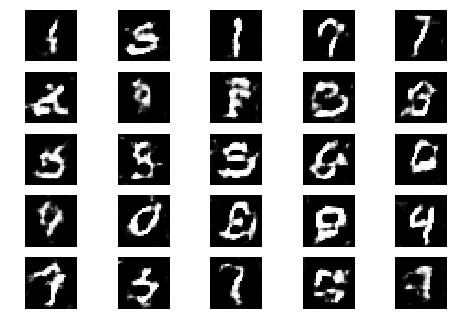

9301 [D loss: 0.999964] [G loss: 1.000060]
9302 [D loss: 0.999971] [G loss: 1.000036]
9303 [D loss: 0.999959] [G loss: 1.000068]
9304 [D loss: 0.999968] [G loss: 1.000074]
9305 [D loss: 0.999954] [G loss: 1.000046]
9306 [D loss: 0.999979] [G loss: 1.000056]
9307 [D loss: 0.999972] [G loss: 1.000043]
9308 [D loss: 0.999964] [G loss: 1.000038]
9309 [D loss: 0.999959] [G loss: 1.000061]
9310 [D loss: 0.999963] [G loss: 1.000036]
9311 [D loss: 0.999975] [G loss: 1.000072]
9312 [D loss: 0.999961] [G loss: 1.000082]
9313 [D loss: 0.999974] [G loss: 1.000050]
9314 [D loss: 0.999981] [G loss: 1.000042]
9315 [D loss: 0.999961] [G loss: 1.000051]
9316 [D loss: 0.999974] [G loss: 1.000066]
9317 [D loss: 0.999964] [G loss: 1.000047]
9318 [D loss: 0.999971] [G loss: 1.000051]
9319 [D loss: 0.999966] [G loss: 1.000089]
9320 [D loss: 0.999977] [G loss: 1.000078]
9321 [D loss: 0.999967] [G loss: 1.000080]
9322 [D loss: 0.999967] [G loss: 1.000073]
9323 [D loss: 0.999999] [G loss: 1.000061]
9324 [D los

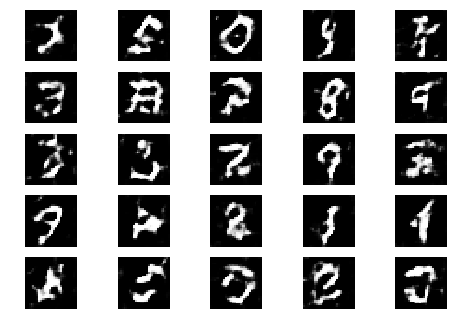

9351 [D loss: 0.999969] [G loss: 1.000078]
9352 [D loss: 0.999955] [G loss: 1.000044]
9353 [D loss: 0.999973] [G loss: 1.000080]
9354 [D loss: 0.999979] [G loss: 1.000045]
9355 [D loss: 0.999963] [G loss: 1.000062]
9356 [D loss: 0.999951] [G loss: 1.000072]
9357 [D loss: 0.999981] [G loss: 1.000089]
9358 [D loss: 0.999980] [G loss: 1.000063]
9359 [D loss: 0.999978] [G loss: 1.000040]
9360 [D loss: 0.999967] [G loss: 1.000073]
9361 [D loss: 0.999975] [G loss: 1.000076]
9362 [D loss: 0.999974] [G loss: 1.000058]
9363 [D loss: 0.999944] [G loss: 1.000021]
9364 [D loss: 0.999963] [G loss: 1.000070]
9365 [D loss: 0.999970] [G loss: 1.000103]
9366 [D loss: 0.999956] [G loss: 1.000049]
9367 [D loss: 0.999964] [G loss: 1.000051]
9368 [D loss: 0.999975] [G loss: 1.000079]
9369 [D loss: 0.999967] [G loss: 1.000026]
9370 [D loss: 0.999967] [G loss: 1.000070]
9371 [D loss: 0.999959] [G loss: 1.000056]
9372 [D loss: 0.999953] [G loss: 1.000092]
9373 [D loss: 0.999977] [G loss: 1.000072]
9374 [D los

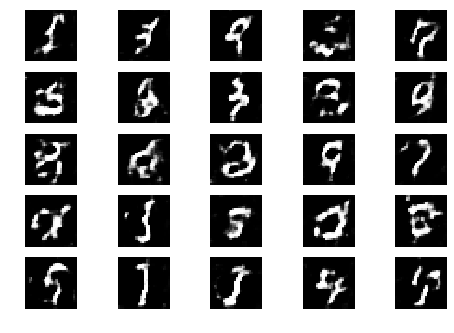

9401 [D loss: 0.999965] [G loss: 1.000068]
9402 [D loss: 0.999962] [G loss: 1.000064]
9403 [D loss: 0.999976] [G loss: 1.000065]
9404 [D loss: 0.999972] [G loss: 1.000065]
9405 [D loss: 0.999966] [G loss: 1.000059]
9406 [D loss: 0.999968] [G loss: 1.000069]
9407 [D loss: 0.999968] [G loss: 1.000042]
9408 [D loss: 0.999985] [G loss: 1.000049]
9409 [D loss: 0.999970] [G loss: 1.000053]
9410 [D loss: 0.999961] [G loss: 1.000075]
9411 [D loss: 0.999965] [G loss: 1.000078]
9412 [D loss: 0.999971] [G loss: 1.000044]
9413 [D loss: 0.999969] [G loss: 1.000057]
9414 [D loss: 0.999975] [G loss: 1.000046]
9415 [D loss: 0.999981] [G loss: 1.000048]
9416 [D loss: 0.999974] [G loss: 1.000061]
9417 [D loss: 0.999978] [G loss: 1.000050]
9418 [D loss: 0.999962] [G loss: 1.000061]
9419 [D loss: 0.999982] [G loss: 1.000052]
9420 [D loss: 0.999954] [G loss: 1.000061]
9421 [D loss: 0.999968] [G loss: 1.000040]
9422 [D loss: 0.999968] [G loss: 1.000050]
9423 [D loss: 0.999963] [G loss: 1.000054]
9424 [D los

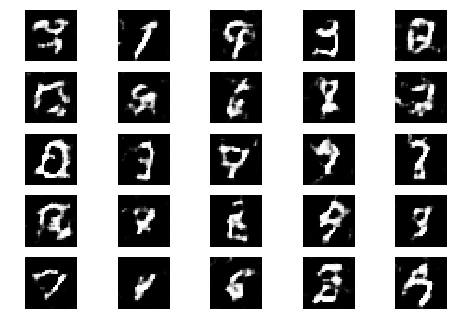

9451 [D loss: 0.999959] [G loss: 1.000054]
9452 [D loss: 0.999977] [G loss: 1.000082]
9453 [D loss: 0.999970] [G loss: 1.000067]
9454 [D loss: 0.999967] [G loss: 1.000098]
9455 [D loss: 0.999963] [G loss: 1.000046]
9456 [D loss: 0.999958] [G loss: 1.000059]
9457 [D loss: 0.999949] [G loss: 1.000069]
9458 [D loss: 0.999955] [G loss: 1.000064]
9459 [D loss: 0.999975] [G loss: 1.000079]
9460 [D loss: 0.999963] [G loss: 1.000054]
9461 [D loss: 0.999969] [G loss: 1.000110]
9462 [D loss: 0.999977] [G loss: 1.000073]
9463 [D loss: 0.999956] [G loss: 1.000066]
9464 [D loss: 0.999951] [G loss: 1.000046]
9465 [D loss: 0.999970] [G loss: 1.000058]
9466 [D loss: 0.999966] [G loss: 1.000065]
9467 [D loss: 0.999974] [G loss: 1.000057]
9468 [D loss: 0.999981] [G loss: 1.000078]
9469 [D loss: 0.999965] [G loss: 1.000069]
9470 [D loss: 0.999976] [G loss: 1.000036]
9471 [D loss: 0.999956] [G loss: 1.000067]
9472 [D loss: 0.999972] [G loss: 1.000049]
9473 [D loss: 0.999949] [G loss: 1.000066]
9474 [D los

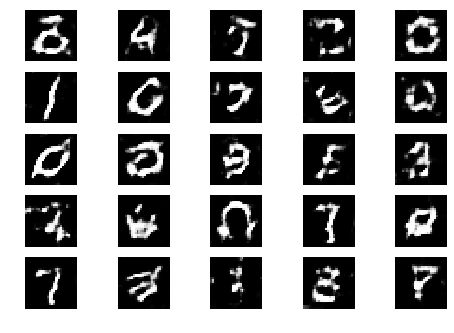

9501 [D loss: 0.999966] [G loss: 1.000027]
9502 [D loss: 0.999969] [G loss: 1.000057]
9503 [D loss: 0.999958] [G loss: 1.000065]
9504 [D loss: 0.999961] [G loss: 1.000060]
9505 [D loss: 0.999951] [G loss: 1.000046]
9506 [D loss: 0.999972] [G loss: 1.000093]
9507 [D loss: 0.999991] [G loss: 1.000048]
9508 [D loss: 0.999944] [G loss: 1.000054]
9509 [D loss: 0.999970] [G loss: 1.000058]
9510 [D loss: 0.999964] [G loss: 1.000071]
9511 [D loss: 0.999959] [G loss: 1.000072]
9512 [D loss: 0.999983] [G loss: 1.000055]
9513 [D loss: 0.999965] [G loss: 1.000053]
9514 [D loss: 0.999969] [G loss: 1.000068]
9515 [D loss: 0.999970] [G loss: 1.000024]
9516 [D loss: 0.999962] [G loss: 1.000040]
9517 [D loss: 0.999971] [G loss: 1.000062]
9518 [D loss: 0.999969] [G loss: 1.000087]
9519 [D loss: 0.999975] [G loss: 1.000062]
9520 [D loss: 0.999975] [G loss: 1.000065]
9521 [D loss: 0.999972] [G loss: 1.000058]
9522 [D loss: 0.999968] [G loss: 1.000083]
9523 [D loss: 0.999958] [G loss: 1.000066]
9524 [D los

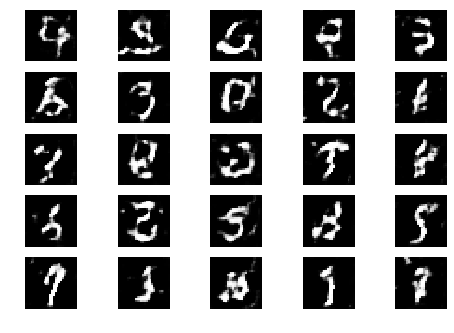

9551 [D loss: 0.999987] [G loss: 1.000059]
9552 [D loss: 0.999963] [G loss: 1.000070]
9553 [D loss: 0.999970] [G loss: 1.000060]
9554 [D loss: 0.999970] [G loss: 1.000045]
9555 [D loss: 0.999968] [G loss: 1.000056]
9556 [D loss: 0.999976] [G loss: 1.000089]
9557 [D loss: 0.999953] [G loss: 1.000072]
9558 [D loss: 0.999966] [G loss: 1.000063]
9559 [D loss: 0.999961] [G loss: 1.000041]
9560 [D loss: 0.999974] [G loss: 1.000061]
9561 [D loss: 0.999952] [G loss: 1.000048]
9562 [D loss: 0.999968] [G loss: 1.000061]
9563 [D loss: 0.999959] [G loss: 1.000057]
9564 [D loss: 0.999968] [G loss: 1.000063]
9565 [D loss: 0.999970] [G loss: 1.000073]
9566 [D loss: 0.999965] [G loss: 1.000060]
9567 [D loss: 0.999962] [G loss: 1.000056]
9568 [D loss: 0.999955] [G loss: 1.000037]
9569 [D loss: 0.999974] [G loss: 1.000061]
9570 [D loss: 0.999974] [G loss: 1.000061]
9571 [D loss: 0.999958] [G loss: 1.000059]
9572 [D loss: 0.999963] [G loss: 1.000052]
9573 [D loss: 0.999973] [G loss: 1.000057]
9574 [D los

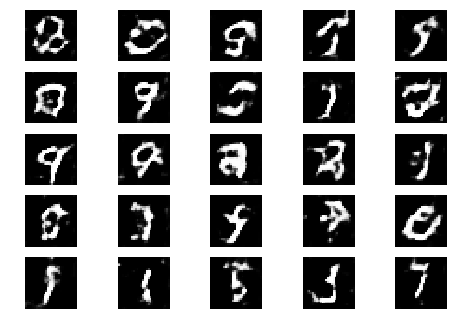

9601 [D loss: 0.999968] [G loss: 1.000059]
9602 [D loss: 0.999975] [G loss: 1.000062]
9603 [D loss: 0.999980] [G loss: 1.000060]
9604 [D loss: 0.999981] [G loss: 1.000068]
9605 [D loss: 0.999962] [G loss: 1.000062]
9606 [D loss: 0.999976] [G loss: 1.000056]
9607 [D loss: 0.999957] [G loss: 1.000061]
9608 [D loss: 0.999970] [G loss: 1.000059]
9609 [D loss: 0.999975] [G loss: 1.000056]
9610 [D loss: 0.999945] [G loss: 1.000067]
9611 [D loss: 0.999970] [G loss: 1.000070]
9612 [D loss: 0.999957] [G loss: 1.000067]
9613 [D loss: 0.999965] [G loss: 1.000060]
9614 [D loss: 0.999966] [G loss: 1.000050]
9615 [D loss: 0.999973] [G loss: 1.000057]
9616 [D loss: 0.999966] [G loss: 1.000072]
9617 [D loss: 0.999971] [G loss: 1.000070]
9618 [D loss: 0.999968] [G loss: 1.000071]
9619 [D loss: 0.999956] [G loss: 1.000081]
9620 [D loss: 0.999971] [G loss: 1.000066]
9621 [D loss: 0.999978] [G loss: 1.000043]
9622 [D loss: 0.999977] [G loss: 1.000061]
9623 [D loss: 0.999964] [G loss: 1.000079]
9624 [D los

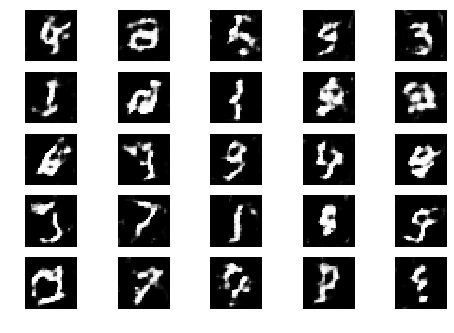

9651 [D loss: 0.999964] [G loss: 1.000049]
9652 [D loss: 0.999971] [G loss: 1.000050]
9653 [D loss: 0.999982] [G loss: 1.000050]
9654 [D loss: 0.999959] [G loss: 1.000063]
9655 [D loss: 0.999963] [G loss: 1.000051]
9656 [D loss: 0.999977] [G loss: 1.000052]
9657 [D loss: 0.999970] [G loss: 1.000061]
9658 [D loss: 0.999964] [G loss: 1.000092]
9659 [D loss: 0.999962] [G loss: 1.000080]
9660 [D loss: 0.999958] [G loss: 1.000068]
9661 [D loss: 0.999966] [G loss: 1.000057]
9662 [D loss: 0.999965] [G loss: 1.000071]
9663 [D loss: 0.999974] [G loss: 1.000056]
9664 [D loss: 0.999959] [G loss: 1.000068]
9665 [D loss: 0.999956] [G loss: 1.000059]
9666 [D loss: 0.999962] [G loss: 1.000083]
9667 [D loss: 0.999962] [G loss: 1.000044]
9668 [D loss: 0.999973] [G loss: 1.000036]
9669 [D loss: 0.999974] [G loss: 1.000067]
9670 [D loss: 0.999967] [G loss: 1.000071]
9671 [D loss: 0.999963] [G loss: 1.000079]
9672 [D loss: 0.999950] [G loss: 1.000074]
9673 [D loss: 0.999980] [G loss: 1.000047]
9674 [D los

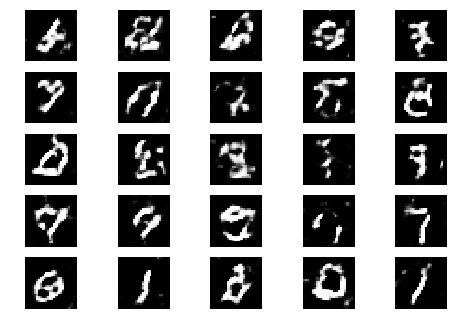

9701 [D loss: 0.999972] [G loss: 1.000067]
9702 [D loss: 0.999958] [G loss: 1.000077]
9703 [D loss: 0.999968] [G loss: 1.000045]
9704 [D loss: 0.999970] [G loss: 1.000090]
9705 [D loss: 0.999965] [G loss: 1.000042]
9706 [D loss: 0.999967] [G loss: 1.000058]
9707 [D loss: 0.999964] [G loss: 1.000060]
9708 [D loss: 0.999968] [G loss: 1.000069]
9709 [D loss: 0.999976] [G loss: 1.000040]
9710 [D loss: 0.999965] [G loss: 1.000040]
9711 [D loss: 0.999967] [G loss: 1.000064]
9712 [D loss: 0.999965] [G loss: 1.000055]
9713 [D loss: 0.999970] [G loss: 1.000071]
9714 [D loss: 0.999979] [G loss: 1.000071]
9715 [D loss: 0.999967] [G loss: 1.000072]
9716 [D loss: 0.999945] [G loss: 1.000077]
9717 [D loss: 0.999975] [G loss: 1.000065]
9718 [D loss: 0.999973] [G loss: 1.000064]
9719 [D loss: 0.999966] [G loss: 1.000083]
9720 [D loss: 0.999968] [G loss: 1.000078]
9721 [D loss: 0.999966] [G loss: 1.000060]
9722 [D loss: 0.999965] [G loss: 1.000053]
9723 [D loss: 0.999972] [G loss: 1.000071]
9724 [D los

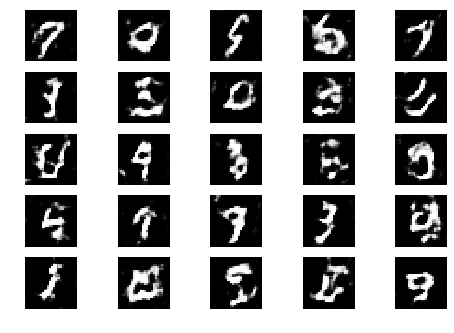

9751 [D loss: 0.999986] [G loss: 1.000055]
9752 [D loss: 0.999972] [G loss: 1.000067]
9753 [D loss: 0.999972] [G loss: 1.000055]
9754 [D loss: 0.999961] [G loss: 1.000060]
9755 [D loss: 0.999965] [G loss: 1.000070]
9756 [D loss: 0.999971] [G loss: 1.000053]
9757 [D loss: 0.999972] [G loss: 1.000065]
9758 [D loss: 0.999965] [G loss: 1.000066]
9759 [D loss: 0.999966] [G loss: 1.000061]
9760 [D loss: 0.999973] [G loss: 1.000058]
9761 [D loss: 0.999964] [G loss: 1.000063]
9762 [D loss: 0.999968] [G loss: 1.000056]
9763 [D loss: 0.999969] [G loss: 1.000073]
9764 [D loss: 0.999967] [G loss: 1.000065]
9765 [D loss: 0.999970] [G loss: 1.000047]
9766 [D loss: 0.999967] [G loss: 1.000062]
9767 [D loss: 0.999962] [G loss: 1.000055]
9768 [D loss: 0.999961] [G loss: 1.000069]
9769 [D loss: 0.999976] [G loss: 1.000039]
9770 [D loss: 0.999968] [G loss: 1.000069]
9771 [D loss: 0.999960] [G loss: 1.000038]
9772 [D loss: 0.999962] [G loss: 1.000060]
9773 [D loss: 0.999965] [G loss: 1.000062]
9774 [D los

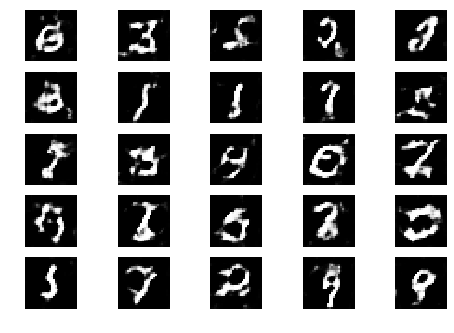

9801 [D loss: 0.999968] [G loss: 1.000065]
9802 [D loss: 0.999976] [G loss: 1.000048]
9803 [D loss: 0.999977] [G loss: 1.000082]
9804 [D loss: 0.999966] [G loss: 1.000059]
9805 [D loss: 0.999960] [G loss: 1.000059]
9806 [D loss: 0.999975] [G loss: 1.000080]
9807 [D loss: 0.999967] [G loss: 1.000060]
9808 [D loss: 0.999961] [G loss: 1.000079]
9809 [D loss: 0.999966] [G loss: 1.000057]
9810 [D loss: 0.999971] [G loss: 1.000074]
9811 [D loss: 0.999957] [G loss: 1.000068]
9812 [D loss: 0.999968] [G loss: 1.000071]
9813 [D loss: 0.999962] [G loss: 1.000068]
9814 [D loss: 0.999959] [G loss: 1.000027]
9815 [D loss: 0.999968] [G loss: 1.000077]
9816 [D loss: 0.999966] [G loss: 1.000072]
9817 [D loss: 0.999971] [G loss: 1.000076]
9818 [D loss: 0.999972] [G loss: 1.000069]
9819 [D loss: 0.999966] [G loss: 1.000082]
9820 [D loss: 0.999961] [G loss: 1.000090]
9821 [D loss: 0.999959] [G loss: 1.000059]
9822 [D loss: 0.999957] [G loss: 1.000062]
9823 [D loss: 0.999960] [G loss: 1.000068]
9824 [D los

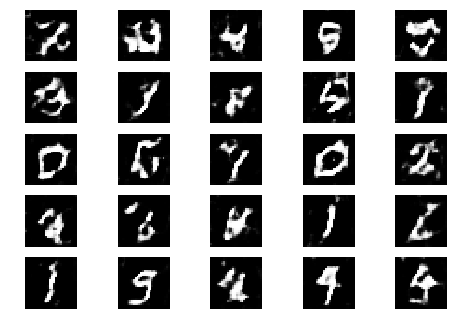

9851 [D loss: 0.999957] [G loss: 1.000058]
9852 [D loss: 0.999978] [G loss: 1.000052]
9853 [D loss: 0.999965] [G loss: 1.000072]
9854 [D loss: 0.999971] [G loss: 1.000058]
9855 [D loss: 0.999971] [G loss: 1.000055]
9856 [D loss: 0.999974] [G loss: 1.000041]
9857 [D loss: 0.999971] [G loss: 1.000065]
9858 [D loss: 0.999952] [G loss: 1.000066]
9859 [D loss: 0.999979] [G loss: 1.000053]
9860 [D loss: 0.999971] [G loss: 1.000062]
9861 [D loss: 0.999981] [G loss: 1.000063]
9862 [D loss: 0.999982] [G loss: 1.000050]
9863 [D loss: 0.999957] [G loss: 1.000062]
9864 [D loss: 0.999967] [G loss: 1.000050]
9865 [D loss: 0.999964] [G loss: 1.000071]
9866 [D loss: 0.999976] [G loss: 1.000071]
9867 [D loss: 0.999974] [G loss: 1.000073]
9868 [D loss: 0.999959] [G loss: 1.000070]
9869 [D loss: 0.999972] [G loss: 1.000060]
9870 [D loss: 0.999956] [G loss: 1.000065]
9871 [D loss: 0.999974] [G loss: 1.000080]
9872 [D loss: 0.999967] [G loss: 1.000054]
9873 [D loss: 0.999965] [G loss: 1.000079]
9874 [D los

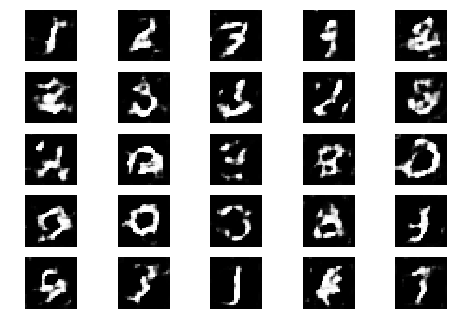

9901 [D loss: 0.999978] [G loss: 1.000061]
9902 [D loss: 0.999969] [G loss: 1.000061]
9903 [D loss: 0.999952] [G loss: 1.000059]
9904 [D loss: 0.999972] [G loss: 1.000065]
9905 [D loss: 0.999968] [G loss: 1.000051]
9906 [D loss: 0.999965] [G loss: 1.000059]
9907 [D loss: 0.999979] [G loss: 1.000062]
9908 [D loss: 0.999963] [G loss: 1.000048]
9909 [D loss: 0.999972] [G loss: 1.000063]
9910 [D loss: 0.999966] [G loss: 1.000069]
9911 [D loss: 0.999977] [G loss: 1.000048]
9912 [D loss: 0.999972] [G loss: 1.000069]
9913 [D loss: 0.999967] [G loss: 1.000056]
9914 [D loss: 0.999976] [G loss: 1.000053]
9915 [D loss: 0.999949] [G loss: 1.000043]
9916 [D loss: 0.999960] [G loss: 1.000078]
9917 [D loss: 0.999962] [G loss: 1.000049]
9918 [D loss: 0.999960] [G loss: 1.000079]
9919 [D loss: 0.999988] [G loss: 1.000067]
9920 [D loss: 0.999981] [G loss: 1.000081]
9921 [D loss: 0.999965] [G loss: 1.000055]
9922 [D loss: 0.999970] [G loss: 1.000048]
9923 [D loss: 0.999957] [G loss: 1.000058]
9924 [D los

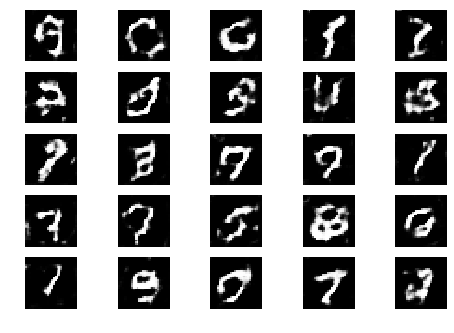

9951 [D loss: 0.999965] [G loss: 1.000054]
9952 [D loss: 0.999971] [G loss: 1.000057]
9953 [D loss: 0.999961] [G loss: 1.000071]
9954 [D loss: 0.999960] [G loss: 1.000033]
9955 [D loss: 0.999970] [G loss: 1.000055]
9956 [D loss: 0.999985] [G loss: 1.000049]
9957 [D loss: 0.999959] [G loss: 1.000081]
9958 [D loss: 0.999977] [G loss: 1.000063]
9959 [D loss: 0.999971] [G loss: 1.000066]
9960 [D loss: 0.999972] [G loss: 1.000054]
9961 [D loss: 0.999962] [G loss: 1.000080]
9962 [D loss: 0.999970] [G loss: 1.000093]
9963 [D loss: 0.999966] [G loss: 1.000051]
9964 [D loss: 0.999978] [G loss: 1.000063]
9965 [D loss: 0.999976] [G loss: 1.000064]
9966 [D loss: 0.999967] [G loss: 1.000059]
9967 [D loss: 0.999956] [G loss: 1.000060]
9968 [D loss: 0.999965] [G loss: 1.000070]
9969 [D loss: 0.999952] [G loss: 1.000073]
9970 [D loss: 0.999972] [G loss: 1.000078]
9971 [D loss: 0.999969] [G loss: 1.000060]
9972 [D loss: 0.999971] [G loss: 1.000057]
9973 [D loss: 0.999986] [G loss: 1.000076]
9974 [D los

In [9]:
if __name__ == '__main__':
    wgan = WGAN()
    wgan.train(epochs=10000, batch_size=32, sample_interval=50)